# Imports

In [ ]:
# Import the necessary libraries

from google.colab import drive
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from typing import cast, Union, List
from torch.nn import LSTM
from torch.autograd import Variable 

# Descriere Generala

În practica de zi cu zi a unui inginer sau cercetător în domeniul învățării automate intra
frecvent următoarele trei aspecte:
* Vizualizarea și “explorarea” datelor unei probleme (Exploratory Data Analysis)
* Încercarea de a extrage atribute ale datelor problemei pentru a fi utilizate în obiectivul
de analiza ales (e.g. clasificare, regresie, detectie de anomalii)
* Investigarea de modele de rețele neurale potrivite pentru extragerea “automată” de
atribute care ajută în obiectivul de analiză ales

În perioada recentă, date de la senzori de orice fel ajung să fie folosiți cu scopul de a colecta
date despre procese dinamice, care evoluează în timp  de la gesturi umane până la date
despre trafic sau tiparul de consum electric al unei gospodării tipice.

Seturile de date alese spre explorare și analiză vor surprinde astfel de procese. În particular,
problemele propuse spre analiză fac parte din categoria celor de clasificare a seriilor
temporale.

* *Sarcinile voastre de lucru vor solicita utilizarea de biblioteci de vizualizare a datelor
(crearea de diagrame), extragerea de atribute (feature extraction) pentru folosirea
algoritmilor de clasificare discutați la curs, precum și utilizarea modelelor de rețele neurale
convoluționale și recurente**



# Descrierea Seturilor de Date

In [ ]:
# Connect to Google Drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# ECG Heartbeat Categorization Dataset

Acest set de date este compus din două colecții de semnale ale bătăilor inimii derivate din două seturi de date celebre în clasificarea bătăilor inimii: **setul de date MIT-BIH pentru aritmii** și **baza de date PTB Diagnostic pentru ECG**. 

Numărul de secvențe din ambele colecții este suficient de mare pentru antrenarea clasificatorilor pe bază de rețele neurale. **Semnalele corespund formelor electrocardiogramei (ECG) ale bătăilor inimii pentru cazul normal și cazurile afectate de diferite aritmii și infarct miocardic.** Aceste semnale sunt preprocesate și segmentate, fiecare segment corespunzând unei bătăi de inimă. 

* **Setul de date MIT-BIH Arrhythmia propune un task de clasificare in 5 clase (tipuri de aritmii),
pe cand PTB Diagnostic ECG propune o clasificare binara (bătaie normala sau anormala a
inimii).**

*Pentru ambele seturi de date, un segment are 188 de valori, dintre care unele valori pot fi
pad-uri finale cu valori de 0. Pentru ambele seturi de date, ultima coloana din cele 188 reprezinta eticheta tipului de aritmie (intre 0-4 pentru MITBIH, sau 0/1 - normal/anormal - pentru PTB).*

Notă: Descărcarea setului de date ECG Heartbeat Categorization Dataset se face de la https://www.kaggle.com/datasets/shayanfazeli/heartbeat?resource=download


# MIT-BIH Arrhythmia

---


In [ ]:
# Load data from CSV file into a Pandas DataFrame

df_train = pd.read_csv('/content/gdrive/MyDrive/ecg_mitbih/mitbih_train.csv', header=None)
df_test = pd.read_csv('/content/gdrive/MyDrive/ecg_mitbih/mitbih_test.csv', header=None)

X_mb_train = df_train.drop(df_train.columns[[187]],axis = 1)
y_mb_train = df_train.iloc[:,187]

X_mb_test = df_test.drop(df_test.columns[[187]],axis = 1)
y_mb_test = df_test.iloc[:,187]

X_mb_train['label'] = y_mb_train
X_mb_test['label'] = y_mb_test

print(y_mb_train)
print(X_mb_train)

print(len(y_mb_train), len(y_mb_test))

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
87549    4.0
87550    4.0
87551    4.0
87552    4.0
87553    4.0
Name: 187, Length: 87554, dtype: float64
              0         1         2         3         4         5         6  \
0      0.977941  0.926471  0.681373  0.245098  0.154412  0.191176  0.151961   
1      0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
2      1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   
3      0.925414  0.665746  0.541436  0.276243  0.196133  0.077348  0.071823   
4      0.967136  1.000000  0.830986  0.586854  0.356808  0.248826  0.145540   
...         ...       ...       ...       ...       ...       ...       ...   
87549  0.807018  0.494737  0.536842  0.529825  0.491228  0.484211  0.456140   
87550  0.718333  0.605000  0.486667  0.361667  0.231667  0.120000  0.051667   
87551  0.906122  0.624490  0.595918  0.575510  0.530612  0.481633  0.444898   
87552  0.858228  0.645570 

# PTB Diagnostic ECG

---

In [ ]:
# Load data from CSV file into a Pandas DataFrame

df_train = pd.read_csv('/content/gdrive/MyDrive/ecg_mitbih/ptbdb_train.csv', header=None)
df_test = pd.read_csv('/content/gdrive/MyDrive/ecg_mitbih/ptbdb_test.csv', header=None)

X_pt_train = df_train.drop(df_train.columns[[187]],axis = 1)
y_pt_train = df_train.iloc[:,187]

X_pt_test = df_test.drop(df_test.columns[[187]],axis = 1)
y_pt_test = df_test.iloc[:,187]

y_pt_train = y_pt_train.astype(float)
y_pt_test = y_pt_test.astype(float)

X_pt_train['label'] = y_pt_train
X_pt_test['label'] = y_pt_test

print(y_pt_train)
print(X_pt_train)

print(len(y_pt_train), len(y_pt_test))

0        0.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
11635    1.0
11636    1.0
11637    1.0
11638    0.0
11639    1.0
Name: 187, Length: 11640, dtype: float64
              0         1         2         3         4         5         6  \
0      1.000000  0.916264  0.338164  0.067633  0.074477  0.139291  0.140902   
1      0.969159  0.619349  0.386565  0.264047  0.250951  0.221800  0.215040   
2      1.000000  0.624483  0.076963  0.043130  0.066632  0.087035  0.086519   
3      1.000000  0.644208  0.146572  0.000000  0.128251  0.203901  0.257092   
4      0.899180  0.864930  0.604438  0.272069  0.195369  0.204534  0.121081   
...         ...       ...       ...       ...       ...       ...       ...   
11635  0.981928  0.747992  0.395582  0.096386  0.186747  0.174699  0.171687   
11636  1.000000  0.917085  0.474874  0.125628  0.000000  0.333333  0.561558   
11637  0.967667  0.515012  0.079099  0.023672  0.176674  0.174365  0.197460   
11638  1.000000  0.700711 

In [ ]:
# X_train = pd.concat([X_mb_train, X_pt_train], ignore_index=True)
# X_test = pd.concat([X_mb_test, X_pt_test], ignore_index=True)

In [ ]:
# X_train

0         1         2         3         4         5         6  \
0      0.977941  0.926471  0.681373  0.245098  0.154412  0.191176  0.151961   
1      0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
2      1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   
3      0.925414  0.665746  0.541436  0.276243  0.196133  0.077348  0.071823   
4      0.967136  1.000000  0.830986  0.586854  0.356808  0.248826  0.145540   
...         ...       ...       ...       ...       ...       ...       ...   
99189  0.981928  0.747992  0.395582  0.096386  0.186747  0.174699  0.171687   
99190  1.000000  0.917085  0.474874  0.125628  0.000000  0.333333  0.561558   
99191  0.967667  0.515012  0.079099  0.023672  0.176674  0.174365  0.197460   
99192  1.000000  0.700711  0.349063  0.106658  0.077569  0.301228  0.371041   
99193  1.000000  0.712982  0.237246  0.072584  0.004977  0.019494  0.053505   

              7         8         9  ...  178  179  180  181  182  183  184  \
0      0.085784  0.058824  0.049020  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1      0.088319  0.074074  0.082621  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2      0.043243  0.054054  0.045946  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3      0.060773  0.066298  0.058011  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4      0.089202  0.117371  0.150235  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...         ...       ...       ...  ...  ...  ...  ...  ...  ...  ...  ...   
99189  0.202811  0.162651  0.181727  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
99190  0.709799  0.753769  0.765913  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
99191  0.182448  0.184758  0.173210  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
99192  0.371687  0.404008  0.411765  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
99193  0.067607  0.081709  0.083368  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       185  186  label  
0      0.0  0.0    0.0  
1      0.0  0.0    0.0  
2      0.0  0.0    0.0  
3      0.0  0.0    0.0  
4      0.0  0.0    0.0  
...    ...  ...    ...  
99189  0.0  0.0    1.0  
99190  0.0  0.0    1.0  
99191  0.0  0.0    1.0  
99192  0.0  0.0    0.0  
99193  0.0  0.0    1.0  

[99194 rows x 188 columns]

# Explorarea Datelor (Exploratory Data Analysis) [2p]

Primul pas cerut în rezolvarea unei probleme de clasificare este câștigarea unor cunoștințe asupra caracteristicilor principale ale problemei.

De regulă, foarte folositoare în această etapă este aplicarea unor metode de vizualizare a datelor și de raportare a distribuțiilor de valori pe fiecare variabila folosită în predicție

## 1. Analiza echilibrului de clase

  Realizați un grafic al frecvenței de apariție a fiecărei etichete (clase) în setul de date de
  antrenare / test, folosind barplot-uri / countplot.
  Pentru realizarea unor astfel de barplot-uri puteți folosi mai multe biblioteci: *text cursiv*

    ● Folosind biblioteca seaborn pentru barplot sau countplot

    ● Direct dintr-un DataFrame Pandas folosind pandas.DataFrame.plot.bar

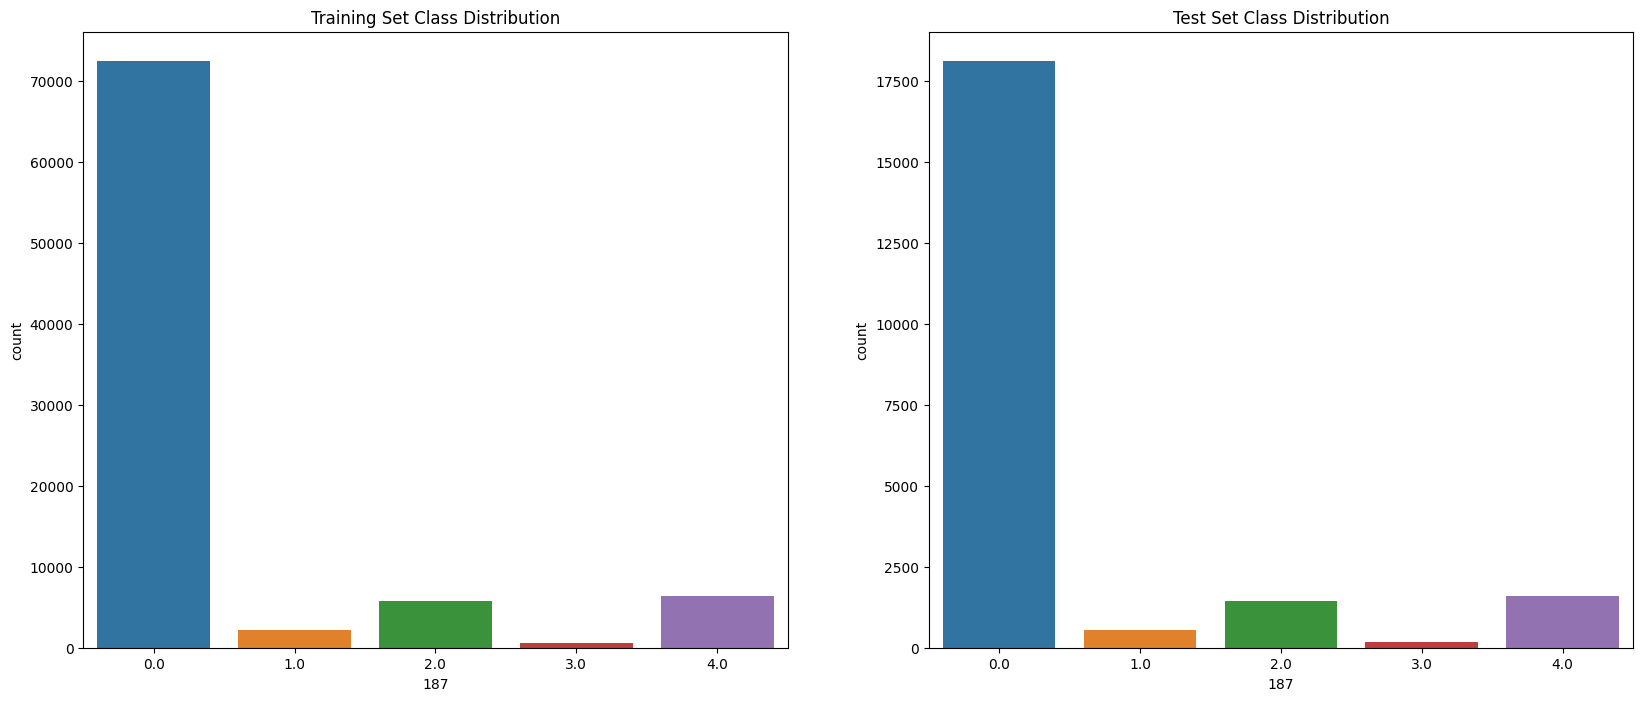

In [ ]:
# Analyze class balance MIT-BIH

fig, axs = plt.subplots(1, 2, figsize=(20, 8))
sns.countplot(x=y_mb_train, ax=axs[0])
axs[0].set_title("Training Set Class Distribution")
sns.countplot(x=y_mb_test, ax=axs[1])
axs[1].set_title("Test Set Class Distribution")
plt.show()

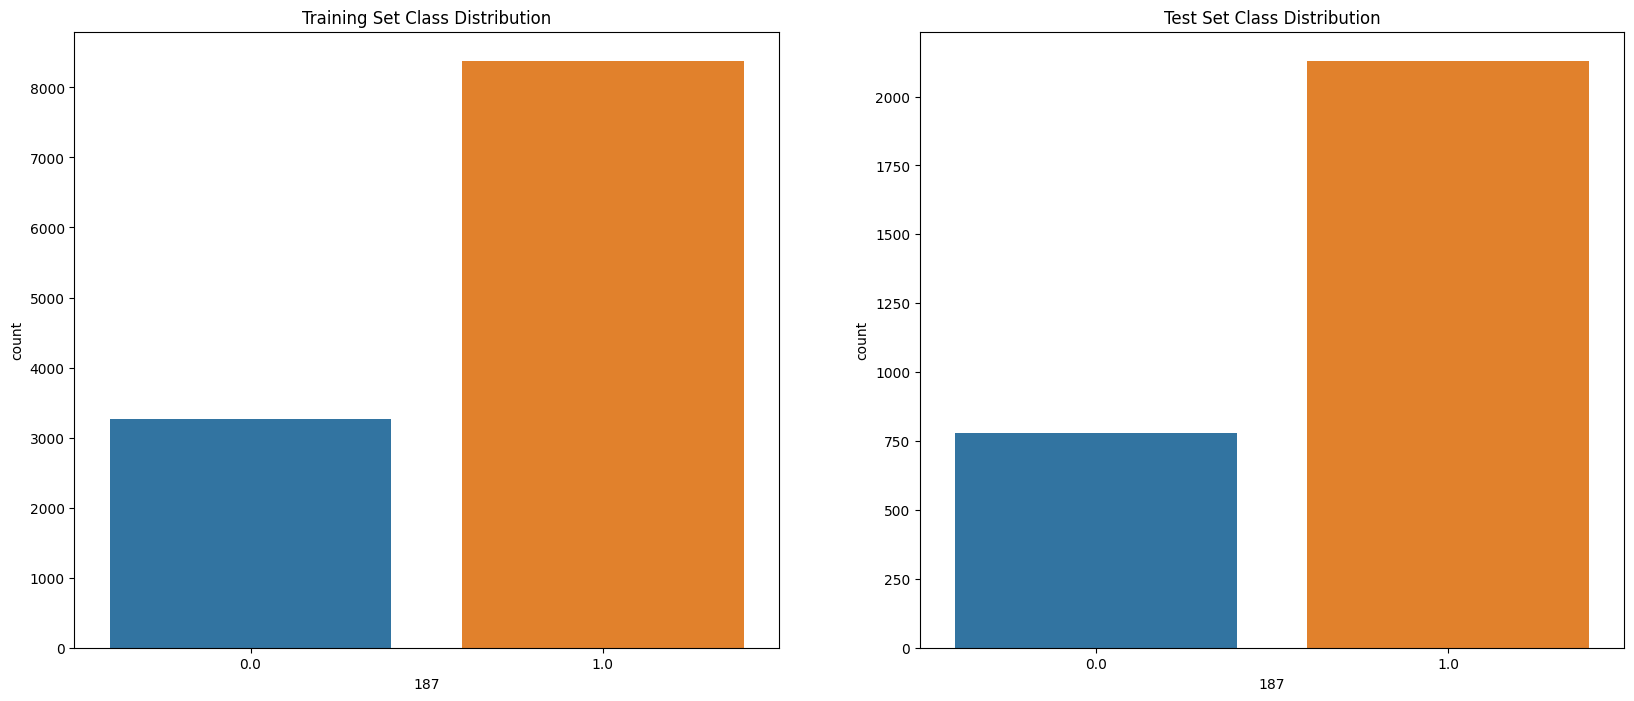

In [ ]:
# Analyze class balance PTB Diagnostic ECG

fig, axs = plt.subplots(1, 2, figsize=(20, 8))
sns.countplot(x=y_pt_train, ax=axs[0])
axs[0].set_title("Training Set Class Distribution")
sns.countplot(x=y_pt_test, ax=axs[1])
axs[1].set_title("Test Set Class Distribution")
plt.show()

## 2. Vizualizarea seriilor de timp

    Afișați câte un exemplu de serie pentru fiecare categorie de aritmie (din seturile de date MIT-BIH / PTB )

MIT-BIH

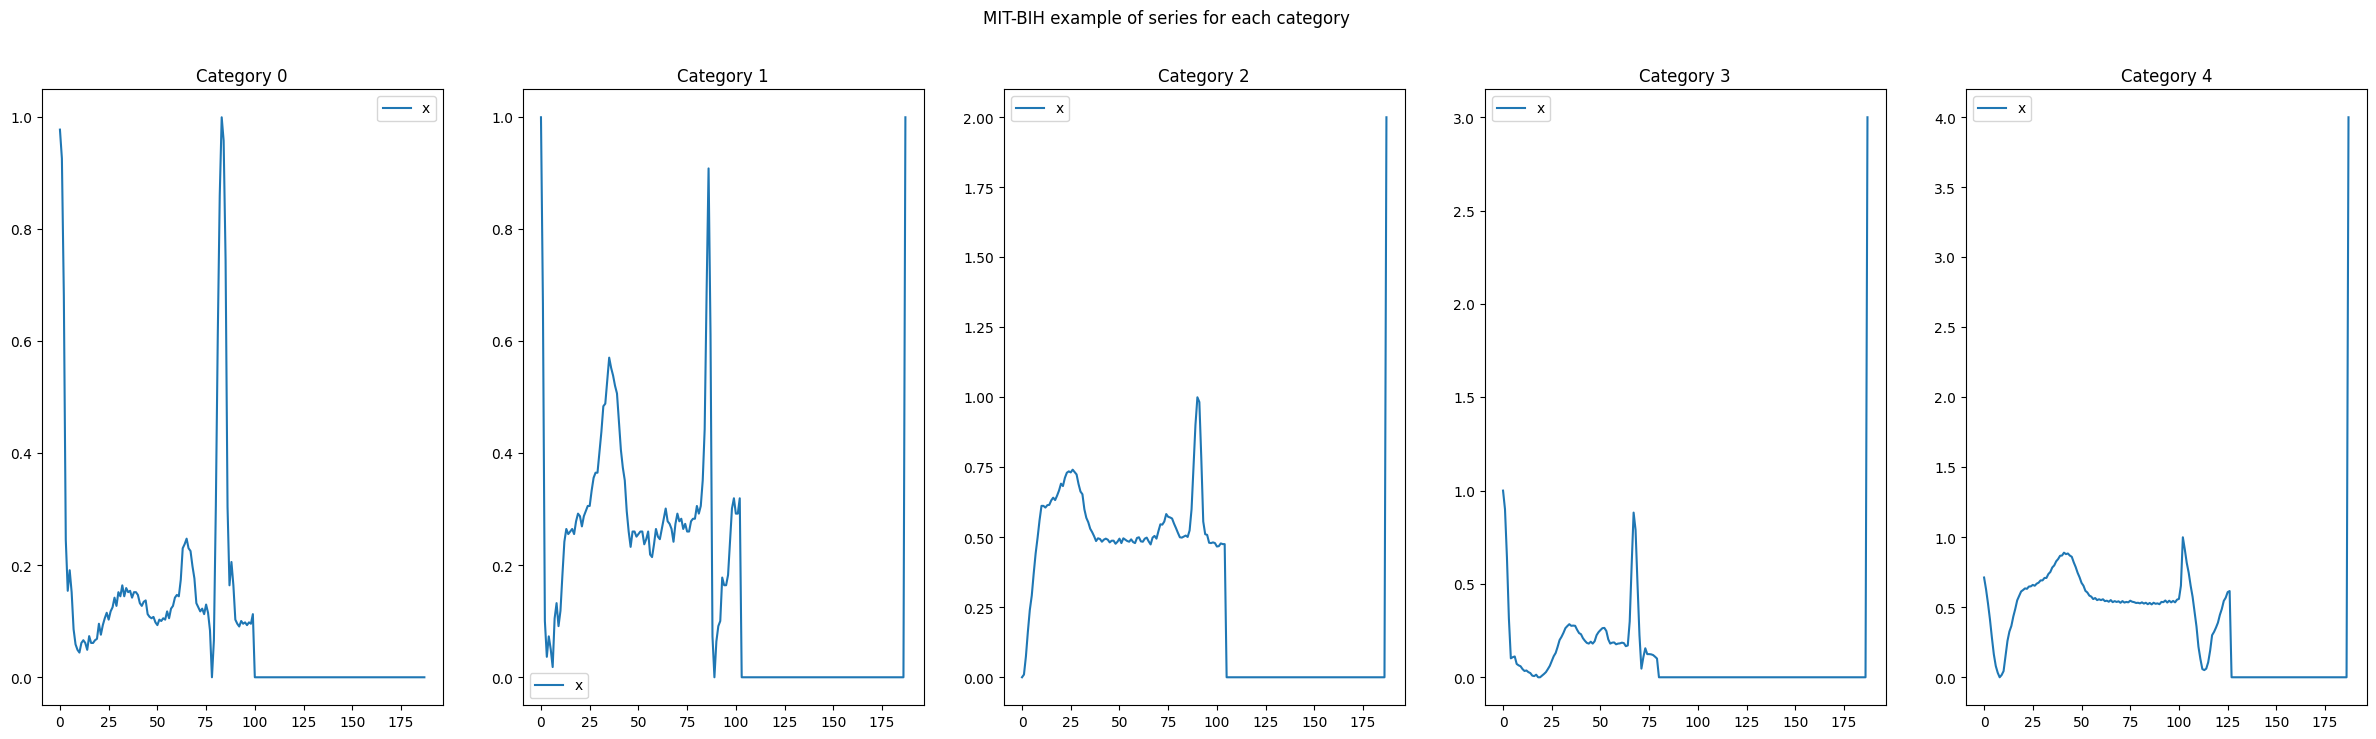

In [ ]:
# Visualize the time series MIT-BIH

def plot_time_series(X, y, title):
    fig, axs = plt.subplots(1, 5, figsize=(30, 8))
    for i in range(5):
        ax = axs[i]
        idx = np.where(y == float(i))[0][0]
        x_vals = X.iloc[idx].values
        t_vals = np.arange(len(x_vals))
        ax.plot(t_vals, x_vals, label="x")
        ax.set_title(f"Category {i}")
        ax.legend()
    fig.suptitle(title)
    plt.show()

# Plot the time series
plot_time_series(X_mb_train, y_mb_train, "MIT-BIH example of series for each category")

PTB Diagnostic ECG

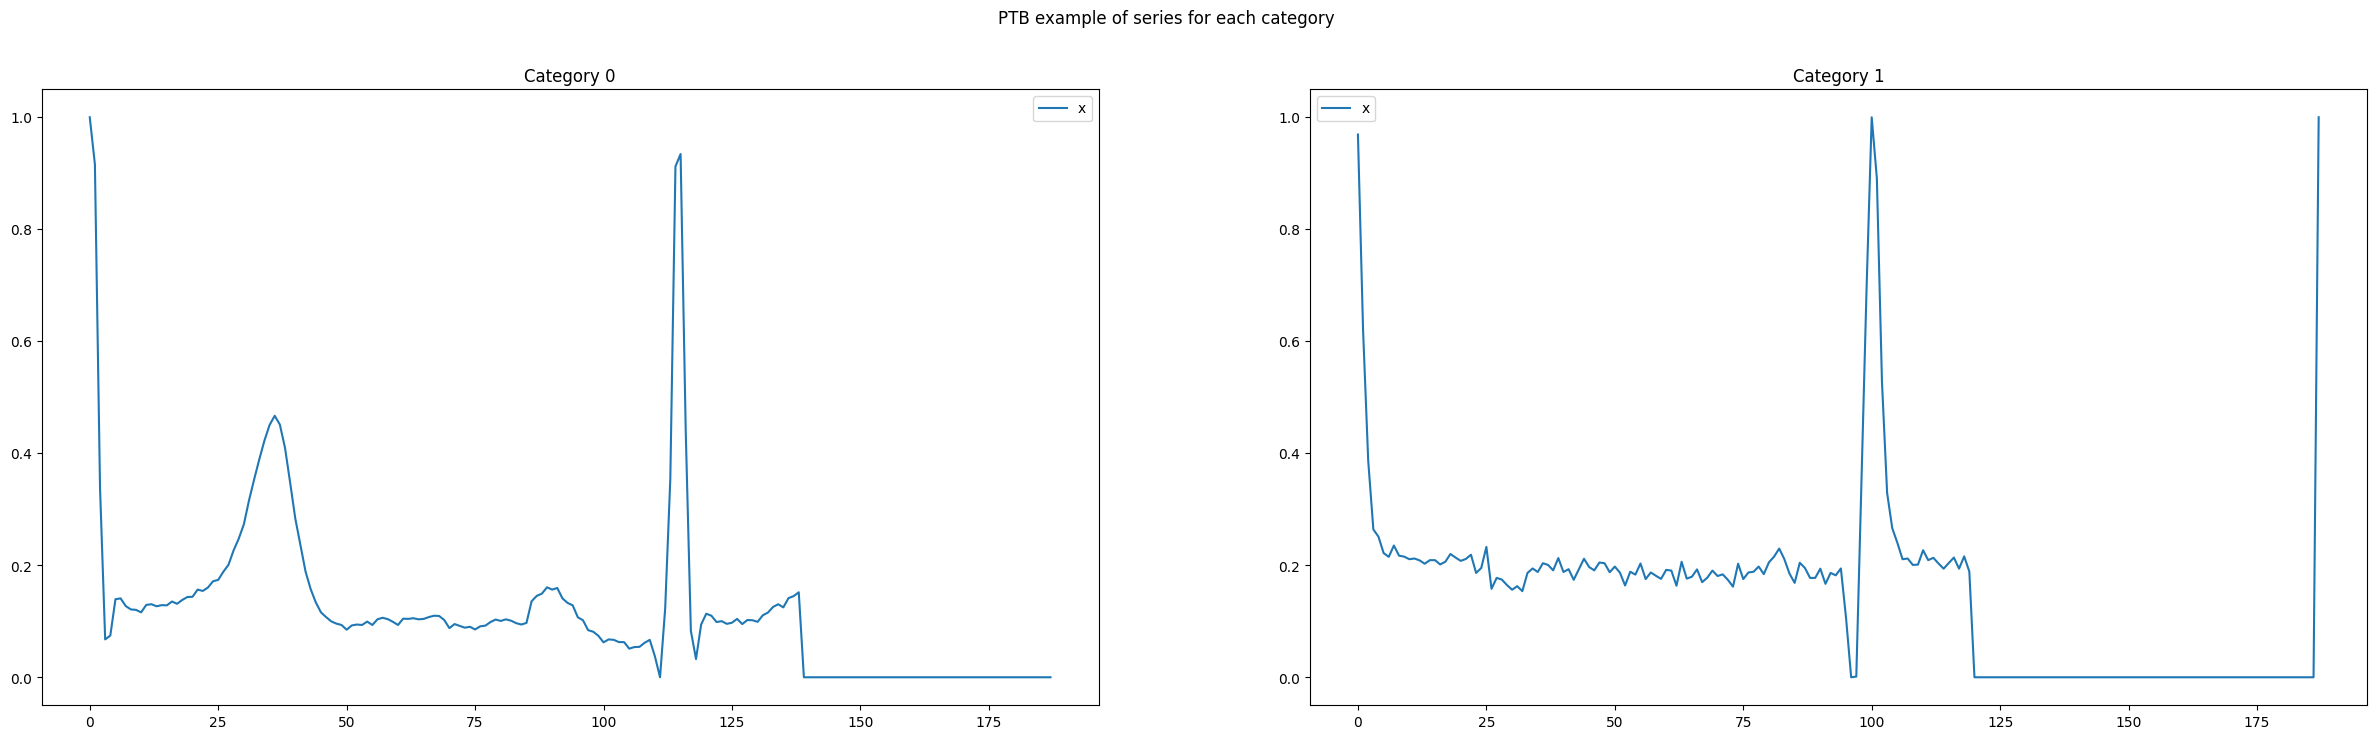

In [ ]:
# Visualize time series PTB Diagnostic ECG

def plot_time_series(X, y, title):
    fig, axs = plt.subplots(1, 2, figsize=(30, 8))
    for i in range(2):
        ax = axs[i]
        idx = np.where(y == float(i))[0][0]
        x_vals = X.iloc[idx].values
        t_vals = np.arange(len(x_vals))
        ax.plot(t_vals, x_vals, label="x")
        ax.set_title(f"Category {i}")
        ax.legend()
    fig.suptitle(title)
    plt.show()

# Plot the time series
plot_time_series(X_pt_train, y_pt_train, "PTB example of series for each category")

2. Vizualizarea seriilor de timp

    Pentru seturile de date cu aritmii afișați un grafic al mediei și deviației standard per unitate de timp, pentru fiecare clasă de aritmie. Media și deviația standard se calculează peste toate exemplele (atât din train, cât și din train set).

MIT-BIH

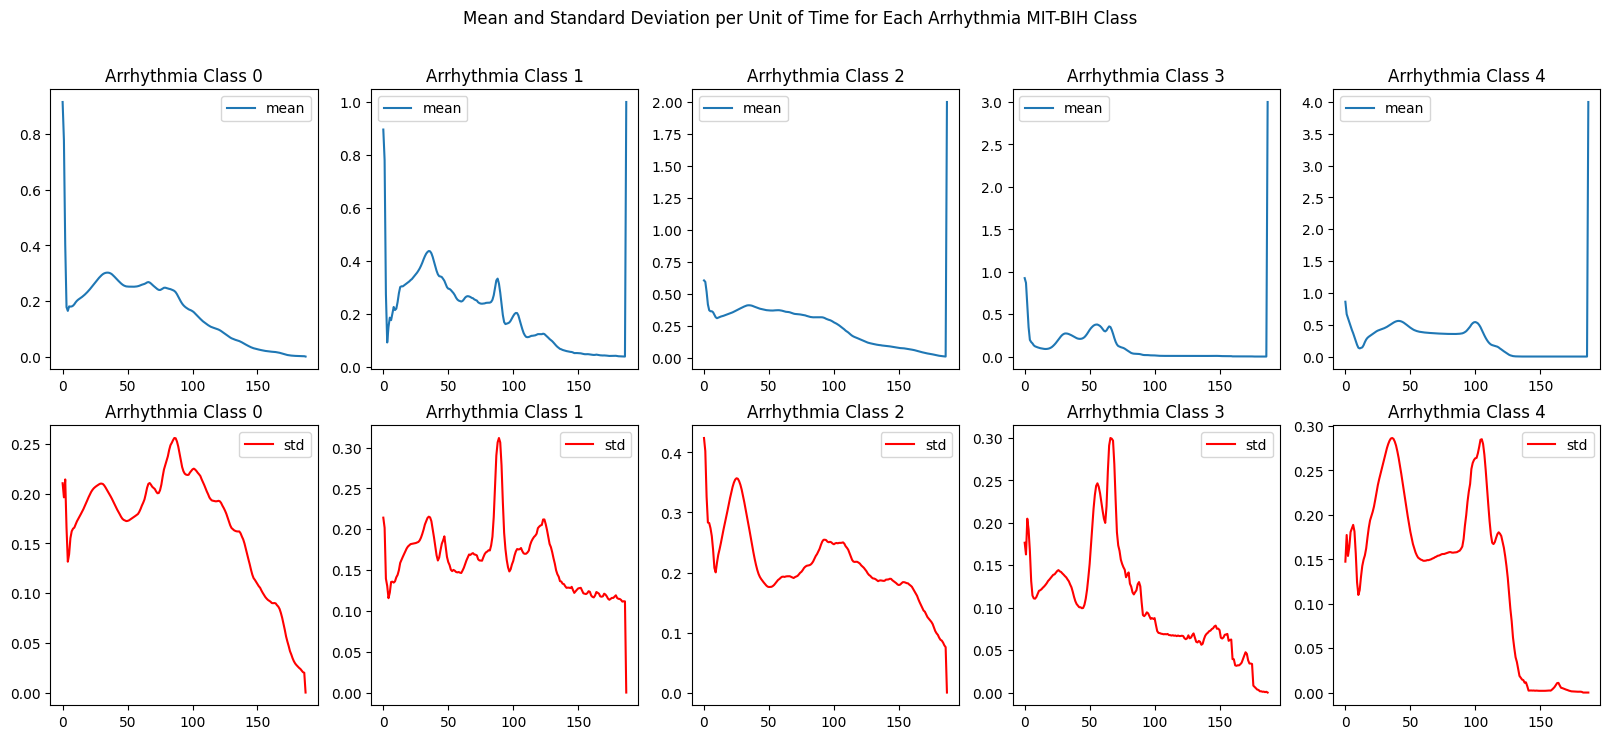

In [ ]:
# Compute mean and standard deviation for each class

X_concatenated = pd.concat([X_mb_train, X_mb_test], ignore_index=True)
Y_concatenated = pd.concat([y_mb_train, y_mb_test], ignore_index=True)

mean_per_class = X_concatenated.groupby(Y_concatenated).mean()
std_per_class = X_concatenated.groupby(Y_concatenated).std()

# Plot mean and standard deviation per unit of time for each class
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(5):
    ax1 = axs[0][i]
    ax2 = axs[1][i]
    mean_vals = mean_per_class.iloc[i].values
    std_vals = std_per_class.iloc[i].values
    t_vals = np.arange(len(mean_vals))
    ax1.plot(t_vals, mean_vals, label="mean")
    ax1.set_title(f"Arrhythmia Class {i}")
    ax1.legend()
    ax2.plot(t_vals, std_vals, label="std", color='red')
    ax2.set_title(f"Arrhythmia Class {i}")
    ax2.legend()
fig.suptitle("Mean and Standard Deviation per Unit of Time for Each Arrhythmia MIT-BIH Class")
plt.show()


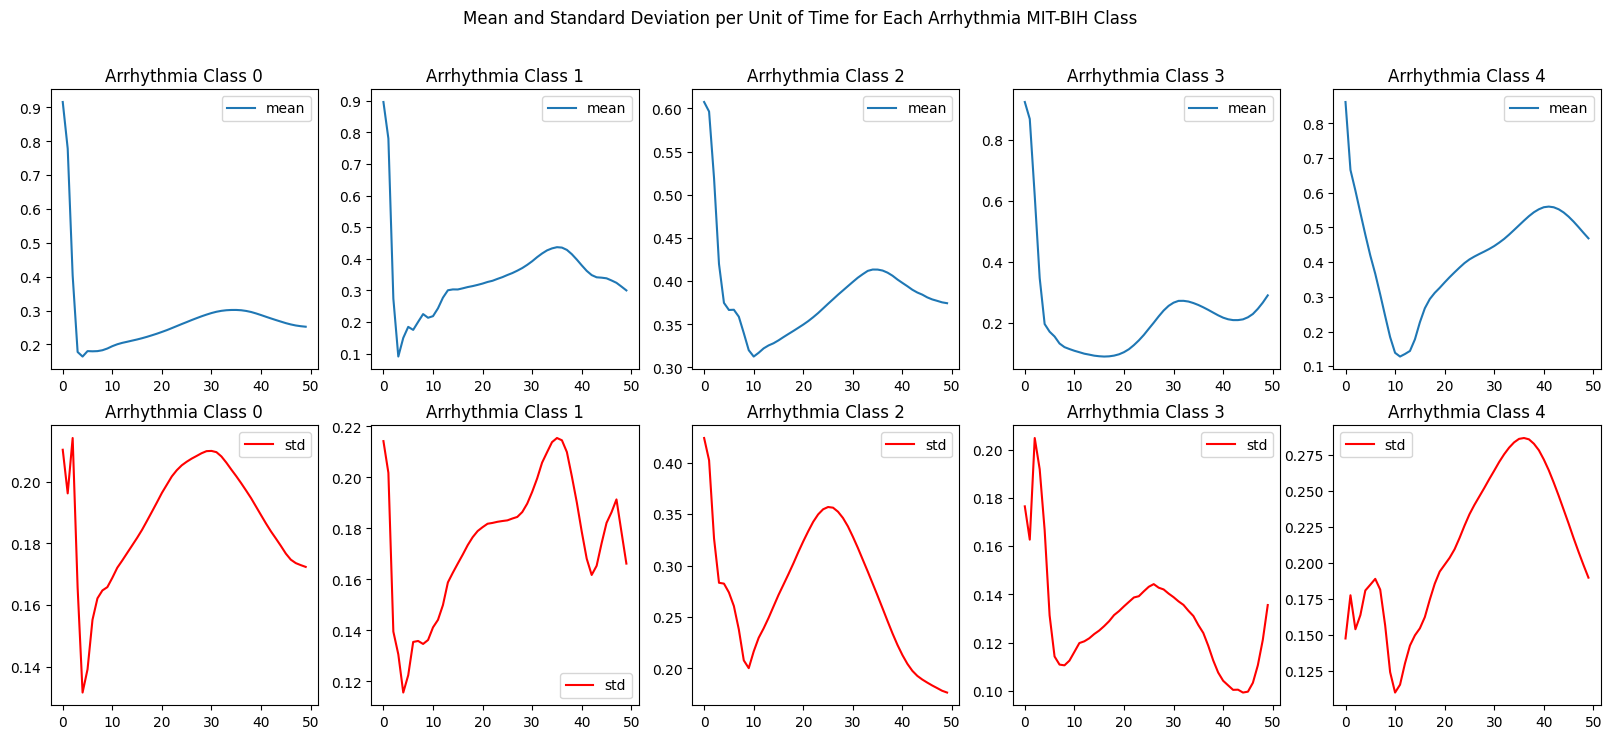

In [ ]:
# Compute mean and standard deviation for each class

X_concatenated = pd.concat([X_mb_train, X_mb_test], ignore_index=True)
Y_concatenated = pd.concat([y_mb_train, y_mb_test], ignore_index=True)

X_concatenated = X_concatenated.drop(X_concatenated.columns[50 :],axis = 1)

mean_per_class = X_concatenated.groupby(Y_concatenated).mean()
std_per_class = X_concatenated.groupby(Y_concatenated).std()

# Plot mean and standard deviation per unit of time for each class
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(5):
    ax1 = axs[0][i]
    ax2 = axs[1][i]
    mean_vals = mean_per_class.iloc[i].values
    std_vals = std_per_class.iloc[i].values
    t_vals = np.arange(len(mean_vals))
    ax1.plot(t_vals, mean_vals, label="mean")
    ax1.set_title(f"Arrhythmia Class {i}")
    ax1.legend()
    ax2.plot(t_vals, std_vals, label="std", color='red')
    ax2.set_title(f"Arrhythmia Class {i}")
    ax2.legend()
fig.suptitle("Mean and Standard Deviation per Unit of Time for Each Arrhythmia MIT-BIH Class")
plt.show()

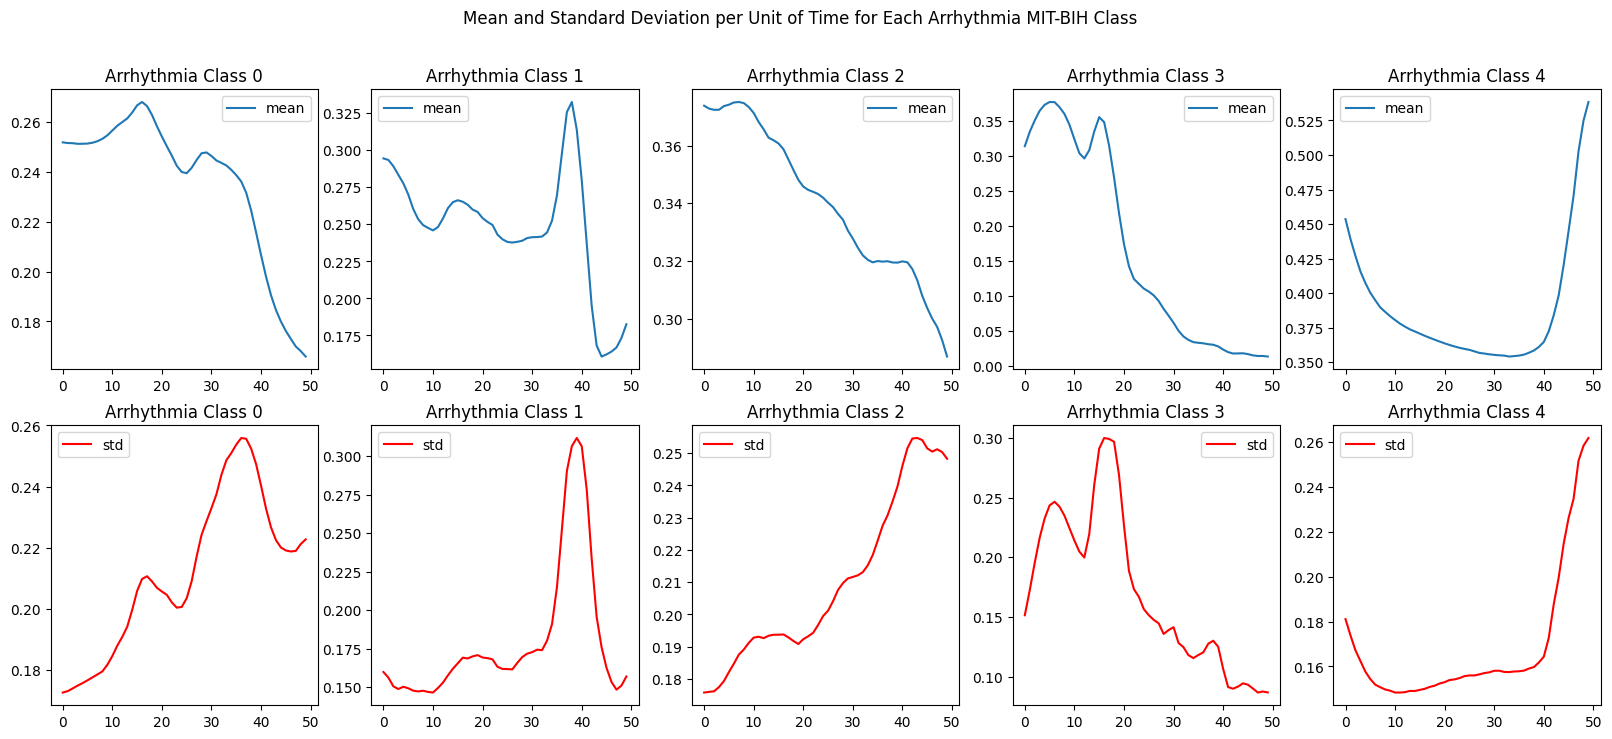

In [ ]:
# Compute mean and standard deviation for each class

X_concatenated = pd.concat([X_mb_train, X_mb_test], ignore_index=True)
Y_concatenated = pd.concat([y_mb_train, y_mb_test], ignore_index=True)

X_concatenated = X_concatenated.drop(X_concatenated.columns[: 50],axis = 1)
X_concatenated = X_concatenated.drop(X_concatenated.columns[50 :],axis = 1)

mean_per_class = X_concatenated.groupby(Y_concatenated).mean()
std_per_class = X_concatenated.groupby(Y_concatenated).std()

# Plot mean and standard deviation per unit of time for each class
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(5):
    ax1 = axs[0][i]
    ax2 = axs[1][i]
    mean_vals = mean_per_class.iloc[i].values
    std_vals = std_per_class.iloc[i].values
    t_vals = np.arange(len(mean_vals))
    ax1.plot(t_vals, mean_vals, label="mean")
    ax1.set_title(f"Arrhythmia Class {i}")
    ax1.legend()
    ax2.plot(t_vals, std_vals, label="std", color='red')
    ax2.set_title(f"Arrhythmia Class {i}")
    ax2.legend()
fig.suptitle("Mean and Standard Deviation per Unit of Time for Each Arrhythmia MIT-BIH Class")
plt.show()


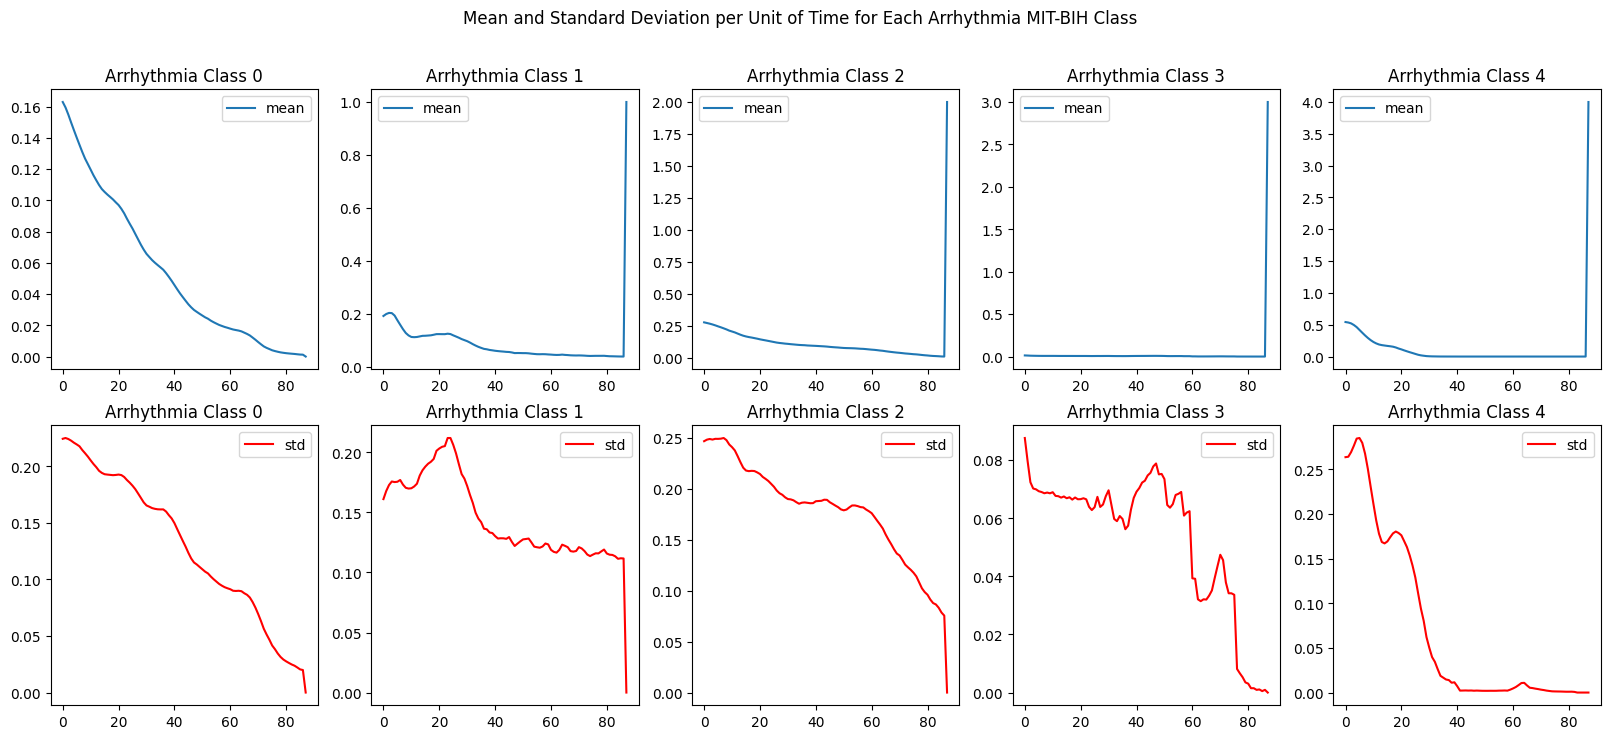

In [ ]:
# Compute mean and standard deviation for each class

X_concatenated = pd.concat([X_mb_train, X_mb_test], ignore_index=True)
Y_concatenated = pd.concat([y_mb_train, y_mb_test], ignore_index=True)

X_concatenated = X_concatenated.drop(X_concatenated.columns[: 100],axis = 1)

mean_per_class = X_concatenated.groupby(Y_concatenated).mean()
std_per_class = X_concatenated.groupby(Y_concatenated).std()

# Plot mean and standard deviation per unit of time for each class
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(5):
    ax1 = axs[0][i]
    ax2 = axs[1][i]
    mean_vals = mean_per_class.iloc[i].values
    std_vals = std_per_class.iloc[i].values
    t_vals = np.arange(len(mean_vals))
    ax1.plot(t_vals, mean_vals, label="mean")
    ax1.set_title(f"Arrhythmia Class {i}")
    ax1.legend()
    ax2.plot(t_vals, std_vals, label="std", color='red')
    ax2.set_title(f"Arrhythmia Class {i}")
    ax2.legend()
fig.suptitle("Mean and Standard Deviation per Unit of Time for Each Arrhythmia MIT-BIH Class")
plt.show()


PTB Diagnostic ECG

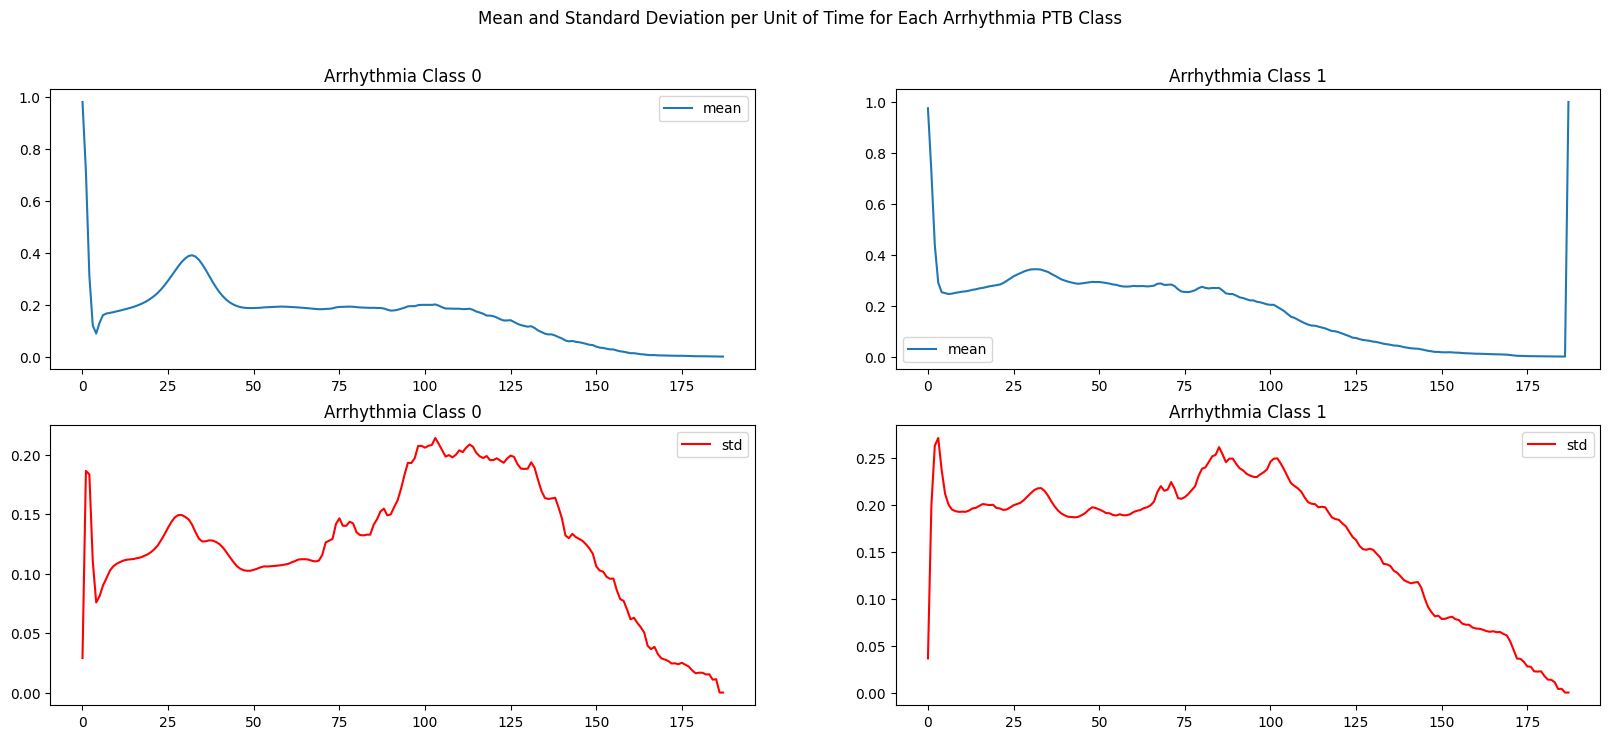

In [ ]:
# Compute mean and standard deviation for each class

X_concatenated = pd.concat([X_pt_train, X_pt_test], ignore_index=True)
Y_concatenated = pd.concat([y_pt_train, y_pt_test], ignore_index=True)

mean_per_class = X_concatenated.groupby(Y_concatenated).mean()
std_per_class = X_concatenated.groupby(Y_concatenated).std()

# Plot mean and standard deviation per unit of time for each class
fig, axs = plt.subplots(2, 2, figsize=(20, 8))
for i in range(2):
    ax1 = axs[0][i]
    ax2 = axs[1][i]
    mean_vals = mean_per_class.iloc[i].values
    std_vals = std_per_class.iloc[i].values
    t_vals = np.arange(len(mean_vals))
    ax1.plot(t_vals, mean_vals, label="mean")
    ax1.set_title(f"Arrhythmia Class {i}")
    ax1.legend()
    ax2.plot(t_vals, std_vals, label="std", color='red')
    ax2.set_title(f"Arrhythmia Class {i}")
    ax2.legend()
fig.suptitle("Mean and Standard Deviation per Unit of Time for Each Arrhythmia PTB Class")
plt.show()

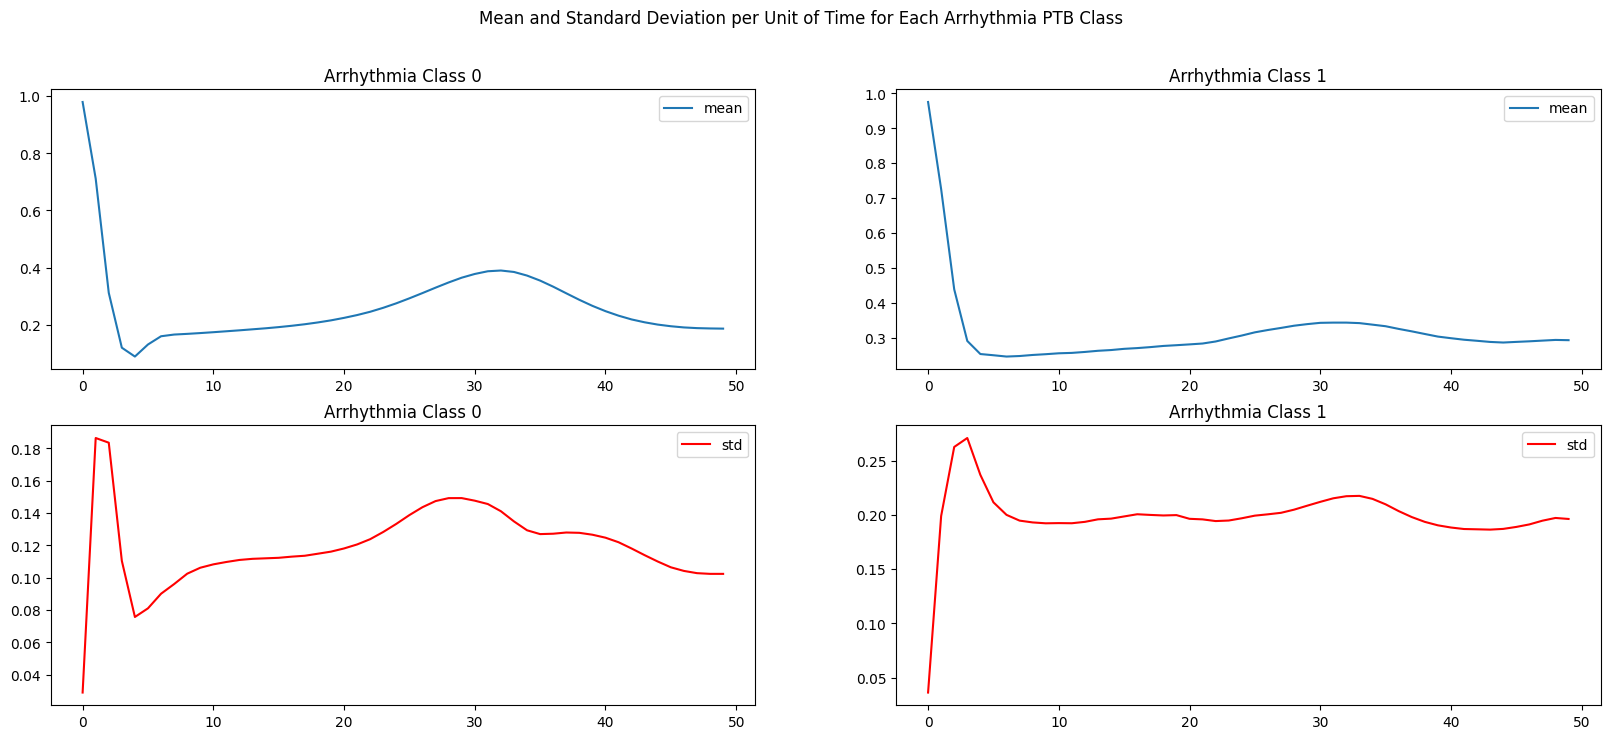

In [ ]:
# Compute mean and standard deviation for each class

X_concatenated = pd.concat([X_pt_train, X_pt_test], ignore_index=True)
Y_concatenated = pd.concat([y_pt_train, y_pt_test], ignore_index=True)

X_concatenated = X_concatenated.drop(X_concatenated.columns[50 : ], axis = 1)

mean_per_class = X_concatenated.groupby(Y_concatenated).mean()
std_per_class = X_concatenated.groupby(Y_concatenated).std()

# Plot mean and standard deviation per unit of time for each class
fig, axs = plt.subplots(2, 2, figsize=(20, 8))
for i in range(2):
    ax1 = axs[0][i]
    ax2 = axs[1][i]
    mean_vals = mean_per_class.iloc[i].values
    std_vals = std_per_class.iloc[i].values
    t_vals = np.arange(len(mean_vals))
    ax1.plot(t_vals, mean_vals, label="mean")
    ax1.set_title(f"Arrhythmia Class {i}")
    ax1.legend()
    ax2.plot(t_vals, std_vals, label="std", color='red')
    ax2.set_title(f"Arrhythmia Class {i}")
    ax2.legend()
fig.suptitle("Mean and Standard Deviation per Unit of Time for Each Arrhythmia PTB Class")
plt.show()


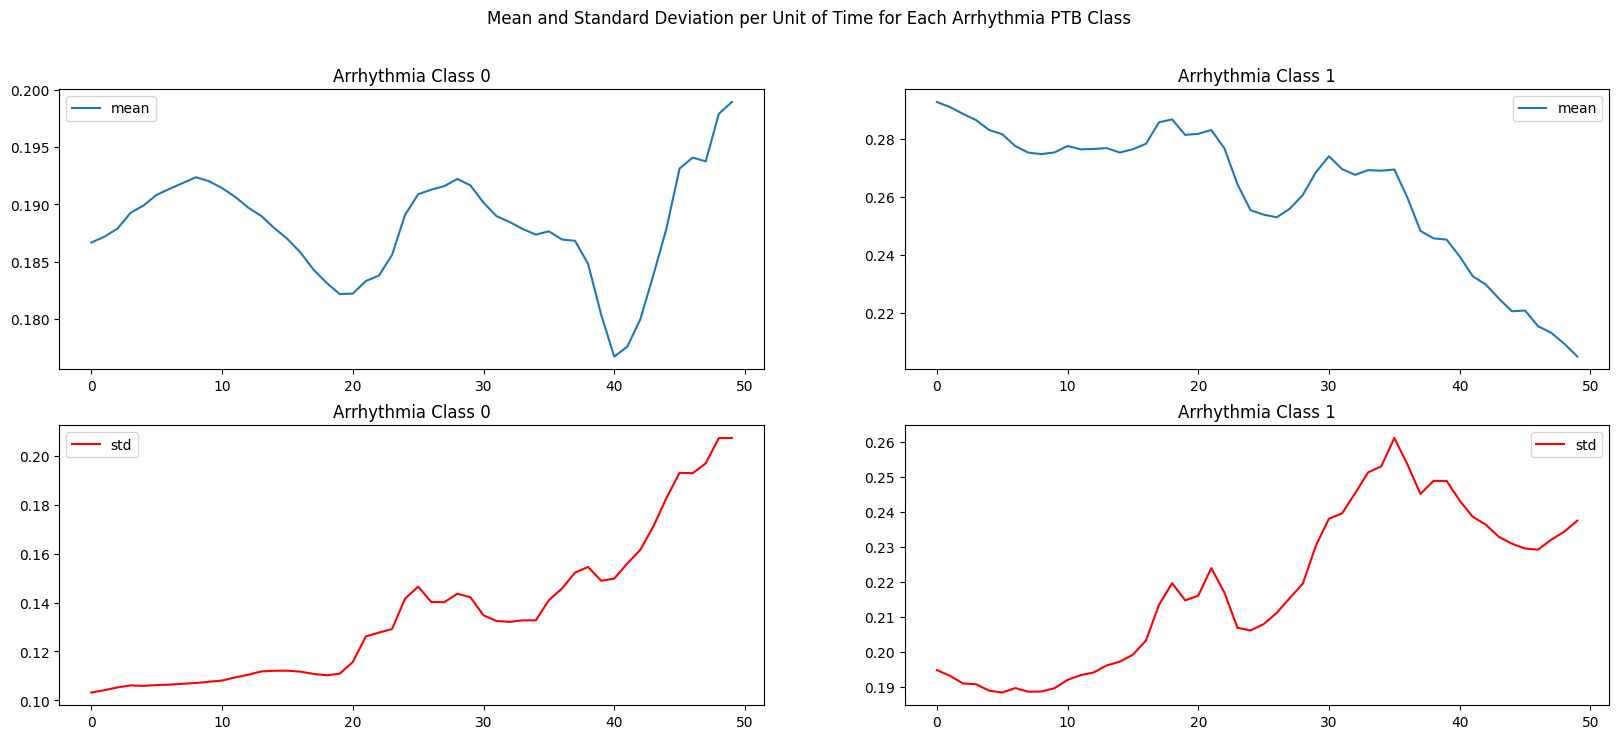

In [ ]:
# Compute mean and standard deviation for each class

X_concatenated = pd.concat([X_pt_train, X_pt_test], ignore_index=True)
Y_concatenated = pd.concat([y_pt_train, y_pt_test], ignore_index=True)

X_concatenated = X_concatenated.drop(X_concatenated.columns[: 50], axis = 1)
X_concatenated = X_concatenated.drop(X_concatenated.columns[50 :], axis = 1)

mean_per_class = X_concatenated.groupby(Y_concatenated).mean()
std_per_class = X_concatenated.groupby(Y_concatenated).std()

# Plot mean and standard deviation per unit of time for each class
fig, axs = plt.subplots(2, 2, figsize=(20, 8))
for i in range(2):
    ax1 = axs[0][i]
    ax2 = axs[1][i]
    mean_vals = mean_per_class.iloc[i].values
    std_vals = std_per_class.iloc[i].values
    t_vals = np.arange(len(mean_vals))
    ax1.plot(t_vals, mean_vals, label="mean")
    ax1.set_title(f"Arrhythmia Class {i}")
    ax1.legend()
    ax2.plot(t_vals, std_vals, label="std", color='red')
    ax2.set_title(f"Arrhythmia Class {i}")
    ax2.legend()
fig.suptitle("Mean and Standard Deviation per Unit of Time for Each Arrhythmia PTB Class")
plt.show()


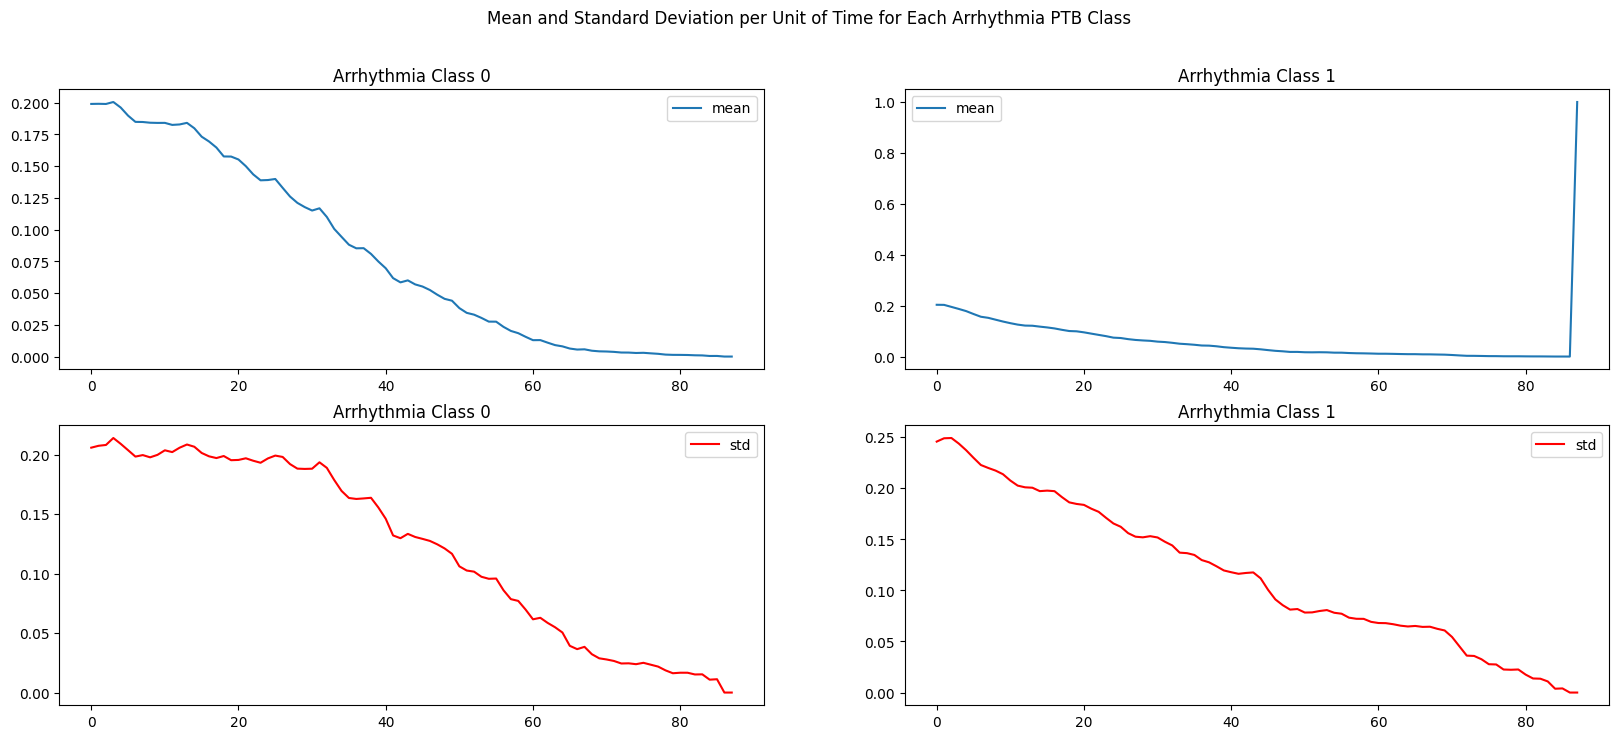

In [ ]:
# Compute mean and standard deviation for each class

X_concatenated = pd.concat([X_pt_train, X_pt_test], ignore_index=True)
Y_concatenated = pd.concat([y_pt_train, y_pt_test], ignore_index=True)

X_concatenated = X_concatenated.drop(X_concatenated.columns[: 100], axis = 1)

mean_per_class = X_concatenated.groupby(Y_concatenated).mean()
std_per_class = X_concatenated.groupby(Y_concatenated).std()

# Plot mean and standard deviation per unit of time for each class
fig, axs = plt.subplots(2, 2, figsize=(20, 8))
for i in range(2):
    ax1 = axs[0][i]
    ax2 = axs[1][i]
    mean_vals = mean_per_class.iloc[i].values
    std_vals = std_per_class.iloc[i].values
    t_vals = np.arange(len(mean_vals))
    ax1.plot(t_vals, mean_vals, label="mean")
    ax1.set_title(f"Arrhythmia Class {i}")
    ax1.legend()
    ax2.plot(t_vals, std_vals, label="std", color='red')
    ax2.set_title(f"Arrhythmia Class {i}")
    ax2.legend()
fig.suptitle("Mean and Standard Deviation per Unit of Time for Each Arrhythmia PTB Class")
plt.show()


# Utilizarea modelelor de Rețele Neurale [4p]

In [ ]:
# Suppressing warning messages

warnings.filterwarnings('ignore')

In [ ]:
# Drop some columns as the margins are dangerous

print(len(X_mb_train.columns), X_mb_train.columns)

X_pt_train = X_pt_train.drop(X_pt_train.columns[: 5], axis = 1)
X_pt_test = X_pt_test.drop(X_pt_test.columns[: 5], axis = 1)

X_mb_train = X_mb_train.drop(X_mb_train.columns[: 5], axis = 1)
X_mb_test = X_mb_test.drop(X_mb_test.columns[: 5], axis = 1)

print(len(X_mb_train.columns), X_mb_train.columns)

X_pt_train = X_pt_train.drop(X_pt_train.columns[-5 :], axis = 1)
X_pt_test = X_pt_test.drop(X_pt_test.columns[-5 :], axis = 1)

X_mb_train = X_mb_train.drop(X_mb_train.columns[-5 :], axis = 1)
X_mb_test = X_mb_test.drop(X_mb_test.columns[-5 :], axis = 1)

print(len(X_mb_train.columns), X_mb_train.columns)

188 Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,
       ...
           178,     179,     180,     181,     182,     183,     184,     185,
           186, 'label'],
      dtype='object', length=188)
183 Index([      5,       6,       7,       8,       9,      10,      11,      12,
            13,      14,
       ...
           178,     179,     180,     181,     182,     183,     184,     185,
           186, 'label'],
      dtype='object', length=183)
178 Index([  5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
       ...
       173, 174, 175, 176, 177, 178, 179, 180, 181, 182],
      dtype='object', length=178)


## Rezolvarea cerintelor - MIT-BIH

In [ ]:
# Scale the data

X_mb_train = MinMaxScaler().fit_transform(X_mb_train)
X_mb_test = MinMaxScaler().fit_transform(X_mb_test)

In [ ]:
X_mb_train

array([[0.19117647, 0.15196079, 0.08578432, ..., 0.        , 0.        ,
        0.        ],
       [0.12535612, 0.0997151 , 0.08831909, ..., 0.        , 0.        ,
        0.        ],
       [0.05945946, 0.05675676, 0.04324324, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.48163265, 0.44489795, 0.3877551 , ..., 0.        , 0.        ,
        0.        ],
       [0.13164558, 0.12151898, 0.12151898, ..., 0.        , 0.        ,
        0.        ],
       [0.59907299, 0.51216686, 0.42757821, ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
X_mb_test

array([[0.0785124 , 0.0661157 , 0.04958678, ..., 0.        , 0.        ,
        0.        ],
       [0.34432235, 0.33333334, 0.30769232, ..., 0.        , 0.        ,
        0.        ],
       [0.10176991, 0.11061947, 0.1238938 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.08902077, 0.10385757, 0.1008902 , ..., 0.        , 0.        ,
        0.        ],
       [0.57539684, 0.57539684, 0.48809522, ..., 0.        , 0.        ,
        0.        ],
       [0.64208245, 0.54772234, 0.4262473 , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
y_mb_train

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
87549    4.0
87550    4.0
87551    4.0
87552    4.0
87553    4.0
Name: 187, Length: 87554, dtype: float64

In [ ]:
y_mb_test

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
21887    4.0
21888    4.0
21889    4.0
21890    4.0
21891    4.0
Name: 187, Length: 21892, dtype: float64

### **Algoritmi propuși și evaluarea acestora [2p]**

NOTA! Veți aplica modele de rețele neurale pe seturile de date cu aritmii ale
bătăilor de inimă (MIT-BIH și PBT).

Sunt propuse spre evaluare următoarele arhitecturi de rețele neurale:

● Arhitectură de tip MLP (Multi-Layered Perceptron) care primește ca intrare întreaga secvență a unei bătăi de inimă [1p]

  ○ Experimentați cu numărul de straturi și dimensiunea acestora

● Arhitectură de tip convoluțională, folosind straturi de convoluții 1D și global average pooling [1.5p]

  ○ Puteți genera propria voastră arhitectură explorând:

■ Numărul de straturi de convoluție și dimensiunea canalelor (channels)
a fiecăruia

■ Combinarea cu straturi liniare pentru partea finală a rețelei

■ Exemple de tutoriale găsiți aici și aici.

  ○ Puteți folosi o arhitectură dată, InceptionTime, care utilizează straturi
convoluționale 1D adaptând arhitectura Inception (definită pentru imagini) pe
cazul seriilor de timp.

■ Implementare în Pytorch pentru InceptionTime

■ Impelemtare în Keras pentru InceptionTme

■ Sugestii:

● Folosiți 1 modul de Inception (în loc de default-ul de 2 din
paper)

● Variați dimensiunea kernelelor de convoluție

● O arhitectură de tip recurent (LSTM sau BiLSTM) [1.5p]

○ Exemplu de tutorial (folosiți doar partea de LSTM)

○ Sugestii:

■ Variați numărul de celule LSTM folosite (e.g. 1 sau 2)

■ Variați dimensiunea hidden size-ului din celula LSTM

■ Variați între un strat LSTM și BiLSTM (LSTM bidirecțional)

NOTĂ: datele pe care le aveți la antrenare sunt relativ puține din punct de vedere numeric.

Luați în considerare (a se observa și în tutorialele referențiate) utilizarea metodelor de regularizare, e.g. prin utilizarea straturilor de Dropout sau prin utilizarea unui mecanism de weight decay în optimizator (a se vedea detalii aici).

NOTĂ: în afară de arhitectura în sine, performanța unui model neural este influențată și de optimizatorul ales și de parametrizarea acestuia. 

Sugestii:

● Folosiți un optimizator adaptiv (e.g. ADAM) și unul cu rată de învățare (learning rate) configurabilă (e.g. SGD cu momentum și un Learning Rate Scheduler)

● Explorați influență dimensiunii batch-urilor

● Explorați influența numărului de epoci de antrenare


#### Preprocesare

In [ ]:
y_mb_train.values

array([0., 0., 0., ..., 4., 4., 4.])

In [ ]:
# one-hot encode the labels

y_mb_train_encoded = torch.tensor(y_mb_train.values)
y_mb_test_encoded = torch.tensor(y_mb_test.values)

In [ ]:
y_mb_train_encoded

tensor([0., 0., 0.,  ..., 4., 4., 4.], dtype=torch.float64)

In [ ]:
# Get the ont-hot encoding

y_mb_train_encoded = F.one_hot(y_mb_train_encoded.long(), num_classes=5).float()
y_mb_test_encoded = F.one_hot(y_mb_test_encoded.long(), num_classes=5).float()

In [ ]:
y_mb_train_encoded

tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]])

In [ ]:
y_mb_test_encoded

tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]])

In [ ]:
# convert to PyTorch tensors

X_mb_train = torch.tensor(X_mb_train).float()
X_mb_train

tensor([[0.1912, 0.1520, 0.0858,  ..., 0.0000, 0.0000, 0.0000],
        [0.1254, 0.0997, 0.0883,  ..., 0.0000, 0.0000, 0.0000],
        [0.0595, 0.0568, 0.0432,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.4816, 0.4449, 0.3878,  ..., 0.0000, 0.0000, 0.0000],
        [0.1316, 0.1215, 0.1215,  ..., 0.0000, 0.0000, 0.0000],
        [0.5991, 0.5122, 0.4276,  ..., 0.0000, 0.0000, 0.0000]])

In [ ]:
# create a DataLoader for the mini-batches

train_ds = TensorDataset(X_mb_train, y_mb_train_encoded)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

In [ ]:
X_mb_test = torch.tensor(X_mb_test).float()
X_mb_test

tensor([[0.0785, 0.0661, 0.0496,  ..., 0.0000, 0.0000, 0.0000],
        [0.3443, 0.3333, 0.3077,  ..., 0.0000, 0.0000, 0.0000],
        [0.1018, 0.1106, 0.1239,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0890, 0.1039, 0.1009,  ..., 0.0000, 0.0000, 0.0000],
        [0.5754, 0.5754, 0.4881,  ..., 0.0000, 0.0000, 0.0000],
        [0.6421, 0.5477, 0.4262,  ..., 0.0000, 0.0000, 0.0000]])

In [ ]:
# create a DataLoader for the mini-batches

test_ds = TensorDataset(X_mb_test, y_mb_test_encoded)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True)

#### Arhitectură de tip **MLP**

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(178, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 5)
        
    def forward(self, x):
        x = x.view(-1, 178)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        #x = F.softmax(self.fc4(x), dim=1)
        x = self.fc4(x)
        return x

##### Antrenare

Epoch 1, Train Loss: 0.1645, Test Loss: 0.1469
Epoch 2, Train Loss: 0.1122, Test Loss: 0.1143
Epoch 3, Train Loss: 0.1021, Test Loss: 0.1078
Epoch 4, Train Loss: 0.0996, Test Loss: 0.1195
Epoch 5, Train Loss: 0.0969, Test Loss: 0.5201
Epoch 6, Train Loss: 0.1149, Test Loss: 0.2375
Epoch 7, Train Loss: 0.1232, Test Loss: 0.1321
Epoch 8, Train Loss: 0.0999, Test Loss: 0.3772
Epoch 9, Train Loss: 0.1133, Test Loss: 0.1057
Epoch 10, Train Loss: 0.1042, Test Loss: 0.1085


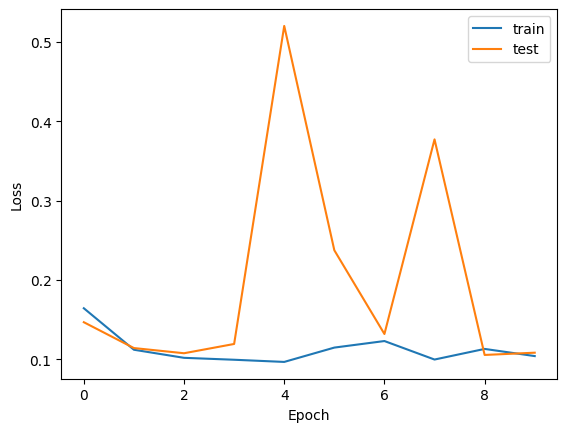

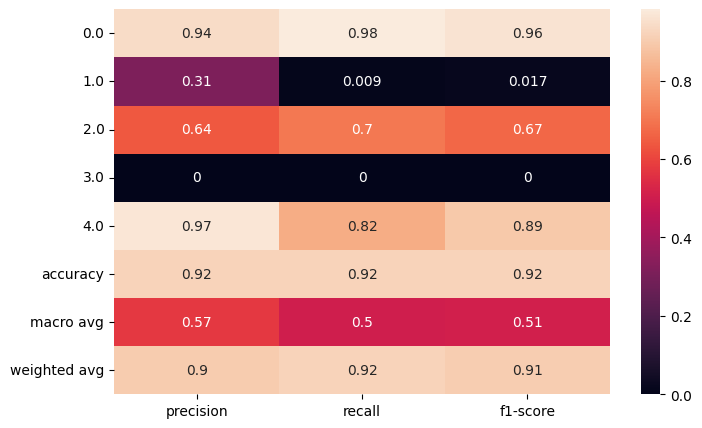

In [ ]:
model = MLP()

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(10):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        yb_pred = model(xb)

        loss = criterion(yb_pred, yb)
        epoch_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model(xb_test)
            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_mb_test = torch.tensor(X_mb_test).float()
y_val_pred = model(X_mb_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_mb_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_mlp = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_mlp).iloc[:-1, :].T, annot=True)
plt.show()

#### Arhitectură de tip **MLP 2.0**

In [ ]:
class MLP2(nn.Module):
    def __init__(self):
        super(MLP2, self).__init__()
        self.fc1 = nn.Linear(178, 128)
        self.fc2 = nn.Linear(128, 64)        
        self.fc3 = nn.Linear(64, 48)        
        self.fc4 = nn.Linear(48, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 5)
        
    def forward(self, x):
        x = x.view(-1, 178)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        #x = F.softmax(self.fc6(x), dim=1)
        return x


##### Antrenare

Epoch 1, Train Loss: 0.1602, Test Loss: 0.1197
Epoch 2, Train Loss: 0.1087, Test Loss: 0.1065
Epoch 3, Train Loss: 0.1018, Test Loss: 0.1299
Epoch 4, Train Loss: 0.0983, Test Loss: 0.0955
Epoch 5, Train Loss: 0.0945, Test Loss: 0.0914
Epoch 6, Train Loss: 0.0925, Test Loss: 0.1014
Epoch 7, Train Loss: 0.0929, Test Loss: 0.0940
Epoch 8, Train Loss: 0.0920, Test Loss: 0.0889
Epoch 9, Train Loss: 0.0911, Test Loss: 0.0943
Epoch 10, Train Loss: 0.0915, Test Loss: 0.0993
Epoch 11, Train Loss: 0.0937, Test Loss: 0.2485
Epoch 12, Train Loss: 0.1018, Test Loss: 0.0961
Epoch 13, Train Loss: 0.0925, Test Loss: 0.1114
Epoch 14, Train Loss: 0.0917, Test Loss: 0.0904
Epoch 15, Train Loss: 0.0900, Test Loss: 0.0907


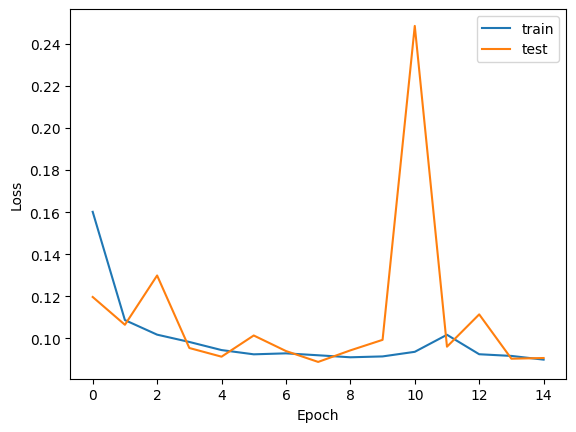

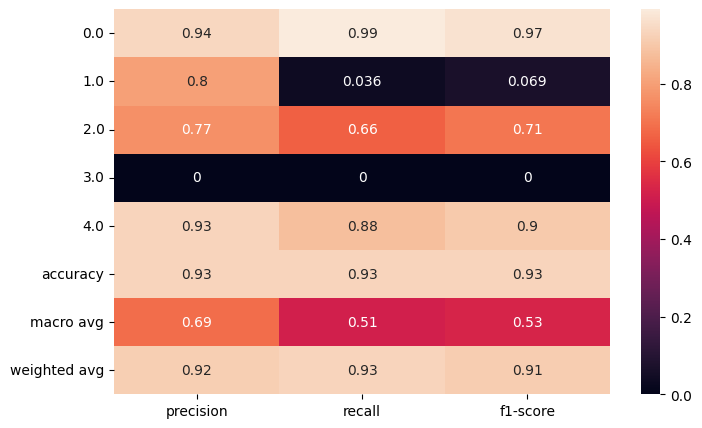

In [ ]:
model = MLP()

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(15):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        yb_pred = model(xb)

        loss = criterion(yb_pred, yb)
        epoch_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model(xb_test)
            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_mb_test = torch.tensor(X_mb_test).float()
y_val_pred = model(X_mb_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_mb_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_mlp = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_mlp).iloc[:-1, :].T, annot=True)
plt.show()

#### Arhitectură de tip **MLP 3.0**

##### Antrenare

Epoch 1, Train Loss: 0.2846, Test Loss: 0.2258
Epoch 2, Train Loss: 0.2258, Test Loss: 0.2248
Epoch 3, Train Loss: 0.2231, Test Loss: 0.2218
Epoch 4, Train Loss: 0.2167, Test Loss: 0.2075
Epoch 5, Train Loss: 0.1946, Test Loss: 0.1868
Epoch 6, Train Loss: 0.1781, Test Loss: 0.1681
Epoch 7, Train Loss: 0.1541, Test Loss: 0.1444
Epoch 8, Train Loss: 0.1366, Test Loss: 0.1316
Epoch 9, Train Loss: 0.1275, Test Loss: 0.1265
Epoch 10, Train Loss: 0.1209, Test Loss: 0.1211
Epoch 11, Train Loss: 0.1169, Test Loss: 0.1165
Epoch 12, Train Loss: 0.1136, Test Loss: 0.1160
Epoch 13, Train Loss: 0.1082, Test Loss: 0.1103
Epoch 14, Train Loss: 0.1067, Test Loss: 0.1104
Epoch 15, Train Loss: 0.1060, Test Loss: 0.1092
Epoch 16, Train Loss: 0.1058, Test Loss: 0.1095
Epoch 17, Train Loss: 0.1053, Test Loss: 0.1081
Epoch 18, Train Loss: 0.1043, Test Loss: 0.1077
Epoch 19, Train Loss: 0.1039, Test Loss: 0.1067
Epoch 20, Train Loss: 0.1039, Test Loss: 0.1067
Epoch 21, Train Loss: 0.1024, Test Loss: 0.1057
E

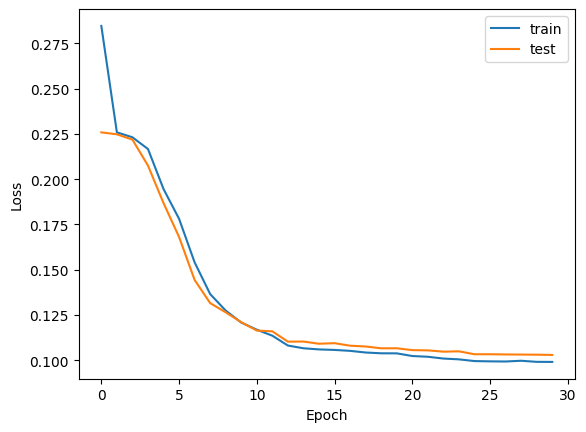

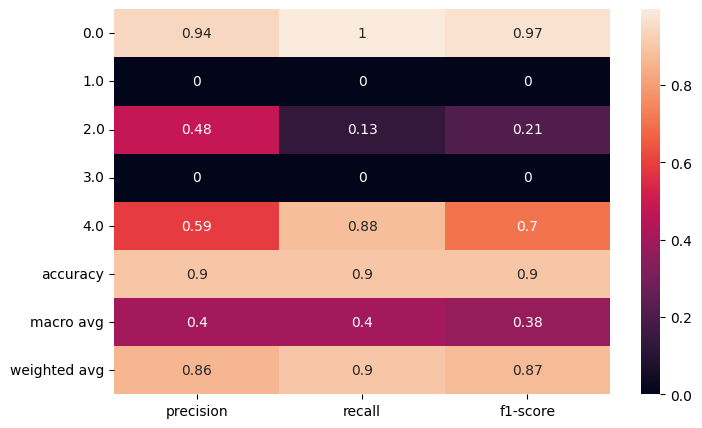

In [ ]:
model = MLP2()

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()

# define the optimizer with SGD and momentum
optimizer = torch.optim.SGD(model.parameters(), lr=0.02, momentum=0.9, weight_decay=0.001)

# define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=12, gamma=0.1)
# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(30):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        yb_pred = model(xb)

        loss = criterion(yb_pred, yb)
        epoch_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    scheduler.step()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model(xb_test)
            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_mb_test = torch.tensor(X_mb_test).float()
y_val_pred = model(X_mb_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_mb_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_mlp = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_mlp).iloc[:-1, :].T, annot=True)
plt.show()

#### Preprocesare

In [ ]:
X_mb_train

tensor([[0.1912, 0.1520, 0.0858,  ..., 0.0000, 0.0000, 0.0000],
        [0.1254, 0.0997, 0.0883,  ..., 0.0000, 0.0000, 0.0000],
        [0.0595, 0.0568, 0.0432,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.4816, 0.4449, 0.3878,  ..., 0.0000, 0.0000, 0.0000],
        [0.1316, 0.1215, 0.1215,  ..., 0.0000, 0.0000, 0.0000],
        [0.5991, 0.5122, 0.4276,  ..., 0.0000, 0.0000, 0.0000]])

In [ ]:
X_train = X_mb_train.unsqueeze(1).float()
X_test = X_mb_test.unsqueeze(1).float()

In [ ]:
print(X_train.size())
print(X_test.size())

torch.Size([87554, 1, 178])
torch.Size([21892, 1, 178])


In [ ]:
train_ds = TensorDataset(X_train, y_mb_train_encoded)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

test_ds = TensorDataset(X_test, y_mb_test_encoded)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True)

In [ ]:
for xb, yb in train_dl:
  print(xb, xb.size(), yb, yb.size())
  break

tensor([[[0.1283, 0.1549, 0.1327,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0244, 0.0111, 0.0111,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.1066, 0.0615, 0.0410,  ..., 0.0000, 0.0000, 0.0000]],

        ...,

        [[0.0799, 0.0954, 0.0979,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.1512, 0.1265, 0.1004,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0940, 0.0769, 0.0342,  ..., 0.0000, 0.0000, 0.0000]]]) torch.Size([32, 1, 178]) tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0.

#### Arhitectură de tip **InceptionTime**

In [ ]:
class Conv1dSamePadding(nn.Conv1d):
    """Represents the "Same" padding functionality from Tensorflow.
    See: https://github.com/pytorch/pytorch/issues/3867
    Note that the padding argument in the initializer doesn't do anything now
    """
    def forward(self, input):
        return conv1d_same_padding(input, self.weight, self.bias, self.stride,
                                   self.dilation, self.groups)


def conv1d_same_padding(input, weight, bias, stride, dilation, groups):
    # stride and dilation are expected to be tuples.
    kernel, dilation, stride = weight.size(2), dilation[0], stride[0]
    l_out = l_in = input.size(2)
    padding = (((l_out - 1) * stride) - l_in + (dilation * (kernel - 1)) + 1)
    if padding % 2 != 0:
        input = F.pad(input, [0, 1])

    return F.conv1d(input=input, weight=weight, bias=bias, stride=stride,
                    padding=padding // 2,
                    dilation=dilation, groups=groups)

class InceptionModel(nn.Module):
    """A PyTorch implementation of the InceptionTime model.
    From https://arxiv.org/abs/1909.04939
    Attributes
    ----------
    num_blocks:
        The number of inception blocks to use. One inception block consists
        of 3 convolutional layers, (optionally) a bottleneck and (optionally) a residual
        connector
    in_channels:
        The number of input channels (i.e. input.shape[-1])
    out_channels:
        The number of "hidden channels" to use. Can be a list (for each block) or an
        int, in which case the same value will be applied to each block
    bottleneck_channels:
        The number of channels to use for the bottleneck. Can be list or int. If 0, no
        bottleneck is applied
    kernel_sizes:
        The size of the kernels to use for each inception block. Within each block, each
        of the 3 convolutional layers will have kernel size
        `[kernel_size // (2 ** i) for i in range(3)]`
    num_pred_classes:
        The number of output classes
    """

    def __init__(self, num_blocks: int, in_channels: int, out_channels: Union[List[int], int],
                 bottleneck_channels: Union[List[int], int], kernel_sizes: Union[List[int], int],
                 use_residuals: Union[List[bool], bool, str] = 'default',
                 num_pred_classes: int = 1
                 ) -> None:
        super().__init__()

        # for easier saving and loading
        self.input_args = {
            'num_blocks': num_blocks,
            'in_channels': in_channels,
            'out_channels': out_channels,
            'bottleneck_channels': bottleneck_channels,
            'kernel_sizes': kernel_sizes,
            'use_residuals': use_residuals,
            'num_pred_classes': num_pred_classes
        }

        channels = [in_channels] + cast(List[int], self._expand_to_blocks(out_channels,
                                                                          num_blocks))
        bottleneck_channels = cast(List[int], self._expand_to_blocks(bottleneck_channels,
                                                                     num_blocks))
        kernel_sizes = cast(List[int], self._expand_to_blocks(kernel_sizes, num_blocks))
        if use_residuals == 'default':
            use_residuals = [True if i % 3 == 2 else False for i in range(num_blocks)]
        use_residuals = cast(List[bool], self._expand_to_blocks(
            cast(Union[bool, List[bool]], use_residuals), num_blocks)
        )

        self.blocks = nn.Sequential(*[
            InceptionBlock(in_channels=channels[i], out_channels=channels[i + 1],
                           residual=use_residuals[i], bottleneck_channels=bottleneck_channels[i],
                           kernel_size=kernel_sizes[i]) for i in range(num_blocks)
        ])

        # a global average pooling (i.e. mean of the time dimension) is why
        # in_features=channels[-1]
        self.linear = nn.Linear(in_features=channels[-1], out_features=num_pred_classes)

    @staticmethod
    def _expand_to_blocks(value: Union[int, bool, List[int], List[bool]],
                          num_blocks: int) -> Union[List[int], List[bool]]:
        if isinstance(value, list):
            assert len(value) == num_blocks, \
                f'Length of inputs lists must be the same as num blocks, ' \
                f'expected length {num_blocks}, got {len(value)}'
        else:
            value = [value] * num_blocks
        return value

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore
        x = self.blocks(x).mean(dim=-1)  # the mean is the global average pooling
        return self.linear(x)


class InceptionBlock(nn.Module):
    """An inception block consists of an (optional) bottleneck, followed
    by 3 conv1d layers. Optionally residual
    """

    def __init__(self, in_channels: int, out_channels: int,
                 residual: bool, stride: int = 1, bottleneck_channels: int = 32,
                 kernel_size: int = 41) -> None:
        assert kernel_size > 3, "Kernel size must be strictly greater than 3"
        super().__init__()

        self.use_bottleneck = bottleneck_channels > 0
        if self.use_bottleneck:
            self.bottleneck = Conv1dSamePadding(in_channels, bottleneck_channels,
                                                kernel_size=1, bias=False)
        kernel_size_s = [kernel_size // (2 ** i) for i in range(3)]
        start_channels = bottleneck_channels if self.use_bottleneck else in_channels
        channels = [start_channels] + [out_channels] * 3
        self.conv_layers = nn.Sequential(*[
            Conv1dSamePadding(in_channels=channels[i], out_channels=channels[i + 1],
                              kernel_size=kernel_size_s[i], stride=stride, bias=False)
            for i in range(len(kernel_size_s))
        ])

        self.batchnorm = nn.BatchNorm1d(num_features=channels[-1])
        self.relu = nn.ReLU()

        self.use_residual = residual
        if residual:
            self.residual = nn.Sequential(*[
                Conv1dSamePadding(in_channels=in_channels, out_channels=out_channels,
                                  kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels),
                nn.ReLU()
            ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore
        org_x = x
        if self.use_bottleneck:
            x = self.bottleneck(x)
        x = self.conv_layers(x)

        if self.use_residual:
            x = x + self.residual(org_x)
        return x

##### Antrenare

Epoch 1, Train Loss: 0.2152, Test Loss: 0.1837
Epoch 2, Train Loss: 0.1682, Test Loss: 0.1605
Epoch 3, Train Loss: 0.1496, Test Loss: 0.1443
Epoch 4, Train Loss: 0.1440, Test Loss: 0.1490
Epoch 5, Train Loss: 0.1417, Test Loss: 0.1407


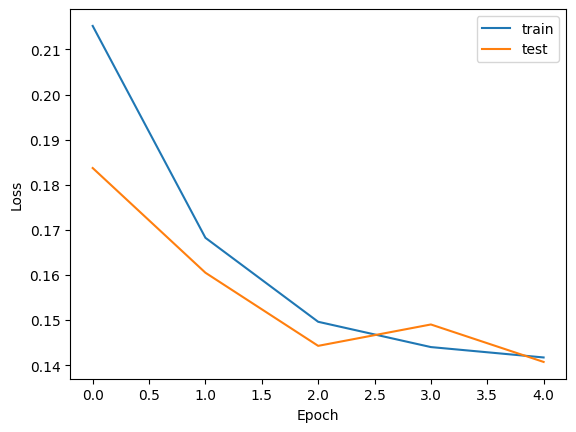

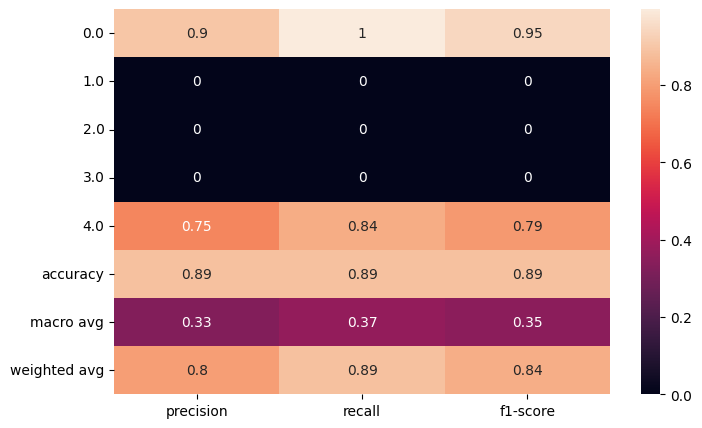

In [ ]:
model = InceptionModel(num_blocks=3, in_channels=1, out_channels=2,
                           bottleneck_channels=2, kernel_sizes=41, use_residuals=True,
                           num_pred_classes=5)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(5):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model(xb_test)
            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_test = torch.tensor(X_test).float()
y_val_pred = model(X_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_mb_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_inception = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_inception).iloc[:-1, :].T, annot=True)
plt.show()

##### Antrenare 2.0

Epoch 1, Train Loss: 0.1388, Test Loss: 0.1010
Epoch 2, Train Loss: 0.0962, Test Loss: 0.0867
Epoch 3, Train Loss: 0.0894, Test Loss: 0.0950
Epoch 4, Train Loss: 0.0857, Test Loss: 0.0814
Epoch 5, Train Loss: 0.0835, Test Loss: 0.0797


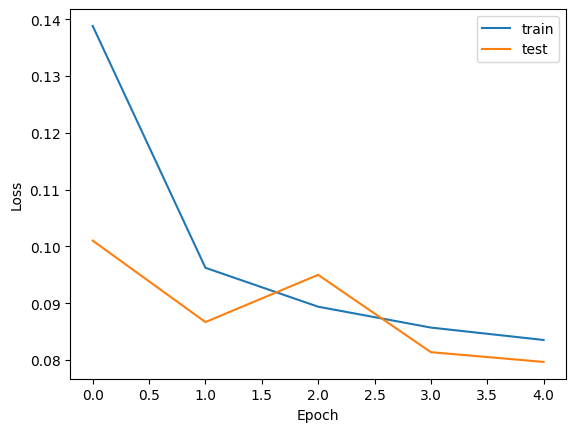

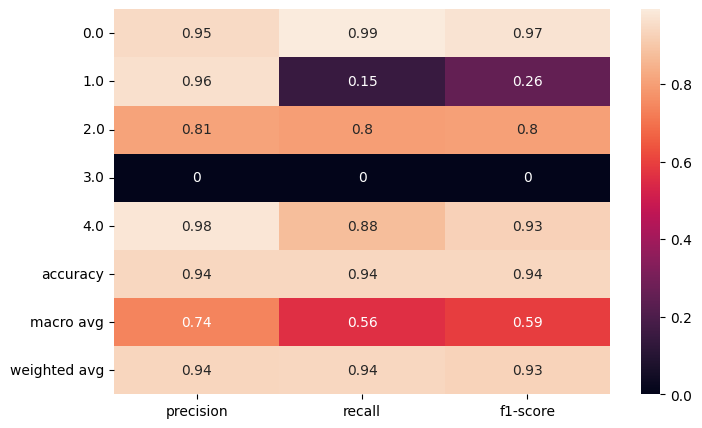

In [ ]:
model2 = InceptionModel(num_blocks=3, in_channels=1, out_channels=8,
                           bottleneck_channels=8, kernel_sizes=61, use_residuals=True,
                           num_pred_classes=5)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001, weight_decay=0.001)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(5):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        optimizer.zero_grad()
        output = model2(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model2(xb_test)
            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_test = torch.tensor(X_test).float()
y_val_pred = model2(X_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_mb_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_inception = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_inception).iloc[:-1, :].T, annot=True)
plt.show()

##### Antrenare 3.0

Epoch 1, Train Loss: 0.1196, Test Loss: 0.0900
Epoch 2, Train Loss: 0.0823, Test Loss: 0.0777
Epoch 3, Train Loss: 0.0766, Test Loss: 0.0762
Epoch 4, Train Loss: 0.0740, Test Loss: 0.0811
Epoch 5, Train Loss: 0.0715, Test Loss: 0.0709
Epoch 6, Train Loss: 0.0694, Test Loss: 0.0699
Epoch 7, Train Loss: 0.0677, Test Loss: 0.0671
Epoch 8, Train Loss: 0.0665, Test Loss: 0.0684
Epoch 9, Train Loss: 0.0654, Test Loss: 0.0645
Epoch 10, Train Loss: 0.0643, Test Loss: 0.0624


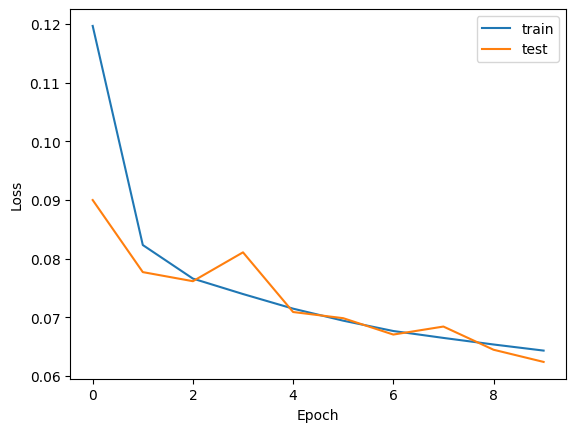

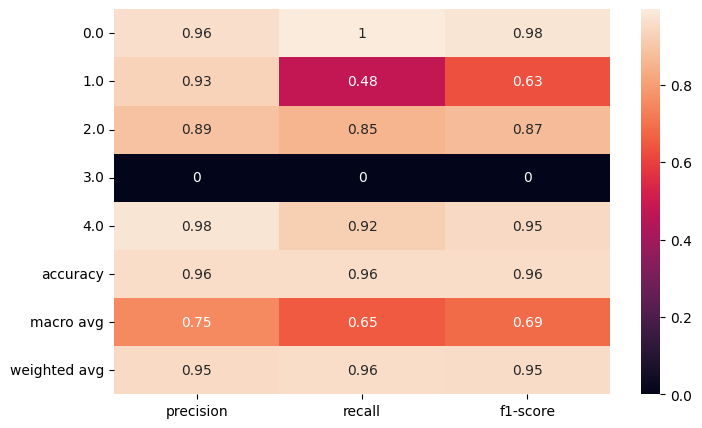

In [ ]:
model3 = InceptionModel(num_blocks=4, in_channels=1, out_channels=8,
                           bottleneck_channels=8, kernel_sizes=61, use_residuals=True,
                           num_pred_classes=5)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001, weight_decay=0.001)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(10):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        optimizer.zero_grad()
        output = model3(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model3(xb_test)
            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_test = torch.tensor(X_test).float()
y_val_pred = model3(X_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_mb_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_inception = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_inception).iloc[:-1, :].T, annot=True)
plt.show()

#### Arhitectură de tip **InceptionTime 2.0**

In [ ]:
class Conv1dSamePadding(nn.Conv1d):
    """Represents the "Same" padding functionality from Tensorflow.
    See: https://github.com/pytorch/pytorch/issues/3867
    Note that the padding argument in the initializer doesn't do anything now
    """
    def forward(self, input):
        return conv1d_same_padding(input, self.weight, self.bias, self.stride,
                                   self.dilation, self.groups)


def conv1d_same_padding(input, weight, bias, stride, dilation, groups):
    # stride and dilation are expected to be tuples.
    kernel, dilation, stride = weight.size(2), dilation[0], stride[0]
    l_out = l_in = input.size(2)
    padding = (((l_out - 1) * stride) - l_in + (dilation * (kernel - 1)) + 1)
    if padding % 2 != 0:
        input = F.pad(input, [0, 1])

    return F.conv1d(input=input, weight=weight, bias=bias, stride=stride,
                    padding=padding // 2,
                    dilation=dilation, groups=groups)

class InceptionModel(nn.Module):
    """A PyTorch implementation of the InceptionTime model.
    From https://arxiv.org/abs/1909.04939
    Attributes
    ----------
    num_blocks:
        The number of inception blocks to use. One inception block consists
        of 3 convolutional layers, (optionally) a bottleneck and (optionally) a residual
        connector
    in_channels:
        The number of input channels (i.e. input.shape[-1])
    out_channels:
        The number of "hidden channels" to use. Can be a list (for each block) or an
        int, in which case the same value will be applied to each block
    bottleneck_channels:
        The number of channels to use for the bottleneck. Can be list or int. If 0, no
        bottleneck is applied
    kernel_sizes:
        The size of the kernels to use for each inception block. Within each block, each
        of the 3 convolutional layers will have kernel size
        `[kernel_size // (2 ** i) for i in range(3)]`
    num_pred_classes:
        The number of output classes
    """

    def __init__(self, num_blocks: int, in_channels: int, out_channels: Union[List[int], int],
                 bottleneck_channels: Union[List[int], int], kernel_sizes: Union[List[int], int],
                 use_residuals: Union[List[bool], bool, str] = 'default',
                 num_pred_classes: int = 1
                 ) -> None:
        super().__init__()

        # for easier saving and loading
        self.input_args = {
            'num_blocks': num_blocks,
            'in_channels': in_channels,
            'out_channels': out_channels,
            'bottleneck_channels': bottleneck_channels,
            'kernel_sizes': kernel_sizes,
            'use_residuals': use_residuals,
            'num_pred_classes': num_pred_classes
        }

        channels = [in_channels] + cast(List[int], self._expand_to_blocks(out_channels,
                                                                          num_blocks))
        bottleneck_channels = cast(List[int], self._expand_to_blocks(bottleneck_channels,
                                                                     num_blocks))
        kernel_sizes = cast(List[int], self._expand_to_blocks(kernel_sizes, num_blocks))
        if use_residuals == 'default':
            use_residuals = [True if i % 3 == 2 else False for i in range(num_blocks)]
        use_residuals = cast(List[bool], self._expand_to_blocks(
            cast(Union[bool, List[bool]], use_residuals), num_blocks)
        )

        self.blocks = nn.Sequential(*[
            InceptionBlock(in_channels=channels[i], out_channels=channels[i + 1],
                           residual=use_residuals[i], bottleneck_channels=bottleneck_channels[i],
                           kernel_size=kernel_sizes[i]) for i in range(num_blocks)
        ])

        # a global average pooling (i.e. mean of the time dimension) is why
        # in_features=channels[-1]
        self.linear = nn.Linear(in_features=channels[-1], out_features=num_pred_classes)

    @staticmethod
    def _expand_to_blocks(value: Union[int, bool, List[int], List[bool]],
                          num_blocks: int) -> Union[List[int], List[bool]]:
        if isinstance(value, list):
            assert len(value) == num_blocks, \
                f'Length of inputs lists must be the same as num blocks, ' \
                f'expected length {num_blocks}, got {len(value)}'
        else:
            value = [value] * num_blocks
        return value

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore
        x = self.blocks(x).mean(dim=-1)  # the mean is the global average pooling
        
        dropout = nn.Dropout(0.1);
        x = dropout(x)
        return self.linear(x)


class InceptionBlock(nn.Module):
    """An inception block consists of an (optional) bottleneck, followed
    by 3 conv1d layers. Optionally residual
    """

    def __init__(self, in_channels: int, out_channels: int,
                 residual: bool, stride: int = 1, bottleneck_channels: int = 32,
                 kernel_size: int = 41) -> None:
        assert kernel_size > 3, "Kernel size must be strictly greater than 3"
        super().__init__()

        self.use_bottleneck = bottleneck_channels > 0
        if self.use_bottleneck:
            self.bottleneck = Conv1dSamePadding(in_channels, bottleneck_channels,
                                                kernel_size=1, bias=False)
        kernel_size_s = [kernel_size // (2 ** i) for i in range(3)]
        start_channels = bottleneck_channels if self.use_bottleneck else in_channels
        channels = [start_channels] + [out_channels] * 3
        self.conv_layers = nn.Sequential(*[
            Conv1dSamePadding(in_channels=channels[i], out_channels=channels[i + 1],
                              kernel_size=kernel_size_s[i], stride=stride, bias=False)
            for i in range(len(kernel_size_s))
        ])

        self.batchnorm = nn.BatchNorm1d(num_features=channels[-1])
        self.relu = nn.ReLU()

        self.use_residual = residual
        if residual:
            self.residual = nn.Sequential(*[
                Conv1dSamePadding(in_channels=in_channels, out_channels=out_channels,
                                  kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels),
                nn.ReLU()
            ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore
        org_x = x
        if self.use_bottleneck:
            x = self.bottleneck(x)
        x = self.conv_layers(x)

        if self.use_residual:
            x = x + self.residual(org_x)

        return x

##### Antrenare

Epoch 1, Train Loss: 0.1326, Test Loss: 0.0968
Epoch 2, Train Loss: 0.0852, Test Loss: 0.0751
Epoch 3, Train Loss: 0.0757, Test Loss: 0.0784
Epoch 4, Train Loss: 0.0727, Test Loss: 0.0707
Epoch 5, Train Loss: 0.0700, Test Loss: 0.0692
Epoch 6, Train Loss: 0.0693, Test Loss: 0.0665
Epoch 7, Train Loss: 0.0683, Test Loss: 0.0697
Epoch 8, Train Loss: 0.0673, Test Loss: 0.0800
Epoch 9, Train Loss: 0.0660, Test Loss: 0.0748
Epoch 10, Train Loss: 0.0652, Test Loss: 0.0754
Epoch 11, Train Loss: 0.0647, Test Loss: 0.0650
Epoch 12, Train Loss: 0.0644, Test Loss: 0.0665
Epoch 13, Train Loss: 0.0635, Test Loss: 0.0672
Epoch 14, Train Loss: 0.0639, Test Loss: 0.0691
Epoch 15, Train Loss: 0.0629, Test Loss: 0.0640


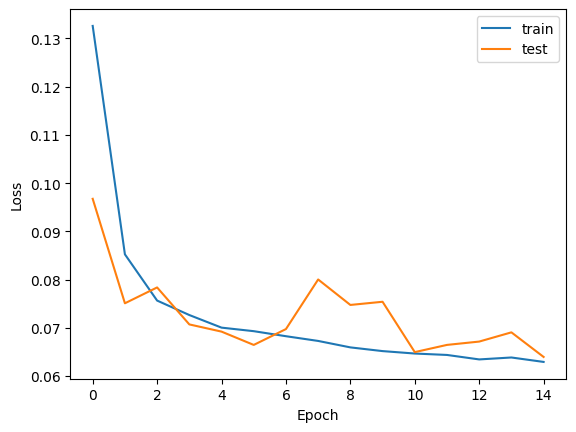

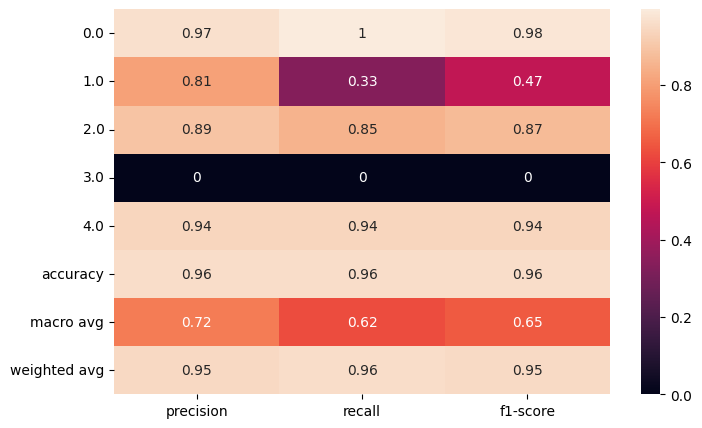

In [ ]:
model3 = InceptionModel(num_blocks=6, in_channels=1, out_channels=8,
                           bottleneck_channels=8, kernel_sizes=61, use_residuals=True,
                           num_pred_classes=5)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001, weight_decay=0.001)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(15):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        optimizer.zero_grad()
        output = model3(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model3(xb_test)
            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_test = torch.tensor(X_test).float()
y_val_pred = model3(X_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_mb_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_inception = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_inception).iloc[:-1, :].T, annot=True)
plt.show()

##### Antrenare 2.0

In [ ]:
device = torch.device("cuda")

In [ ]:
X_train = X_train.to(device)
y_mb_train_encoded = y_mb_train_encoded.to(device)
X_test = X_test.to(device)
y_mb_test_encoded = y_mb_test_encoded.to(device)

In [ ]:
train_ds = TensorDataset(X_train, y_mb_train_encoded)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

test_ds = TensorDataset(X_test, y_mb_test_encoded)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True)

Epoch 1, Train Loss: 0.1224, Test Loss: 0.0929
Epoch 2, Train Loss: 0.0837, Test Loss: 0.0847
Epoch 3, Train Loss: 0.0760, Test Loss: 0.0756
Epoch 4, Train Loss: 0.0718, Test Loss: 0.0689
Epoch 5, Train Loss: 0.0694, Test Loss: 0.0723
Epoch 6, Train Loss: 0.0571, Test Loss: 0.0588
Epoch 7, Train Loss: 0.0550, Test Loss: 0.0581
Epoch 8, Train Loss: 0.0542, Test Loss: 0.0571
Epoch 9, Train Loss: 0.0535, Test Loss: 0.0574
Epoch 10, Train Loss: 0.0529, Test Loss: 0.0567
Epoch 11, Train Loss: 0.0511, Test Loss: 0.0550
Epoch 12, Train Loss: 0.0510, Test Loss: 0.0544
Epoch 13, Train Loss: 0.0509, Test Loss: 0.0547
Epoch 14, Train Loss: 0.0507, Test Loss: 0.0545
Epoch 15, Train Loss: 0.0505, Test Loss: 0.0558


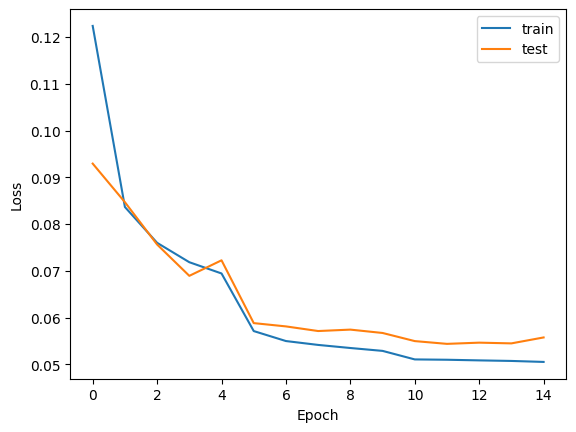

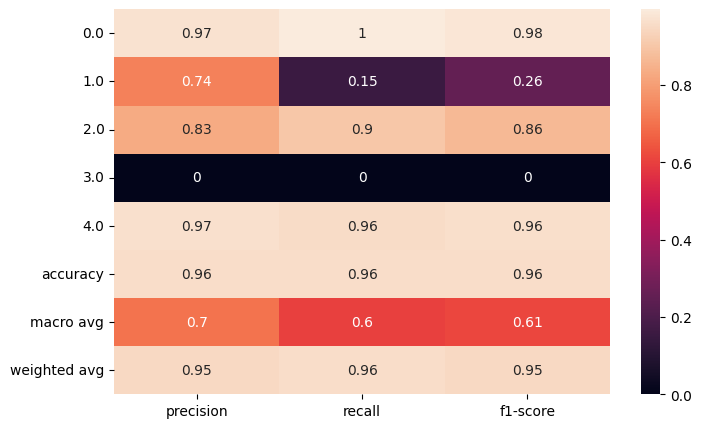

In [ ]:
model2 = InceptionModel(num_blocks=6, in_channels=1, out_channels=8,
                           bottleneck_channels=8, kernel_sizes=61, use_residuals=True,
                           num_pred_classes=5).to(device)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001, weight_decay=0.001)

# define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(15):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        optimizer.zero_grad()
        output = model2(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    scheduler.step()
    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model2(xb_test)
            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_test = torch.tensor(X_test).float()
y_val_pred = model2(X_test)
y_val_pred = torch.argmax(y_val_pred.cpu(), dim=1).numpy()

y_val_true = y_mb_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_inception = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_inception).iloc[:-1, :].T, annot=True)
plt.show()

###### Batch_size = 16

In [ ]:
train_ds = TensorDataset(X_train, y_mb_train_encoded)
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)

test_ds = TensorDataset(X_test, y_mb_test_encoded)
test_dl = DataLoader(test_ds, batch_size=16, shuffle=True)

In [ ]:
for xb, yb in train_dl:
  print(xb, xb.size(), yb, yb.size())
  break

tensor([[[0.1192, 0.1457, 0.1236,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.4557, 0.4272, 0.3608,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0213, 0.0301,  ..., 0.0000, 0.0000, 0.0000]],

        ...,

        [[0.0241, 0.0621, 0.0931,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0803, 0.1312, 0.1124,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0541, 0.0563, 0.0390,  ..., 0.0000, 0.0000, 0.0000]]],
       device='cuda:0') torch.Size([16, 1, 178]) tensor([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]], device='cuda:0') torch.Size([16, 5])


Epoch 1, Train Loss: 0.1487, Test Loss: 0.1257
Epoch 2, Train Loss: 0.1162, Test Loss: 0.0994
Epoch 3, Train Loss: 0.2322, Test Loss: 0.1427
Epoch 4, Train Loss: 0.1133, Test Loss: 0.0962
Epoch 5, Train Loss: 0.0856, Test Loss: 0.0854
Epoch 6, Train Loss: 0.0813, Test Loss: 0.0800
Epoch 7, Train Loss: 0.0790, Test Loss: 0.0790
Epoch 8, Train Loss: 0.0770, Test Loss: 0.0802
Epoch 9, Train Loss: 0.0730, Test Loss: 0.0745
Epoch 10, Train Loss: 0.0717, Test Loss: 0.0731
Epoch 11, Train Loss: 0.0713, Test Loss: 0.0735
Epoch 12, Train Loss: 0.0711, Test Loss: 0.0731


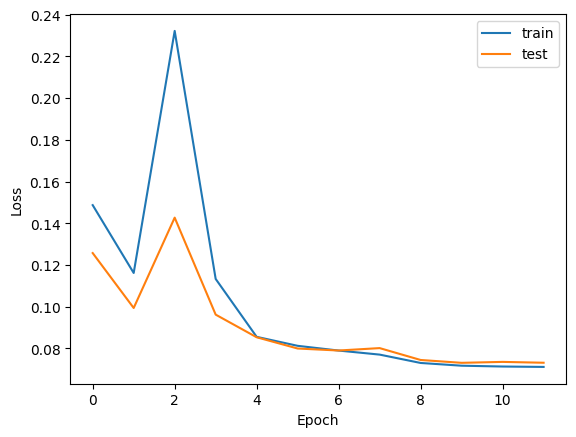

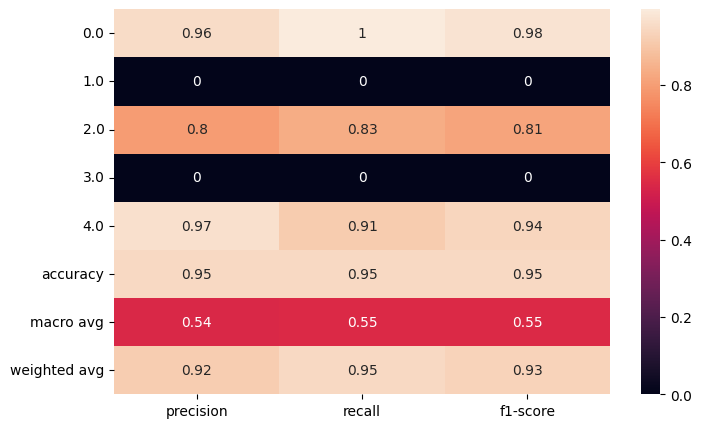

In [ ]:
model2 = InceptionModel(num_blocks=4, in_channels=1, out_channels=8,
                           bottleneck_channels=8, kernel_sizes=41, use_residuals=True,
                           num_pred_classes=5).to(device)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.002, weight_decay=0.001)

# define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(12):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        optimizer.zero_grad()
        output = model2(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    scheduler.step()
    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model2(xb_test)
            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_test = torch.tensor(X_test).float()
y_val_pred = model2(X_test)
y_val_pred = torch.argmax(y_val_pred.cpu(), dim=1).numpy()

y_val_true = y_mb_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_inception = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_inception).iloc[:-1, :].T, annot=True)
plt.show()

###### Batch_size = 128

In [ ]:
train_ds = TensorDataset(X_train, y_mb_train_encoded)
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)

test_ds = TensorDataset(X_test, y_mb_test_encoded)
test_dl = DataLoader(test_ds, batch_size=128, shuffle=True)

In [ ]:
for xb, yb in train_dl:
  print(xb, xb.size(), yb, yb.size())
  break

tensor([[[0.0442, 0.0387, 0.0470,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.1754, 0.1579, 0.0827,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0676, 0.1126, 0.1802,  ..., 0.0000, 0.0000, 0.0000]],

        ...,

        [[0.0588, 0.0252, 0.0336,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.4270, 0.3989, 0.4635,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.1033, 0.1443, 0.1301,  ..., 0.0000, 0.0000, 0.0000]]]) torch.Size([128, 1, 178]) tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0

Epoch 1, Train Loss: 0.1647, Test Loss: 0.1541
Epoch 2, Train Loss: 0.1179, Test Loss: 0.1028
Epoch 3, Train Loss: 0.0959, Test Loss: 0.1256
Epoch 4, Train Loss: 0.0894, Test Loss: 0.0969
Epoch 5, Train Loss: 0.0762, Test Loss: 0.0771
Epoch 6, Train Loss: 0.0739, Test Loss: 0.0769
Epoch 7, Train Loss: 0.0729, Test Loss: 0.0734
Epoch 8, Train Loss: 0.0718, Test Loss: 0.0743
Epoch 9, Train Loss: 0.0697, Test Loss: 0.0728
Epoch 10, Train Loss: 0.0694, Test Loss: 0.0740
Epoch 11, Train Loss: 0.0695, Test Loss: 0.0709
Epoch 12, Train Loss: 0.0694, Test Loss: 0.0733


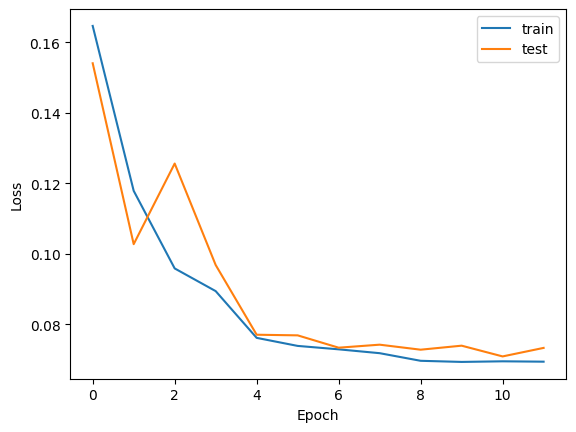

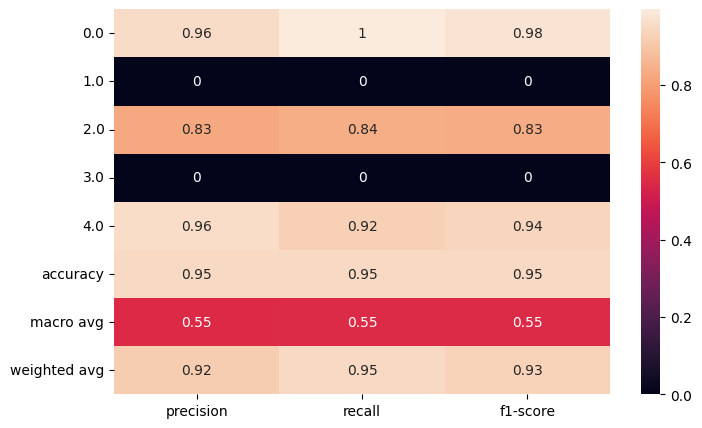

In [ ]:
model2 = InceptionModel(num_blocks=4, in_channels=1, out_channels=8,
                           bottleneck_channels=8, kernel_sizes=41, use_residuals=True,
                           num_pred_classes=5)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.002, weight_decay=0.001)

# define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(12):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        optimizer.zero_grad()
        output = model2(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    scheduler.step()
    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model2(xb_test)
            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_test = torch.tensor(X_test).float()
y_val_pred = model2(X_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_mb_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_inception = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_inception).iloc[:-1, :].T, annot=True)
plt.show()

#### Arhitectură de tip **InceptionTime 3.0**

In [ ]:
train_ds = TensorDataset(X_train, y_mb_train_encoded)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

test_ds = TensorDataset(X_test, y_mb_test_encoded)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True)

In [ ]:
class Conv1dSamePadding(nn.Conv1d):
    """Represents the "Same" padding functionality from Tensorflow.
    See: https://github.com/pytorch/pytorch/issues/3867
    Note that the padding argument in the initializer doesn't do anything now
    """
    def forward(self, input):
        return conv1d_same_padding(input, self.weight, self.bias, self.stride,
                                   self.dilation, self.groups)


def conv1d_same_padding(input, weight, bias, stride, dilation, groups):
    # stride and dilation are expected to be tuples.
    kernel, dilation, stride = weight.size(2), dilation[0], stride[0]
    l_out = l_in = input.size(2)
    padding = (((l_out - 1) * stride) - l_in + (dilation * (kernel - 1)) + 1)
    if padding % 2 != 0:
        input = F.pad(input, [0, 1])

    return F.conv1d(input=input, weight=weight, bias=bias, stride=stride,
                    padding=padding // 2,
                    dilation=dilation, groups=groups)

class InceptionModel(nn.Module):
    """A PyTorch implementation of the InceptionTime model.
    From https://arxiv.org/abs/1909.04939
    Attributes
    ----------
    num_blocks:
        The number of inception blocks to use. One inception block consists
        of 3 convolutional layers, (optionally) a bottleneck and (optionally) a residual
        connector
    in_channels:
        The number of input channels (i.e. input.shape[-1])
    out_channels:
        The number of "hidden channels" to use. Can be a list (for each block) or an
        int, in which case the same value will be applied to each block
    bottleneck_channels:
        The number of channels to use for the bottleneck. Can be list or int. If 0, no
        bottleneck is applied
    kernel_sizes:
        The size of the kernels to use for each inception block. Within each block, each
        of the 3 convolutional layers will have kernel size
        `[kernel_size // (2 ** i) for i in range(3)]`
    num_pred_classes:
        The number of output classes
    """

    def __init__(self, num_blocks: int, in_channels: int, out_channels: Union[List[int], int],
                 bottleneck_channels: Union[List[int], int], kernel_sizes: Union[List[int], int],
                 use_residuals: Union[List[bool], bool, str] = 'default',
                 num_pred_classes: int = 1
                 ) -> None:
        super().__init__()

        # for easier saving and loading
        self.input_args = {
            'num_blocks': num_blocks,
            'in_channels': in_channels,
            'out_channels': out_channels,
            'bottleneck_channels': bottleneck_channels,
            'kernel_sizes': kernel_sizes,
            'use_residuals': use_residuals,
            'num_pred_classes': num_pred_classes
        }

        channels = [in_channels] + cast(List[int], self._expand_to_blocks(out_channels,
                                                                          num_blocks))
        bottleneck_channels = cast(List[int], self._expand_to_blocks(bottleneck_channels,
                                                                     num_blocks))
        kernel_sizes = cast(List[int], self._expand_to_blocks(kernel_sizes, num_blocks))
        if use_residuals == 'default':
            use_residuals = [True if i % 3 == 2 else False for i in range(num_blocks)]
        use_residuals = cast(List[bool], self._expand_to_blocks(
            cast(Union[bool, List[bool]], use_residuals), num_blocks)
        )

        self.blocks = nn.Sequential(*[
            InceptionBlock(in_channels=channels[i], out_channels=channels[i + 1],
                           residual=use_residuals[i], bottleneck_channels=bottleneck_channels[i],
                           kernel_size=kernel_sizes[i]) for i in range(num_blocks)
        ])

        # a global average pooling (i.e. mean of the time dimension) is why
        # in_features=channels[-1]
        self.fc1 = nn.Linear(channels[-1], 128)
        self.fc2 = nn.Linear(128, 64)        
        self.fc3 = nn.Linear(64, 48)        
        self.fc4 = nn.Linear(48, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 5)
        #self.linear = nn.Linear(in_features=, out_features=num_pred_classes)

    @staticmethod
    def _expand_to_blocks(value: Union[int, bool, List[int], List[bool]],
                          num_blocks: int) -> Union[List[int], List[bool]]:
        if isinstance(value, list):
            assert len(value) == num_blocks, \
                f'Length of inputs lists must be the same as num blocks, ' \
                f'expected length {num_blocks}, got {len(value)}'
        else:
            value = [value] * num_blocks
        return value

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore
        x = self.blocks(x).mean(dim=-1)  # the mean is the global average pooling
        
        dropout = nn.Dropout(0.1);
        x = dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x


class InceptionBlock(nn.Module):
    """An inception block consists of an (optional) bottleneck, followed
    by 3 conv1d layers. Optionally residual
    """

    def __init__(self, in_channels: int, out_channels: int,
                 residual: bool, stride: int = 1, bottleneck_channels: int = 32,
                 kernel_size: int = 41) -> None:
        assert kernel_size > 3, "Kernel size must be strictly greater than 3"
        super().__init__()

        self.use_bottleneck = bottleneck_channels > 0
        if self.use_bottleneck:
            self.bottleneck = Conv1dSamePadding(in_channels, bottleneck_channels,
                                                kernel_size=1, bias=False)
        kernel_size_s = [kernel_size // (2 ** i) for i in range(3)]
        start_channels = bottleneck_channels if self.use_bottleneck else in_channels
        channels = [start_channels] + [out_channels] * 3
        self.conv_layers = nn.Sequential(*[
            Conv1dSamePadding(in_channels=channels[i], out_channels=channels[i + 1],
                              kernel_size=kernel_size_s[i], stride=stride, bias=False)
            for i in range(len(kernel_size_s))
        ])

        self.batchnorm = nn.BatchNorm1d(num_features=channels[-1])
        self.relu = nn.ReLU()

        self.use_residual = residual
        if residual:
            self.residual = nn.Sequential(*[
                Conv1dSamePadding(in_channels=in_channels, out_channels=out_channels,
                                  kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels),
                nn.ReLU()
            ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore
        org_x = x
        if self.use_bottleneck:
            x = self.bottleneck(x)
        x = self.conv_layers(x)

        if self.use_residual:
            x = x + self.residual(org_x)

        return x

##### Antrenare

Epoch 1, Train Loss: 0.1508, Test Loss: 0.1297
Epoch 2, Train Loss: 0.1096, Test Loss: 0.1007
Epoch 3, Train Loss: 0.1007, Test Loss: 0.0951
Epoch 4, Train Loss: 0.0966, Test Loss: 0.1062
Epoch 5, Train Loss: 0.0820, Test Loss: 0.0811
Epoch 6, Train Loss: 0.0792, Test Loss: 0.0797
Epoch 7, Train Loss: 0.0775, Test Loss: 0.0765
Epoch 8, Train Loss: 0.0762, Test Loss: 0.0764
Epoch 9, Train Loss: 0.0743, Test Loss: 0.0747
Epoch 10, Train Loss: 0.0737, Test Loss: 0.0745


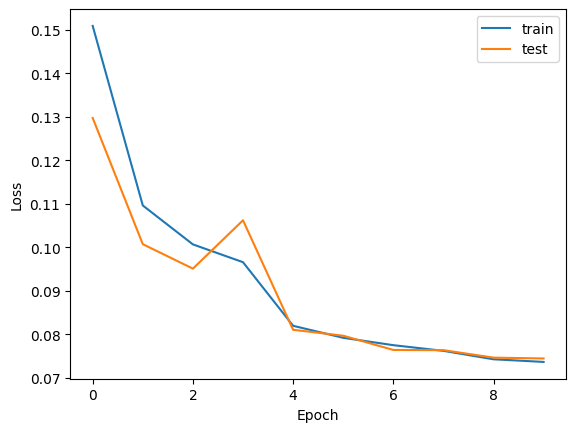

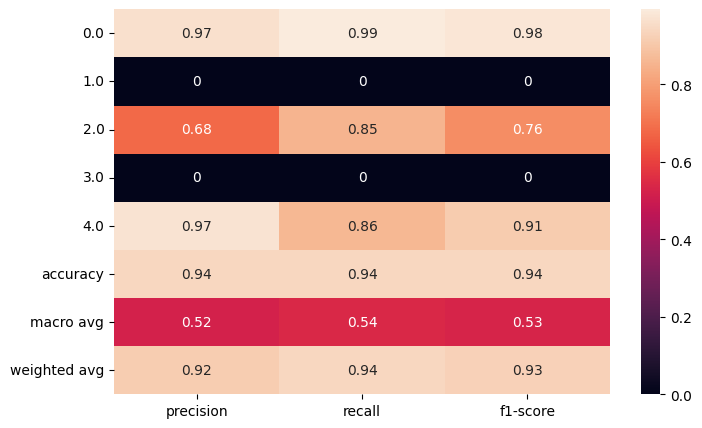

In [ ]:
model = InceptionModel(num_blocks=4, in_channels=1, out_channels=8,
                           bottleneck_channels=8, kernel_sizes=41, use_residuals=True,
                           num_pred_classes=5)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=0.001)

# define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(10):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    scheduler.step()
    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model(xb_test)
            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_test = torch.tensor(X_test).float()
y_val_pred = model(X_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_mb_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_inception = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_inception).iloc[:-1, :].T, annot=True)
plt.show()

#### Arhitectură de tip **LSTM**

In [ ]:
class ComplexLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(ComplexLSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        # Initialize the hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward pass through the LSTM layer
        out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # Pass the final hidden state through Linear layers
        out = self.fc1(hn[-1])
        out = self.fc2(out)
        
        return out

##### Antrenare

###### Batch_size = 256

In [ ]:
train_ds = TensorDataset(X_train, y_mb_train_encoded)
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)

test_ds = TensorDataset(X_test, y_mb_test_encoded)
test_dl = DataLoader(test_ds, batch_size=256, shuffle=True)

Epoch 1, Train Loss: 0.2312, Test Loss: 0.1580
Epoch 2, Train Loss: 0.1452, Test Loss: 0.1338
Epoch 3, Train Loss: 0.1293, Test Loss: 0.1264
Epoch 4, Train Loss: 0.1224, Test Loss: 0.1209
Epoch 5, Train Loss: 0.1183, Test Loss: 0.1185
Epoch 6, Train Loss: 0.1149, Test Loss: 0.1147
Epoch 7, Train Loss: 0.1126, Test Loss: 0.1132
Epoch 8, Train Loss: 0.1111, Test Loss: 0.1120
Epoch 9, Train Loss: 0.1106, Test Loss: 0.1150
Epoch 10, Train Loss: 0.1105, Test Loss: 0.1091
Epoch 11, Train Loss: 0.1073, Test Loss: 0.1080
Epoch 12, Train Loss: 0.1066, Test Loss: 0.1069
Epoch 13, Train Loss: 0.1058, Test Loss: 0.1071
Epoch 14, Train Loss: 0.1057, Test Loss: 0.1056
Epoch 15, Train Loss: 0.1044, Test Loss: 0.1065
Epoch 16, Train Loss: 0.1039, Test Loss: 0.1045
Epoch 17, Train Loss: 0.1037, Test Loss: 0.1055
Epoch 18, Train Loss: 0.1034, Test Loss: 0.1041
Epoch 19, Train Loss: 0.1030, Test Loss: 0.1046
Epoch 20, Train Loss: 0.1028, Test Loss: 0.1045
Epoch 21, Train Loss: 0.1028, Test Loss: 0.1039
E

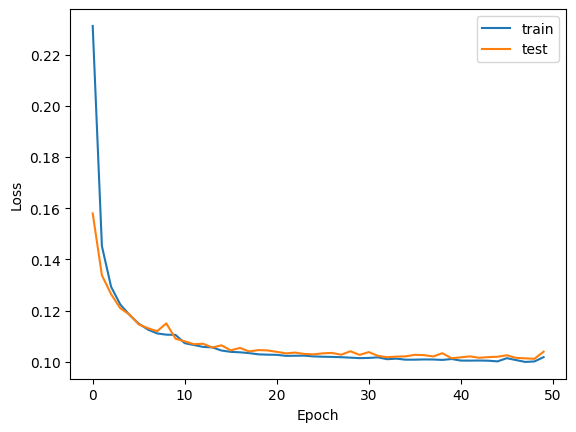

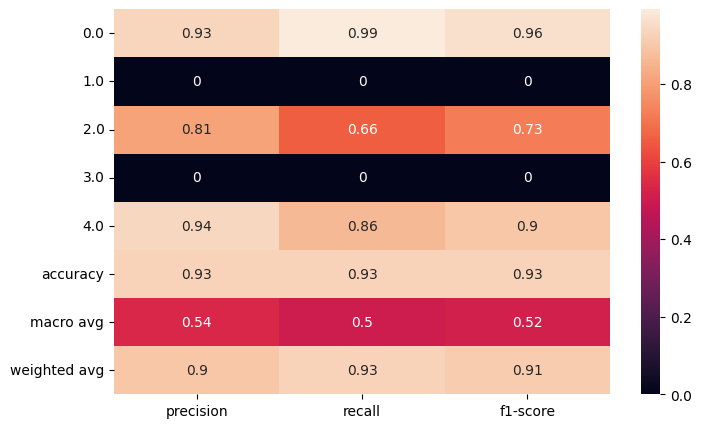

In [ ]:
model = ComplexLSTM(input_size = 178, hidden_size = 50, num_layers = 1, output_size = 5)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(50):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        yb_pred = model(xb)

        loss = criterion(yb_pred, yb)
        epoch_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model(xb_test)
            
            yb_pred_test = yb_pred_test.squeeze(1).float()

            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_test = torch.tensor(X_test).float()
y_val_pred = model(X_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_mb_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_lstm = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_lstm).iloc[:-1, :].T, annot=True)
plt.show()

###### Batch_size = 64

In [ ]:
train_ds = TensorDataset(X_train, y_mb_train_encoded)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

test_ds = TensorDataset(X_test, y_mb_test_encoded)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=True)

Epoch 1, Train Loss: 0.1675, Test Loss: 0.1266
Epoch 2, Train Loss: 0.1183, Test Loss: 0.1135
Epoch 3, Train Loss: 0.1116, Test Loss: 0.1129
Epoch 4, Train Loss: 0.1083, Test Loss: 0.1098
Epoch 5, Train Loss: 0.1064, Test Loss: 0.1077
Epoch 6, Train Loss: 0.1054, Test Loss: 0.1046
Epoch 7, Train Loss: 0.1049, Test Loss: 0.1044
Epoch 8, Train Loss: 0.1045, Test Loss: 0.1035
Epoch 9, Train Loss: 0.1045, Test Loss: 0.1057
Epoch 10, Train Loss: 0.1040, Test Loss: 0.1044
Epoch 11, Train Loss: 0.1039, Test Loss: 0.1045
Epoch 12, Train Loss: 0.1042, Test Loss: 0.1034
Epoch 13, Train Loss: 0.1037, Test Loss: 0.1091
Epoch 14, Train Loss: 0.1037, Test Loss: 0.1034
Epoch 15, Train Loss: 0.1041, Test Loss: 0.1084
Epoch 16, Train Loss: 0.1038, Test Loss: 0.1037
Epoch 17, Train Loss: 0.1034, Test Loss: 0.1042
Epoch 18, Train Loss: 0.1034, Test Loss: 0.1035
Epoch 19, Train Loss: 0.1036, Test Loss: 0.1040
Epoch 20, Train Loss: 0.1033, Test Loss: 0.1035
Epoch 21, Train Loss: 0.1033, Test Loss: 0.1038
E

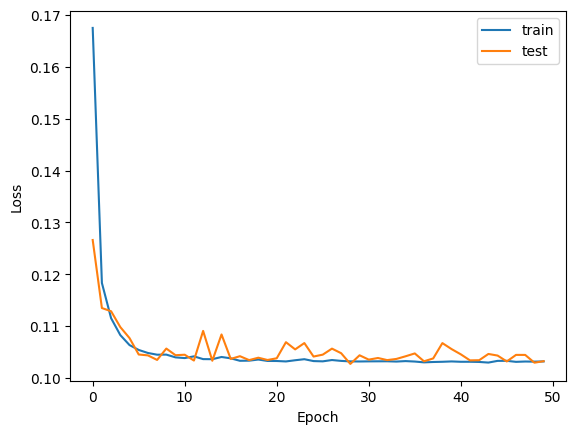

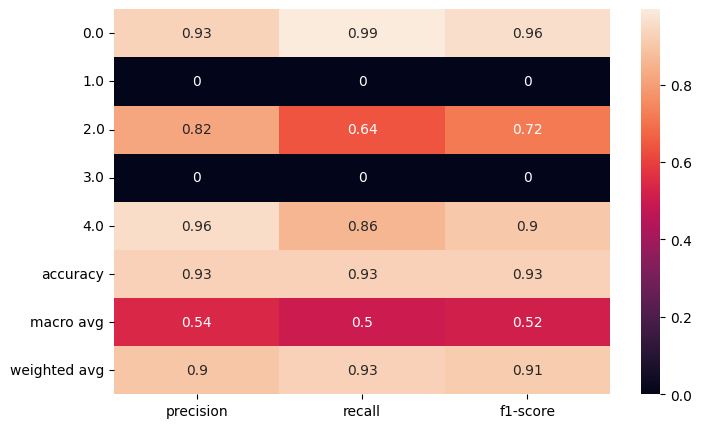

In [ ]:
model = ComplexLSTM(input_size = 178, hidden_size = 50, num_layers = 1, output_size = 5)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(50):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        yb_pred = model(xb)

        loss = criterion(yb_pred, yb)
        epoch_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model(xb_test)
            
            yb_pred_test = yb_pred_test.squeeze(1).float()

            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_test = torch.tensor(X_test).float()
y_val_pred = model(X_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_mb_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_lstm = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_lstm).iloc[:-1, :].T, annot=True)
plt.show()

###### Batch_size = 512

In [ ]:
train_ds = TensorDataset(X_train, y_mb_train_encoded)
train_dl = DataLoader(train_ds, batch_size=512, shuffle=True)

test_ds = TensorDataset(X_test, y_mb_test_encoded)
test_dl = DataLoader(test_ds, batch_size=512, shuffle=True)

Epoch 1, Train Loss: 0.2777, Test Loss: 0.1897
Epoch 2, Train Loss: 0.1696, Test Loss: 0.1560
Epoch 3, Train Loss: 0.1476, Test Loss: 0.1421
Epoch 4, Train Loss: 0.1341, Test Loss: 0.1304
Epoch 5, Train Loss: 0.1268, Test Loss: 0.1261
Epoch 6, Train Loss: 0.1211, Test Loss: 0.1208
Epoch 7, Train Loss: 0.1180, Test Loss: 0.1190
Epoch 8, Train Loss: 0.1158, Test Loss: 0.1160
Epoch 9, Train Loss: 0.1140, Test Loss: 0.1157
Epoch 10, Train Loss: 0.1122, Test Loss: 0.1135
Epoch 11, Train Loss: 0.1107, Test Loss: 0.1110
Epoch 12, Train Loss: 0.1100, Test Loss: 0.1102
Epoch 13, Train Loss: 0.1086, Test Loss: 0.1090
Epoch 14, Train Loss: 0.1075, Test Loss: 0.1087
Epoch 15, Train Loss: 0.1069, Test Loss: 0.1079
Epoch 16, Train Loss: 0.1060, Test Loss: 0.1075
Epoch 17, Train Loss: 0.1060, Test Loss: 0.1094
Epoch 18, Train Loss: 0.1058, Test Loss: 0.1072
Epoch 19, Train Loss: 0.1049, Test Loss: 0.1059
Epoch 20, Train Loss: 0.1044, Test Loss: 0.1055
Epoch 21, Train Loss: 0.1042, Test Loss: 0.1057
E

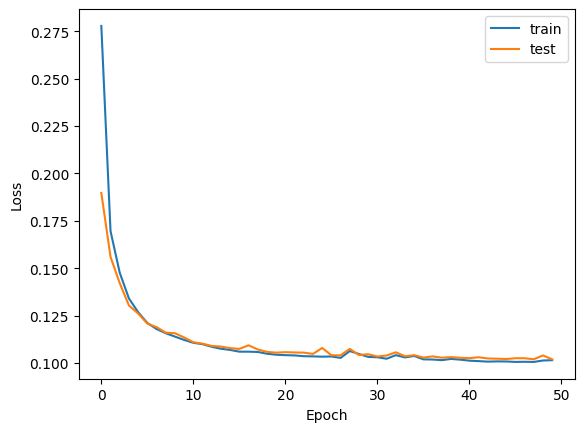

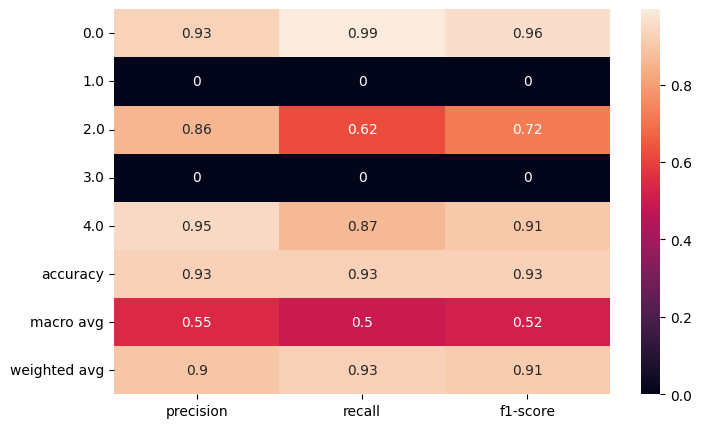

In [ ]:
model = ComplexLSTM(input_size = 178, hidden_size = 50, num_layers = 1, output_size = 5)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(50):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        yb_pred = model(xb)

        loss = criterion(yb_pred, yb)
        epoch_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model(xb_test)
            
            yb_pred_test = yb_pred_test.squeeze(1).float()

            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_test = torch.tensor(X_test).float()
y_val_pred = model(X_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_mb_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_lstm = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_lstm).iloc[:-1, :].T, annot=True)
plt.show()

##### Antrenare 2.0

In [ ]:
train_ds = TensorDataset(X_train, y_mb_train_encoded)
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)

test_ds = TensorDataset(X_test, y_mb_test_encoded)
test_dl = DataLoader(test_ds, batch_size=256, shuffle=True)

Epoch 1, Train Loss: 0.2148, Test Loss: 0.1486
Epoch 2, Train Loss: 0.1368, Test Loss: 0.1303
Epoch 3, Train Loss: 0.1235, Test Loss: 0.1215
Epoch 4, Train Loss: 0.1182, Test Loss: 0.1177
Epoch 5, Train Loss: 0.1153, Test Loss: 0.1160
Epoch 6, Train Loss: 0.1133, Test Loss: 0.1225
Epoch 7, Train Loss: 0.1117, Test Loss: 0.1109
Epoch 8, Train Loss: 0.1107, Test Loss: 0.1114
Epoch 9, Train Loss: 0.1094, Test Loss: 0.1106
Epoch 10, Train Loss: 0.1078, Test Loss: 0.1081
Epoch 11, Train Loss: 0.1069, Test Loss: 0.1088
Epoch 12, Train Loss: 0.1062, Test Loss: 0.1075
Epoch 13, Train Loss: 0.1054, Test Loss: 0.1055
Epoch 14, Train Loss: 0.1049, Test Loss: 0.1073
Epoch 15, Train Loss: 0.1047, Test Loss: 0.1046
Epoch 16, Train Loss: 0.1037, Test Loss: 0.1039
Epoch 17, Train Loss: 0.1031, Test Loss: 0.1037
Epoch 18, Train Loss: 0.1031, Test Loss: 0.1036
Epoch 19, Train Loss: 0.1028, Test Loss: 0.1035
Epoch 20, Train Loss: 0.1027, Test Loss: 0.1027


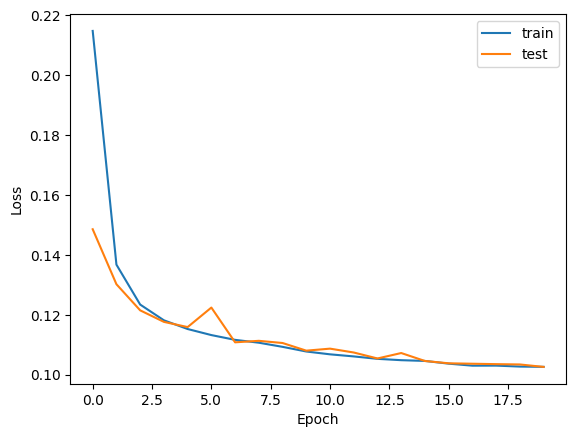

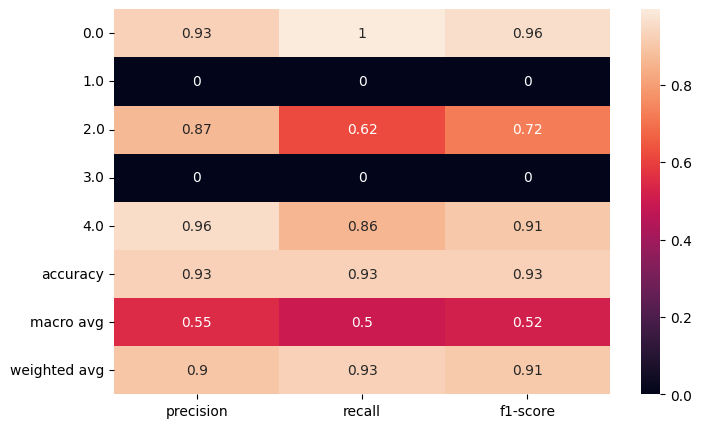

In [ ]:
model = ComplexLSTM(input_size = 178, hidden_size = 100, num_layers = 1, output_size = 5)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(20):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        yb_pred = model(xb)

        loss = criterion(yb_pred, yb)
        epoch_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model(xb_test)
            
            yb_pred_test = yb_pred_test.squeeze(1).float()

            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_test = torch.tensor(X_test).float()
y_val_pred = model(X_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_mb_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_lstm = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_lstm).iloc[:-1, :].T, annot=True)
plt.show()

#### Arhitectură de tip **LSTM 2.0**

In [ ]:
class ComplexLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(ComplexLSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, output_size)
        # dropout
        self.dropout = nn.Dropout(0.1)
        
        # ReLU activation
        self.relu = nn.ReLU()

    def forward(self, x):
        # Initialize the hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward pass through the LSTM layer
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.relu(out)
        # Pass the final hidden state through Linear layers
        out = self.fc1(hn[-1])
        out = self.fc2(out)

        return out

##### Antrenare

Epoch 1, Train Loss: 0.1945, Test Loss: 0.1381
Epoch 2, Train Loss: 0.1249, Test Loss: 0.1196
Epoch 3, Train Loss: 0.1151, Test Loss: 0.1139
Epoch 4, Train Loss: 0.1107, Test Loss: 0.1096
Epoch 5, Train Loss: 0.1081, Test Loss: 0.1088
Epoch 6, Train Loss: 0.1065, Test Loss: 0.1063
Epoch 7, Train Loss: 0.1052, Test Loss: 0.1051
Epoch 8, Train Loss: 0.1045, Test Loss: 0.1054
Epoch 9, Train Loss: 0.1041, Test Loss: 0.1037
Epoch 10, Train Loss: 0.1038, Test Loss: 0.1042
Epoch 11, Train Loss: 0.1031, Test Loss: 0.1043
Epoch 12, Train Loss: 0.1036, Test Loss: 0.1127
Epoch 13, Train Loss: 0.1034, Test Loss: 0.1045
Epoch 14, Train Loss: 0.1025, Test Loss: 0.1032
Epoch 15, Train Loss: 0.1020, Test Loss: 0.1048
Epoch 16, Train Loss: 0.1019, Test Loss: 0.1035
Epoch 17, Train Loss: 0.1018, Test Loss: 0.1024
Epoch 18, Train Loss: 0.1020, Test Loss: 0.1039
Epoch 19, Train Loss: 0.1036, Test Loss: 0.1078
Epoch 20, Train Loss: 0.1022, Test Loss: 0.1030
Epoch 21, Train Loss: 0.1015, Test Loss: 0.1034
E

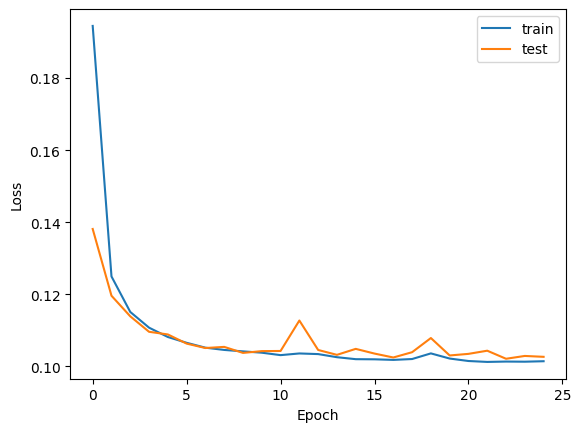

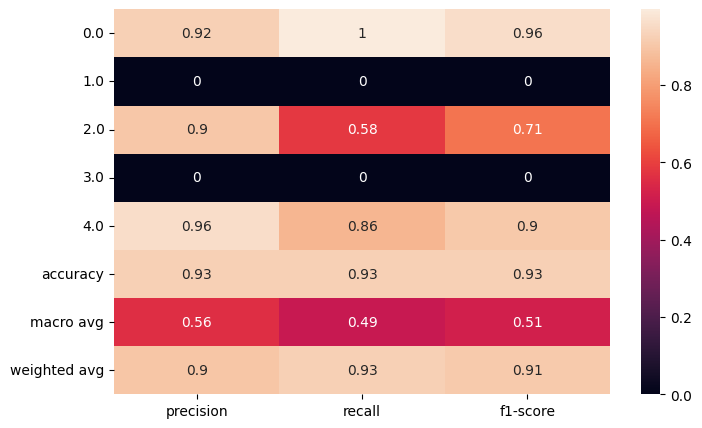

In [ ]:
model = ComplexLSTM(input_size = 178, hidden_size = 50, num_layers = 1, output_size = 5)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=0.001)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(25):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        yb_pred = model(xb)

        loss = criterion(yb_pred, yb)
        epoch_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model(xb_test)
            
            yb_pred_test = yb_pred_test.squeeze(1).float()

            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_test = torch.tensor(X_test).float()
y_val_pred = model(X_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_mb_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_lstm = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_lstm).iloc[:-1, :].T, annot=True)
plt.show()

## Rezolvarea cerintelor - PTB Diagnostic ECG

In [ ]:
# Scale the data

X_pt_train = MinMaxScaler().fit_transform(X_pt_train)
X_pt_test = MinMaxScaler().fit_transform(X_pt_test)

In [ ]:
X_pt_train

array([[0.13929147, 0.14090177, 0.12908284, ..., 0.        , 0.        ,
        0.        ],
       [0.22179975, 0.21504013, 0.23877563, ..., 0.        , 0.        ,
        0.        ],
       [0.08703513, 0.08651859, 0.08936184, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.17436489, 0.19745958, 0.18512805, ..., 0.        , 0.        ,
        0.        ],
       [0.30122819, 0.37104073, 0.37714695, ..., 0.        , 0.        ,
        0.        ],
       [0.01949399, 0.05350477, 0.06859989, ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
X_pt_test

array([[0.34144646, 0.18376804, 0.15939343, ..., 0.        , 0.        ,
        0.        ],
       [0.11696126, 0.11613679, 0.1257094 , ..., 0.        , 0.        ,
        0.        ],
       [0.07237747, 0.08394855, 0.06659512, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.09809524, 0.21985375, 0.23850542, ..., 0.        , 0.        ,
        0.        ],
       [0.08988764, 0.12179258, 0.14798547, ..., 0.        , 0.        ,
        0.        ],
       [0.19965377, 0.19513548, 0.17512293, ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
y_pt_train

0        0.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
11635    1.0
11636    1.0
11637    1.0
11638    0.0
11639    1.0
Name: 187, Length: 11640, dtype: float64

In [ ]:
y_pt_test

0       1.0
1       0.0
2       0.0
3       1.0
4       1.0
       ... 
2905    1.0
2906    1.0
2907    1.0
2908    0.0
2909    1.0
Name: 187, Length: 2910, dtype: float64

### **Algoritmi propuși și evaluarea acestora [2p]**

NOTA! Veți aplica modele de rețele neurale pe seturile de date cu aritmii ale
bătăilor de inimă (MIT-BIH și PBT).

Sunt propuse spre evaluare următoarele arhitecturi de rețele neurale:

● Arhitectură de tip MLP (Multi-Layered Perceptron) care primește ca intrare întreaga secvență a unei bătăi de inimă [1p]

  ○ Experimentați cu numărul de straturi și dimensiunea acestora

● Arhitectură de tip convoluțională, folosind straturi de convoluții 1D și global average pooling [1.5p]

  ○ Puteți genera propria voastră arhitectură explorând:

■ Numărul de straturi de convoluție și dimensiunea canalelor (channels)
a fiecăruia

■ Combinarea cu straturi liniare pentru partea finală a rețelei

■ Exemple de tutoriale găsiți aici și aici.

  ○ Puteți folosi o arhitectură dată, InceptionTime, care utilizează straturi
convoluționale 1D adaptând arhitectura Inception (definită pentru imagini) pe
cazul seriilor de timp.

■ Implementare în Pytorch pentru InceptionTime

■ Impelemtare în Keras pentru InceptionTme

■ Sugestii:

● Folosiți 1 modul de Inception (în loc de default-ul de 2 din
paper)

● Variați dimensiunea kernelelor de convoluție

● O arhitectură de tip recurent (LSTM sau BiLSTM) [1.5p]

○ Exemplu de tutorial (folosiți doar partea de LSTM)

○ Sugestii:

■ Variați numărul de celule LSTM folosite (e.g. 1 sau 2)

■ Variați dimensiunea hidden size-ului din celula LSTM

■ Variați între un strat LSTM și BiLSTM (LSTM bidirecțional)

NOTĂ: datele pe care le aveți la antrenare sunt relativ puține din punct de vedere numeric.

Luați în considerare (a se observa și în tutorialele referențiate) utilizarea metodelor de regularizare, e.g. prin utilizarea straturilor de Dropout sau prin utilizarea unui mecanism de weight decay în optimizator (a se vedea detalii aici).

NOTĂ: în afară de arhitectura în sine, performanța unui model neural este influențată și de optimizatorul ales și de parametrizarea acestuia. 

Sugestii:

● Folosiți un optimizator adaptiv (e.g. ADAM) și unul cu rată de învățare (learning rate) configurabilă (e.g. SGD cu momentum și un Learning Rate Scheduler)

● Explorați influență dimensiunii batch-urilor

● Explorați influența numărului de epoci de antrenare


#### Preprocesare

In [ ]:
y_pt_train.values

array([0., 1., 1., ..., 1., 0., 1.])

In [ ]:
# one-hot encode the labels

y_pt_train_encoded = torch.tensor(y_pt_train.values)
y_pt_test_encoded = torch.tensor(y_pt_test.values)

In [ ]:
y_pt_train_encoded

tensor([0., 1., 1.,  ..., 1., 0., 1.], dtype=torch.float64)

In [ ]:
# Get the ont-hot encoding

y_pt_train_encoded = F.one_hot(y_pt_train_encoded.long(), num_classes=2).float()
y_pt_test_encoded = F.one_hot(y_pt_test_encoded.long(), num_classes=2).float()

In [ ]:
y_pt_train_encoded

tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        ...,
        [0., 1.],
        [1., 0.],
        [0., 1.]])

In [ ]:
y_pt_test_encoded

tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        ...,
        [0., 1.],
        [1., 0.],
        [0., 1.]])

In [ ]:
# convert to PyTorch tensors

X_pt_train = torch.tensor(X_pt_train).float()
X_pt_train

tensor([[0.1393, 0.1409, 0.1291,  ..., 0.0000, 0.0000, 0.0000],
        [0.2218, 0.2150, 0.2388,  ..., 0.0000, 0.0000, 0.0000],
        [0.0870, 0.0865, 0.0894,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.1744, 0.1975, 0.1851,  ..., 0.0000, 0.0000, 0.0000],
        [0.3012, 0.3710, 0.3771,  ..., 0.0000, 0.0000, 0.0000],
        [0.0195, 0.0535, 0.0686,  ..., 0.0000, 0.0000, 0.0000]])

In [ ]:
# create a DataLoader for the mini-batches

train_ds = TensorDataset(X_pt_train, y_pt_train_encoded)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

In [ ]:
X_pt_test = torch.tensor(X_pt_test).float()
X_pt_test

tensor([[0.3414, 0.1838, 0.1594,  ..., 0.0000, 0.0000, 0.0000],
        [0.1170, 0.1161, 0.1257,  ..., 0.0000, 0.0000, 0.0000],
        [0.0724, 0.0839, 0.0666,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0981, 0.2199, 0.2385,  ..., 0.0000, 0.0000, 0.0000],
        [0.0899, 0.1218, 0.1480,  ..., 0.0000, 0.0000, 0.0000],
        [0.1997, 0.1951, 0.1751,  ..., 0.0000, 0.0000, 0.0000]])

In [ ]:
# create a DataLoader for the mini-batches

test_ds = TensorDataset(X_pt_test, y_pt_test_encoded)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True)

#### Arhitectură de tip **MLP**

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(178, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 2)
        
    def forward(self, x):
        x = x.view(-1, 178)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        #x = F.softmax(self.fc4(x), dim=1)
        x = self.fc4(x)
        return x

##### Antrenare

Epoch 1, Train Loss: 0.4938, Test Loss: 0.4061
Epoch 2, Train Loss: 0.4002, Test Loss: 0.3690
Epoch 3, Train Loss: 0.3720, Test Loss: 0.3463
Epoch 4, Train Loss: 0.3461, Test Loss: 0.3234
Epoch 5, Train Loss: 0.3167, Test Loss: 0.3054
Epoch 6, Train Loss: 0.2920, Test Loss: 0.2718
Epoch 7, Train Loss: 0.2721, Test Loss: 0.2668
Epoch 8, Train Loss: 0.2559, Test Loss: 0.2432
Epoch 9, Train Loss: 0.2401, Test Loss: 0.2302
Epoch 10, Train Loss: 0.2296, Test Loss: 0.2360
Epoch 11, Train Loss: 0.2232, Test Loss: 0.2175
Epoch 12, Train Loss: 0.2099, Test Loss: 0.2194
Epoch 13, Train Loss: 0.1966, Test Loss: 0.2038
Epoch 14, Train Loss: 0.1965, Test Loss: 0.2461
Epoch 15, Train Loss: 0.1873, Test Loss: 0.1915
Epoch 16, Train Loss: 0.1828, Test Loss: 0.1994
Epoch 17, Train Loss: 0.1734, Test Loss: 0.1945
Epoch 18, Train Loss: 0.1739, Test Loss: 0.1929
Epoch 19, Train Loss: 0.1666, Test Loss: 0.2168
Epoch 20, Train Loss: 0.1625, Test Loss: 0.1764
Epoch 21, Train Loss: 0.1600, Test Loss: 0.1802
E

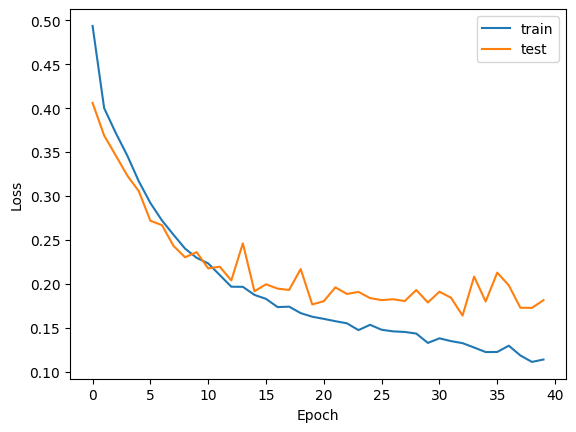

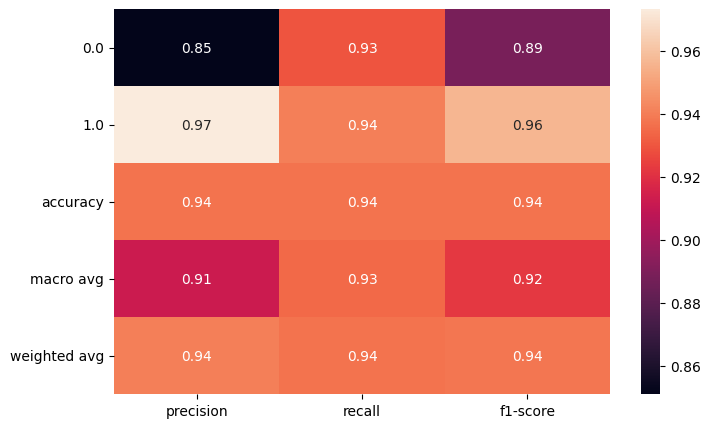

In [ ]:
model = MLP()

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(40):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        yb_pred = model(xb)

        loss = criterion(yb_pred, yb)
        epoch_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model(xb_test)
            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_pt_test = torch.tensor(X_pt_test).float()
y_val_pred = model(X_pt_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_pt_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_mlp = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_mlp).iloc[:-1, :].T, annot=True)
plt.show()

#### Arhitectură de tip **MLP 2.0**

In [ ]:
class MLP2(nn.Module):
    def __init__(self):
        super(MLP2, self).__init__()
        self.fc1 = nn.Linear(178, 128)
        self.fc2 = nn.Linear(128, 64)        
        self.fc3 = nn.Linear(64, 48)        
        self.fc4 = nn.Linear(48, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 2)
        
    def forward(self, x):
        x = x.view(-1, 178)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        #x = F.softmax(self.fc6(x), dim=1)
        return x


##### Antrenare

Epoch 1, Train Loss: 0.5097, Test Loss: 0.4018
Epoch 2, Train Loss: 0.4064, Test Loss: 0.3807
Epoch 3, Train Loss: 0.3852, Test Loss: 0.3596
Epoch 4, Train Loss: 0.3618, Test Loss: 0.3497
Epoch 5, Train Loss: 0.3357, Test Loss: 0.3018
Epoch 6, Train Loss: 0.3095, Test Loss: 0.3325
Epoch 7, Train Loss: 0.2853, Test Loss: 0.2571
Epoch 8, Train Loss: 0.2687, Test Loss: 0.2462
Epoch 9, Train Loss: 0.2521, Test Loss: 0.2439
Epoch 10, Train Loss: 0.2342, Test Loss: 0.2501
Epoch 11, Train Loss: 0.2204, Test Loss: 0.2139
Epoch 12, Train Loss: 0.1951, Test Loss: 0.2404
Epoch 13, Train Loss: 0.1908, Test Loss: 0.2835
Epoch 14, Train Loss: 0.1771, Test Loss: 0.2267
Epoch 15, Train Loss: 0.1656, Test Loss: 0.1886
Epoch 16, Train Loss: 0.1594, Test Loss: 0.2013
Epoch 17, Train Loss: 0.1496, Test Loss: 0.1765
Epoch 18, Train Loss: 0.1433, Test Loss: 0.1819
Epoch 19, Train Loss: 0.1358, Test Loss: 0.1767
Epoch 20, Train Loss: 0.1344, Test Loss: 0.1717
Epoch 21, Train Loss: 0.1313, Test Loss: 0.1589
E

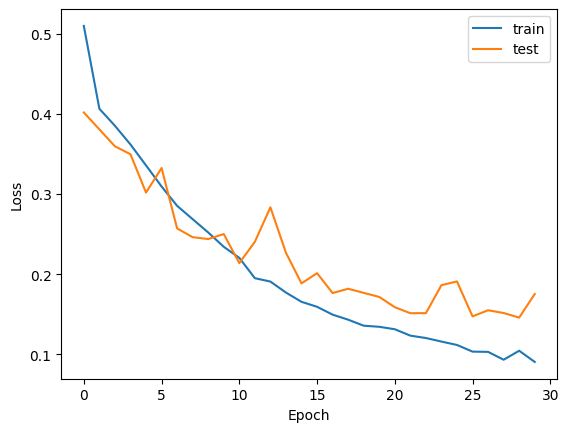

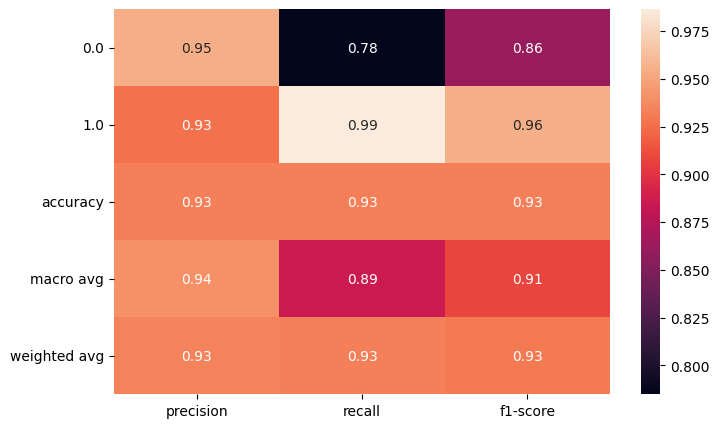

In [ ]:
model = MLP2()

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.001)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(30):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        yb_pred = model(xb)

        loss = criterion(yb_pred, yb)
        epoch_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model(xb_test)
            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_pt_test = torch.tensor(X_pt_test).float()
y_val_pred = model(X_pt_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_pt_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_mlp = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_mlp).iloc[:-1, :].T, annot=True)
plt.show()

#### Arhitectură de tip **MLP 3.0**

##### Antrenare

Epoch 1, Train Loss: 0.6034, Test Loss: 0.5817
Epoch 2, Train Loss: 0.5931, Test Loss: 0.5828
Epoch 3, Train Loss: 0.5926, Test Loss: 0.5803
Epoch 4, Train Loss: 0.5900, Test Loss: 0.5726
Epoch 5, Train Loss: 0.5236, Test Loss: 0.4247
Epoch 6, Train Loss: 0.4192, Test Loss: 0.3830
Epoch 7, Train Loss: 0.3993, Test Loss: 0.3762
Epoch 8, Train Loss: 0.3732, Test Loss: 0.3532
Epoch 9, Train Loss: 0.3561, Test Loss: 0.3347
Epoch 10, Train Loss: 0.3408, Test Loss: 0.3097
Epoch 11, Train Loss: 0.3272, Test Loss: 0.3181
Epoch 12, Train Loss: 0.3152, Test Loss: 0.5197
Epoch 13, Train Loss: 0.3046, Test Loss: 0.2697
Epoch 14, Train Loss: 0.2866, Test Loss: 0.3539
Epoch 15, Train Loss: 0.2663, Test Loss: 0.2752
Epoch 16, Train Loss: 0.2607, Test Loss: 0.2392
Epoch 17, Train Loss: 0.2507, Test Loss: 0.2516
Epoch 18, Train Loss: 0.2370, Test Loss: 0.2494
Epoch 19, Train Loss: 0.2254, Test Loss: 0.2255
Epoch 20, Train Loss: 0.2196, Test Loss: 0.2740
Epoch 21, Train Loss: 0.1648, Test Loss: 0.1761
E

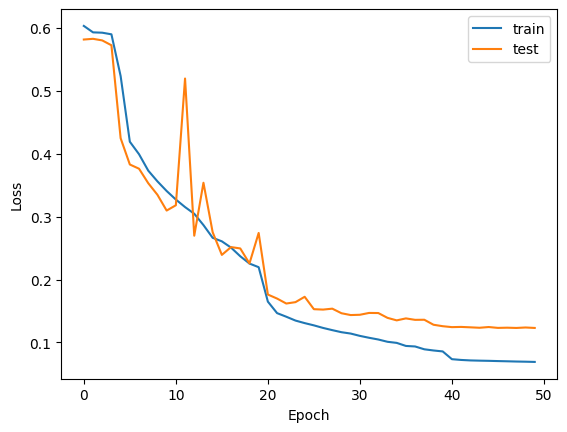

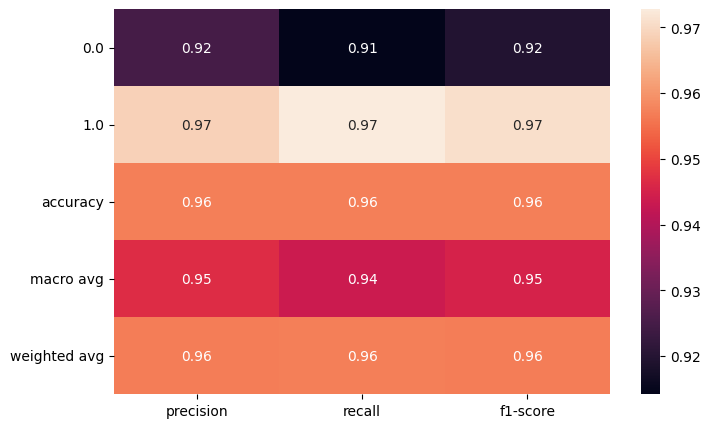

In [ ]:
model = MLP2()

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()

# define the optimizer with SGD and momentum
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)

# define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20)
# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(50):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        yb_pred = model(xb)

        loss = criterion(yb_pred, yb)
        epoch_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    scheduler.step()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model(xb_test)
            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_pt_test = torch.tensor(X_pt_test).float()
y_val_pred = model(X_pt_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_pt_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_mlp = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_mlp).iloc[:-1, :].T, annot=True)
plt.show()

#### Preprocesare

In [ ]:
X_pt_train

tensor([[0.1393, 0.1409, 0.1291,  ..., 0.0000, 0.0000, 0.0000],
        [0.2218, 0.2150, 0.2388,  ..., 0.0000, 0.0000, 0.0000],
        [0.0870, 0.0865, 0.0894,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.1744, 0.1975, 0.1851,  ..., 0.0000, 0.0000, 0.0000],
        [0.3012, 0.3710, 0.3771,  ..., 0.0000, 0.0000, 0.0000],
        [0.0195, 0.0535, 0.0686,  ..., 0.0000, 0.0000, 0.0000]])

In [ ]:
X_train = X_pt_train.unsqueeze(1).float()
X_test = X_pt_test.unsqueeze(1).float()

In [ ]:
print(X_train.size())
print(X_test.size())

torch.Size([11640, 1, 178])
torch.Size([2910, 1, 178])


In [ ]:
train_ds = TensorDataset(X_train, y_pt_train_encoded)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

test_ds = TensorDataset(X_test, y_pt_test_encoded)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True)

In [ ]:
for xb, yb in train_dl:
  print(xb, xb.size(), yb, yb.size())
  break

tensor([[[0.1918, 0.1931, 0.1930,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0361, 0.1106, 0.1825,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0909, 0.0567, 0.0845,  ..., 0.0000, 0.0000, 0.0000]],

        ...,

        [[0.0906, 0.0864, 0.0940,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0271, 0.1112, 0.1353,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.1748, 0.2348, 0.2526,  ..., 0.0000, 0.0000, 0.0000]]]) torch.Size([32, 1, 178]) tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
 

#### Arhitectură de tip **InceptionTime**

In [ ]:
class Conv1dSamePadding(nn.Conv1d):
    """Represents the "Same" padding functionality from Tensorflow.
    See: https://github.com/pytorch/pytorch/issues/3867
    Note that the padding argument in the initializer doesn't do anything now
    """
    def forward(self, input):
        return conv1d_same_padding(input, self.weight, self.bias, self.stride,
                                   self.dilation, self.groups)


def conv1d_same_padding(input, weight, bias, stride, dilation, groups):
    # stride and dilation are expected to be tuples.
    kernel, dilation, stride = weight.size(2), dilation[0], stride[0]
    l_out = l_in = input.size(2)
    padding = (((l_out - 1) * stride) - l_in + (dilation * (kernel - 1)) + 1)
    if padding % 2 != 0:
        input = F.pad(input, [0, 1])

    return F.conv1d(input=input, weight=weight, bias=bias, stride=stride,
                    padding=padding // 2,
                    dilation=dilation, groups=groups)

class InceptionModel(nn.Module):
    """A PyTorch implementation of the InceptionTime model.
    From https://arxiv.org/abs/1909.04939
    Attributes
    ----------
    num_blocks:
        The number of inception blocks to use. One inception block consists
        of 3 convolutional layers, (optionally) a bottleneck and (optionally) a residual
        connector
    in_channels:
        The number of input channels (i.e. input.shape[-1])
    out_channels:
        The number of "hidden channels" to use. Can be a list (for each block) or an
        int, in which case the same value will be applied to each block
    bottleneck_channels:
        The number of channels to use for the bottleneck. Can be list or int. If 0, no
        bottleneck is applied
    kernel_sizes:
        The size of the kernels to use for each inception block. Within each block, each
        of the 3 convolutional layers will have kernel size
        `[kernel_size // (2 ** i) for i in range(3)]`
    num_pred_classes:
        The number of output classes
    """

    def __init__(self, num_blocks: int, in_channels: int, out_channels: Union[List[int], int],
                 bottleneck_channels: Union[List[int], int], kernel_sizes: Union[List[int], int],
                 use_residuals: Union[List[bool], bool, str] = 'default',
                 num_pred_classes: int = 1
                 ) -> None:
        super().__init__()

        # for easier saving and loading
        self.input_args = {
            'num_blocks': num_blocks,
            'in_channels': in_channels,
            'out_channels': out_channels,
            'bottleneck_channels': bottleneck_channels,
            'kernel_sizes': kernel_sizes,
            'use_residuals': use_residuals,
            'num_pred_classes': num_pred_classes
        }

        channels = [in_channels] + cast(List[int], self._expand_to_blocks(out_channels,
                                                                          num_blocks))
        bottleneck_channels = cast(List[int], self._expand_to_blocks(bottleneck_channels,
                                                                     num_blocks))
        kernel_sizes = cast(List[int], self._expand_to_blocks(kernel_sizes, num_blocks))
        if use_residuals == 'default':
            use_residuals = [True if i % 3 == 2 else False for i in range(num_blocks)]
        use_residuals = cast(List[bool], self._expand_to_blocks(
            cast(Union[bool, List[bool]], use_residuals), num_blocks)
        )

        self.blocks = nn.Sequential(*[
            InceptionBlock(in_channels=channels[i], out_channels=channels[i + 1],
                           residual=use_residuals[i], bottleneck_channels=bottleneck_channels[i],
                           kernel_size=kernel_sizes[i]) for i in range(num_blocks)
        ])

        # a global average pooling (i.e. mean of the time dimension) is why
        # in_features=channels[-1]
        self.linear = nn.Linear(in_features=channels[-1], out_features=num_pred_classes)

    @staticmethod
    def _expand_to_blocks(value: Union[int, bool, List[int], List[bool]],
                          num_blocks: int) -> Union[List[int], List[bool]]:
        if isinstance(value, list):
            assert len(value) == num_blocks, \
                f'Length of inputs lists must be the same as num blocks, ' \
                f'expected length {num_blocks}, got {len(value)}'
        else:
            value = [value] * num_blocks
        return value

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore
        x = self.blocks(x).mean(dim=-1)  # the mean is the global average pooling
        return self.linear(x)


class InceptionBlock(nn.Module):
    """An inception block consists of an (optional) bottleneck, followed
    by 3 conv1d layers. Optionally residual
    """

    def __init__(self, in_channels: int, out_channels: int,
                 residual: bool, stride: int = 1, bottleneck_channels: int = 32,
                 kernel_size: int = 41) -> None:
        assert kernel_size > 3, "Kernel size must be strictly greater than 3"
        super().__init__()

        self.use_bottleneck = bottleneck_channels > 0
        if self.use_bottleneck:
            self.bottleneck = Conv1dSamePadding(in_channels, bottleneck_channels,
                                                kernel_size=1, bias=False)
        kernel_size_s = [kernel_size // (2 ** i) for i in range(3)]
        start_channels = bottleneck_channels if self.use_bottleneck else in_channels
        channels = [start_channels] + [out_channels] * 3
        self.conv_layers = nn.Sequential(*[
            Conv1dSamePadding(in_channels=channels[i], out_channels=channels[i + 1],
                              kernel_size=kernel_size_s[i], stride=stride, bias=False)
            for i in range(len(kernel_size_s))
        ])

        self.batchnorm = nn.BatchNorm1d(num_features=channels[-1])
        self.relu = nn.ReLU()

        self.use_residual = residual
        if residual:
            self.residual = nn.Sequential(*[
                Conv1dSamePadding(in_channels=in_channels, out_channels=out_channels,
                                  kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels),
                nn.ReLU()
            ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore
        org_x = x
        if self.use_bottleneck:
            x = self.bottleneck(x)
        x = self.conv_layers(x)

        if self.use_residual:
            x = x + self.residual(org_x)
        return x

##### Antrenare

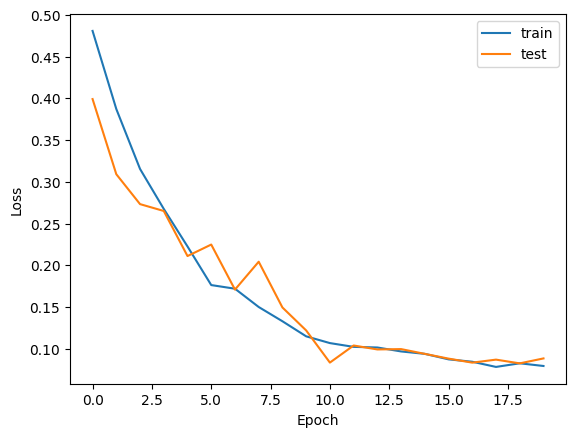

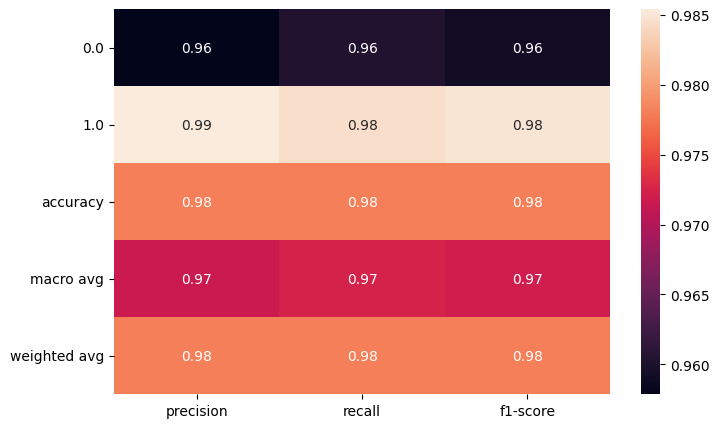

In [ ]:
model = InceptionModel(num_blocks=5, in_channels=1, out_channels=12,
                           bottleneck_channels=12, kernel_sizes=61, use_residuals=True,
                           num_pred_classes=2)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(20):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model(xb_test)
            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_test = torch.tensor(X_test).float()
y_val_pred = model(X_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_pt_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_inception = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_inception).iloc[:-1, :].T, annot=True)
plt.show()

##### Antrenare 2.0

Epoch 1, Train Loss: 0.4585, Test Loss: 0.3430
Epoch 2, Train Loss: 0.3310, Test Loss: 0.2856
Epoch 3, Train Loss: 0.2738, Test Loss: 0.2554
Epoch 4, Train Loss: 0.2432, Test Loss: 0.2671
Epoch 5, Train Loss: 0.2148, Test Loss: 0.1908
Epoch 6, Train Loss: 0.1906, Test Loss: 0.1759
Epoch 7, Train Loss: 0.1897, Test Loss: 0.1879
Epoch 8, Train Loss: 0.1730, Test Loss: 0.1618
Epoch 9, Train Loss: 0.1566, Test Loss: 0.1570
Epoch 10, Train Loss: 0.1438, Test Loss: 0.1417
Epoch 11, Train Loss: 0.1409, Test Loss: 0.1783
Epoch 12, Train Loss: 0.1426, Test Loss: 0.1276
Epoch 13, Train Loss: 129.2955, Test Loss: 0.7418
Epoch 14, Train Loss: 0.6155, Test Loss: 0.5291
Epoch 15, Train Loss: 0.5457, Test Loss: 0.5229
Epoch 16, Train Loss: 0.5231, Test Loss: 0.5030
Epoch 17, Train Loss: 0.5069, Test Loss: 0.4828
Epoch 18, Train Loss: 0.4951, Test Loss: 0.4559
Epoch 19, Train Loss: 0.4797, Test Loss: 0.4427
Epoch 20, Train Loss: 0.4638, Test Loss: 0.4448


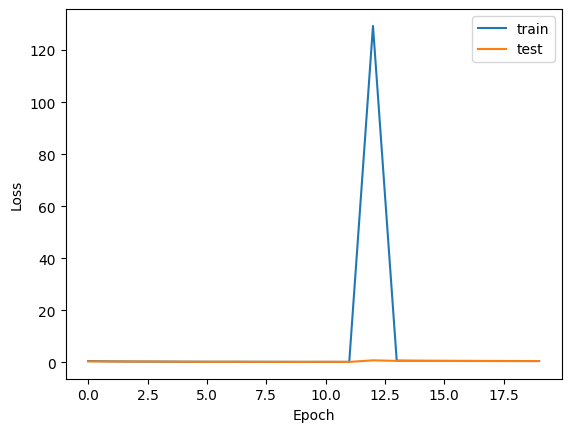

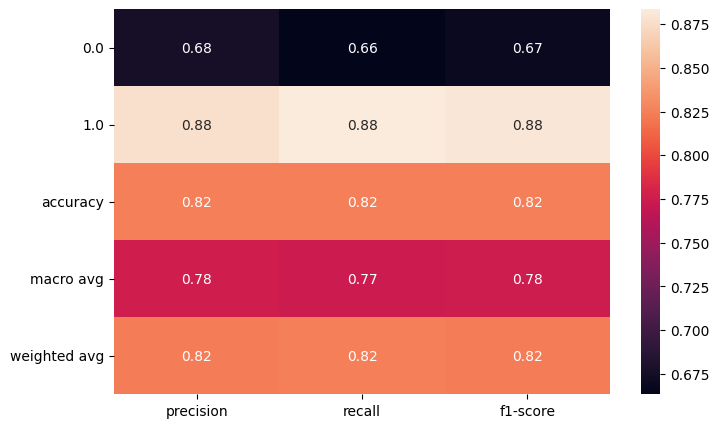

In [ ]:
model = InceptionModel(num_blocks=5, in_channels=1, out_channels=14,
                           bottleneck_channels=14, kernel_sizes=61, use_residuals=True,
                           num_pred_classes=2)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(20):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model(xb_test)
            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_test = torch.tensor(X_test).float()
y_val_pred = model(X_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_pt_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_inception = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_inception).iloc[:-1, :].T, annot=True)
plt.show()

##### Antrenare 3.0

Epoch 1, Train Loss: 0.4844, Test Loss: 0.4377
Epoch 2, Train Loss: 0.3662, Test Loss: 0.3002
Epoch 3, Train Loss: 0.2855, Test Loss: 0.2623
Epoch 4, Train Loss: 0.2609, Test Loss: 0.2521
Epoch 5, Train Loss: 0.2304, Test Loss: 0.2575
Epoch 6, Train Loss: 0.2128, Test Loss: 0.2005
Epoch 7, Train Loss: 0.1870, Test Loss: 0.1718
Epoch 8, Train Loss: 0.4611, Test Loss: 0.3223
Epoch 9, Train Loss: 0.2522, Test Loss: 0.2105
Epoch 10, Train Loss: 0.1835, Test Loss: 0.2041
Epoch 11, Train Loss: 0.1615, Test Loss: 0.1423
Epoch 12, Train Loss: 0.1486, Test Loss: 0.1464
Epoch 13, Train Loss: 0.1389, Test Loss: 0.1485
Epoch 14, Train Loss: 0.1328, Test Loss: 0.1218
Epoch 15, Train Loss: 0.1368, Test Loss: 0.1279
Epoch 16, Train Loss: 0.1254, Test Loss: 0.1100
Epoch 17, Train Loss: 0.1186, Test Loss: 0.1063
Epoch 18, Train Loss: 0.1003, Test Loss: 0.1387
Epoch 19, Train Loss: 0.0975, Test Loss: 0.0953
Epoch 20, Train Loss: 0.0977, Test Loss: 0.1426


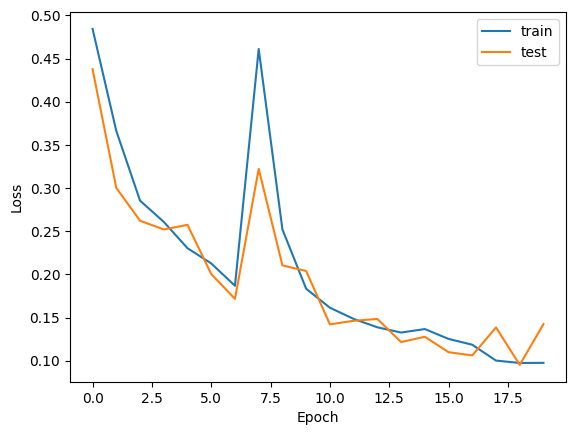

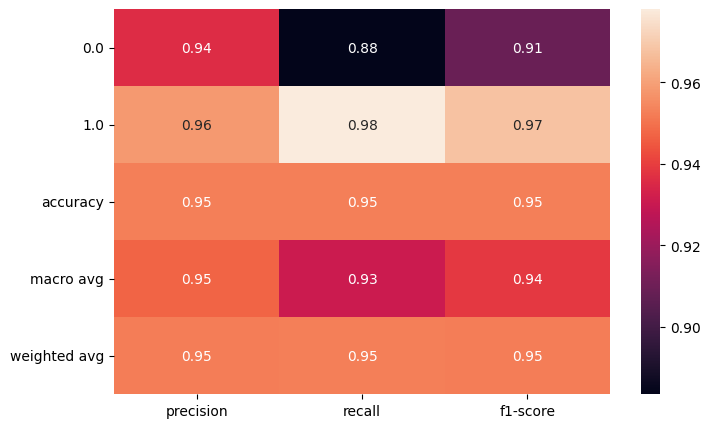

In [ ]:
model = InceptionModel(num_blocks=5, in_channels=1, out_channels=12,
                           bottleneck_channels=12, kernel_sizes=41, use_residuals=True,
                           num_pred_classes=2)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(20):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model(xb_test)
            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_test = torch.tensor(X_test).float()
y_val_pred = model(X_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_pt_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_inception = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_inception).iloc[:-1, :].T, annot=True)
plt.show()

#### Arhitectură de tip **InceptionTime 2.0**

In [ ]:
class Conv1dSamePadding(nn.Conv1d):
    """Represents the "Same" padding functionality from Tensorflow.
    See: https://github.com/pytorch/pytorch/issues/3867
    Note that the padding argument in the initializer doesn't do anything now
    """
    def forward(self, input):
        return conv1d_same_padding(input, self.weight, self.bias, self.stride,
                                   self.dilation, self.groups)


def conv1d_same_padding(input, weight, bias, stride, dilation, groups):
    # stride and dilation are expected to be tuples.
    kernel, dilation, stride = weight.size(2), dilation[0], stride[0]
    l_out = l_in = input.size(2)
    padding = (((l_out - 1) * stride) - l_in + (dilation * (kernel - 1)) + 1)
    if padding % 2 != 0:
        input = F.pad(input, [0, 1])

    return F.conv1d(input=input, weight=weight, bias=bias, stride=stride,
                    padding=padding // 2,
                    dilation=dilation, groups=groups)

class InceptionModel(nn.Module):
    """A PyTorch implementation of the InceptionTime model.
    From https://arxiv.org/abs/1909.04939
    Attributes
    ----------
    num_blocks:
        The number of inception blocks to use. One inception block consists
        of 3 convolutional layers, (optionally) a bottleneck and (optionally) a residual
        connector
    in_channels:
        The number of input channels (i.e. input.shape[-1])
    out_channels:
        The number of "hidden channels" to use. Can be a list (for each block) or an
        int, in which case the same value will be applied to each block
    bottleneck_channels:
        The number of channels to use for the bottleneck. Can be list or int. If 0, no
        bottleneck is applied
    kernel_sizes:
        The size of the kernels to use for each inception block. Within each block, each
        of the 3 convolutional layers will have kernel size
        `[kernel_size // (2 ** i) for i in range(3)]`
    num_pred_classes:
        The number of output classes
    """

    def __init__(self, num_blocks: int, in_channels: int, out_channels: Union[List[int], int],
                 bottleneck_channels: Union[List[int], int], kernel_sizes: Union[List[int], int],
                 use_residuals: Union[List[bool], bool, str] = 'default',
                 num_pred_classes: int = 1
                 ) -> None:
        super().__init__()

        # for easier saving and loading
        self.input_args = {
            'num_blocks': num_blocks,
            'in_channels': in_channels,
            'out_channels': out_channels,
            'bottleneck_channels': bottleneck_channels,
            'kernel_sizes': kernel_sizes,
            'use_residuals': use_residuals,
            'num_pred_classes': num_pred_classes
        }

        channels = [in_channels] + cast(List[int], self._expand_to_blocks(out_channels,
                                                                          num_blocks))
        bottleneck_channels = cast(List[int], self._expand_to_blocks(bottleneck_channels,
                                                                     num_blocks))
        kernel_sizes = cast(List[int], self._expand_to_blocks(kernel_sizes, num_blocks))
        if use_residuals == 'default':
            use_residuals = [True if i % 3 == 2 else False for i in range(num_blocks)]
        use_residuals = cast(List[bool], self._expand_to_blocks(
            cast(Union[bool, List[bool]], use_residuals), num_blocks)
        )

        self.blocks = nn.Sequential(*[
            InceptionBlock(in_channels=channels[i], out_channels=channels[i + 1],
                           residual=use_residuals[i], bottleneck_channels=bottleneck_channels[i],
                           kernel_size=kernel_sizes[i]) for i in range(num_blocks)
        ])

        # a global average pooling (i.e. mean of the time dimension) is why
        # in_features=channels[-1]
        self.linear = nn.Linear(in_features=channels[-1], out_features=num_pred_classes)

    @staticmethod
    def _expand_to_blocks(value: Union[int, bool, List[int], List[bool]],
                          num_blocks: int) -> Union[List[int], List[bool]]:
        if isinstance(value, list):
            assert len(value) == num_blocks, \
                f'Length of inputs lists must be the same as num blocks, ' \
                f'expected length {num_blocks}, got {len(value)}'
        else:
            value = [value] * num_blocks
        return value

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore
        x = self.blocks(x).mean(dim=-1)  # the mean is the global average pooling
        
        dropout = nn.Dropout(0.1);
        x = dropout(x)
        return self.linear(x)


class InceptionBlock(nn.Module):
    """An inception block consists of an (optional) bottleneck, followed
    by 3 conv1d layers. Optionally residual
    """

    def __init__(self, in_channels: int, out_channels: int,
                 residual: bool, stride: int = 1, bottleneck_channels: int = 32,
                 kernel_size: int = 41) -> None:
        assert kernel_size > 3, "Kernel size must be strictly greater than 3"
        super().__init__()

        self.use_bottleneck = bottleneck_channels > 0
        if self.use_bottleneck:
            self.bottleneck = Conv1dSamePadding(in_channels, bottleneck_channels,
                                                kernel_size=1, bias=False)
        kernel_size_s = [kernel_size // (2 ** i) for i in range(3)]
        start_channels = bottleneck_channels if self.use_bottleneck else in_channels
        channels = [start_channels] + [out_channels] * 3
        self.conv_layers = nn.Sequential(*[
            Conv1dSamePadding(in_channels=channels[i], out_channels=channels[i + 1],
                              kernel_size=kernel_size_s[i], stride=stride, bias=False)
            for i in range(len(kernel_size_s))
        ])

        self.batchnorm = nn.BatchNorm1d(num_features=channels[-1])
        self.relu = nn.ReLU()

        self.use_residual = residual
        if residual:
            self.residual = nn.Sequential(*[
                Conv1dSamePadding(in_channels=in_channels, out_channels=out_channels,
                                  kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels),
                nn.ReLU()
            ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore
        org_x = x
        if self.use_bottleneck:
            x = self.bottleneck(x)
        x = self.conv_layers(x)

        if self.use_residual:
            x = x + self.residual(org_x)

        return x

##### Antrenare

Epoch 1, Train Loss: 0.4863, Test Loss: 0.4153
Epoch 2, Train Loss: 0.3887, Test Loss: 0.3738
Epoch 3, Train Loss: 0.3294, Test Loss: 0.3183
Epoch 4, Train Loss: 0.2818, Test Loss: 0.2860
Epoch 5, Train Loss: 0.2406, Test Loss: 0.1938
Epoch 6, Train Loss: 0.2151, Test Loss: 0.2479
Epoch 7, Train Loss: 0.1960, Test Loss: 0.1973
Epoch 8, Train Loss: 0.1818, Test Loss: 0.1692
Epoch 9, Train Loss: 0.1806, Test Loss: 0.1716
Epoch 10, Train Loss: 0.1595, Test Loss: 0.1706
Epoch 11, Train Loss: 0.1468, Test Loss: 0.1630
Epoch 12, Train Loss: 0.1395, Test Loss: 0.1536
Epoch 13, Train Loss: 0.1328, Test Loss: 0.1433
Epoch 14, Train Loss: 0.1237, Test Loss: 0.2246
Epoch 15, Train Loss: 0.1176, Test Loss: 0.1267
Epoch 16, Train Loss: 0.1227, Test Loss: 0.1129
Epoch 17, Train Loss: 0.1132, Test Loss: 0.1265
Epoch 18, Train Loss: 0.1093, Test Loss: 0.1303
Epoch 19, Train Loss: 0.1090, Test Loss: 0.1195
Epoch 20, Train Loss: 0.0973, Test Loss: 0.0969


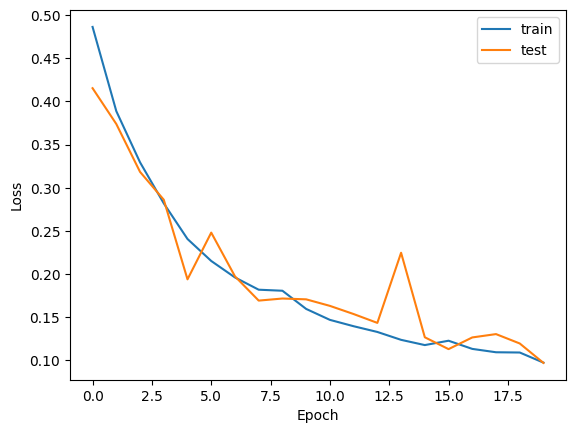

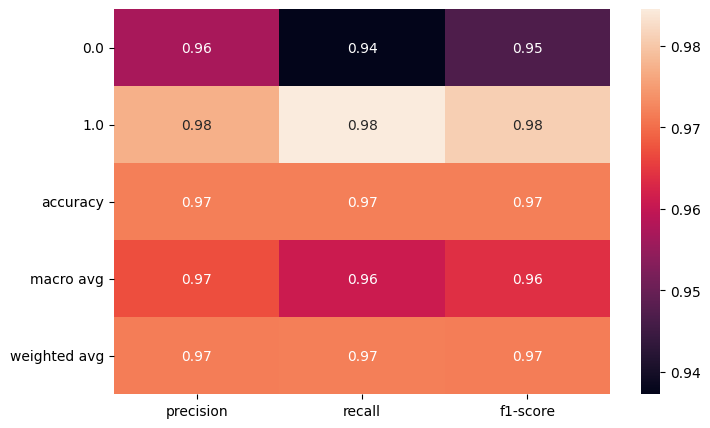

In [ ]:
model = InceptionModel(num_blocks=5, in_channels=1, out_channels=12,
                           bottleneck_channels=12, kernel_sizes=61, use_residuals=True,
                           num_pred_classes=2)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(20):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model(xb_test)
            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_test = torch.tensor(X_test).float()
y_val_pred = model(X_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_pt_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_inception = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_inception).iloc[:-1, :].T, annot=True)
plt.show()

##### Antrenare 2.0

Epoch 1, Train Loss: 0.6113, Test Loss: 0.4857
Epoch 2, Train Loss: 0.4653, Test Loss: 0.3941
Epoch 3, Train Loss: 0.4146, Test Loss: 0.3776
Epoch 4, Train Loss: 0.3717, Test Loss: 0.3255
Epoch 5, Train Loss: 0.3494, Test Loss: 0.3824
Epoch 6, Train Loss: 0.3122, Test Loss: 0.2801
Epoch 7, Train Loss: 0.2926, Test Loss: 0.2696
Epoch 8, Train Loss: 0.2725, Test Loss: 0.2877
Epoch 9, Train Loss: 0.2620, Test Loss: 0.2305
Epoch 10, Train Loss: 0.2413, Test Loss: 0.2511
Epoch 11, Train Loss: 0.2316, Test Loss: 0.2087
Epoch 12, Train Loss: 0.2087, Test Loss: 0.2507
Epoch 13, Train Loss: 0.1976, Test Loss: 0.2170
Epoch 14, Train Loss: 0.1977, Test Loss: 0.1818
Epoch 15, Train Loss: 0.1829, Test Loss: 0.1836
Epoch 16, Train Loss: 0.1740, Test Loss: 0.1880
Epoch 17, Train Loss: 0.1486, Test Loss: 0.1834
Epoch 18, Train Loss: 0.1516, Test Loss: 0.1485
Epoch 19, Train Loss: 0.1451, Test Loss: 0.1678
Epoch 20, Train Loss: 0.1214, Test Loss: 0.1392
Epoch 21, Train Loss: 0.1130, Test Loss: 0.1429
E

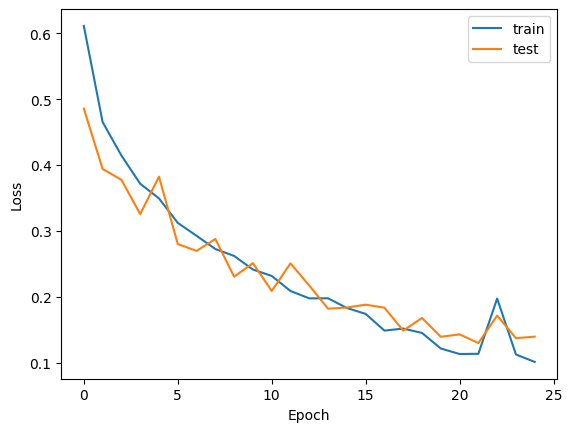

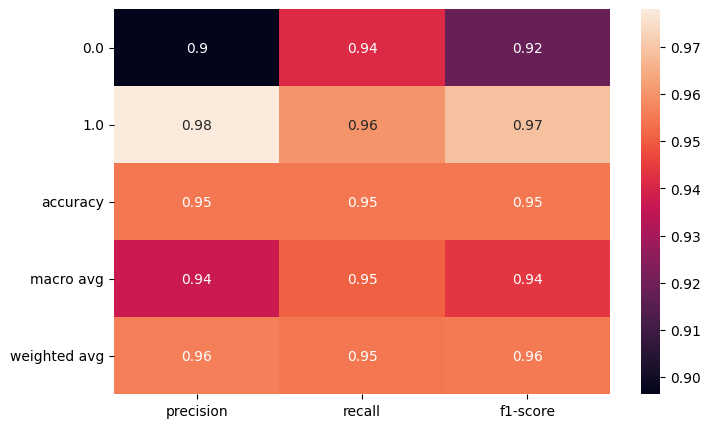

In [ ]:
model = InceptionModel(num_blocks=5, in_channels=1, out_channels=14,
                           bottleneck_channels=14, kernel_sizes=61, use_residuals=True,
                           num_pred_classes=2)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(25):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model(xb_test)
            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_test = torch.tensor(X_test).float()
y_val_pred = model(X_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_pt_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_inception = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_inception).iloc[:-1, :].T, annot=True)
plt.show()

###### Batch_size = 16

In [ ]:
train_ds = TensorDataset(X_train, y_pt_train_encoded)
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)

test_ds = TensorDataset(X_test, y_pt_test_encoded)
test_dl = DataLoader(test_ds, batch_size=16, shuffle=True)

In [ ]:
for xb, yb in train_dl:
  print(xb, xb.size(), yb, yb.size())
  break

tensor([[[0.2855, 0.2939, 0.2769,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.1712, 0.1518, 0.2174,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0637, 0.1280, 0.1272,  ..., 0.0000, 0.0000, 0.0000]],

        ...,

        [[0.2104, 0.2884, 0.3137,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.1419, 0.1557, 0.1477,  ..., 0.0000, 0.0000, 0.0000]],

        [[1.0000, 0.9792, 0.9272,  ..., 0.0000, 0.0000, 0.0000]]]) torch.Size([16, 1, 178]) tensor([[0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]]) torch.Size([16, 2])


Epoch 1, Train Loss: 0.5307, Test Loss: 0.4611
Epoch 2, Train Loss: 0.4213, Test Loss: 0.3423
Epoch 3, Train Loss: 0.3584, Test Loss: 0.3131
Epoch 4, Train Loss: 0.3115, Test Loss: 0.2739
Epoch 5, Train Loss: 0.2816, Test Loss: 0.2468
Epoch 6, Train Loss: 0.2503, Test Loss: 0.2329
Epoch 7, Train Loss: 0.2294, Test Loss: 0.2308
Epoch 8, Train Loss: 0.2163, Test Loss: 0.2071
Epoch 9, Train Loss: 0.1997, Test Loss: 0.2070
Epoch 10, Train Loss: 0.1935, Test Loss: 0.1836
Epoch 11, Train Loss: 0.1853, Test Loss: 0.1955
Epoch 12, Train Loss: 0.1753, Test Loss: 0.1593
Epoch 13, Train Loss: 0.1698, Test Loss: 0.2029
Epoch 14, Train Loss: 0.1600, Test Loss: 0.1714
Epoch 15, Train Loss: 0.1580, Test Loss: 0.4619
Epoch 16, Train Loss: 0.1523, Test Loss: 0.1411
Epoch 17, Train Loss: 0.1488, Test Loss: 0.1605
Epoch 18, Train Loss: 0.9281, Test Loss: 0.5152
Epoch 19, Train Loss: 0.4736, Test Loss: 0.3793
Epoch 20, Train Loss: 0.2581, Test Loss: 0.2195
Epoch 21, Train Loss: 0.1460, Test Loss: 0.1480
E

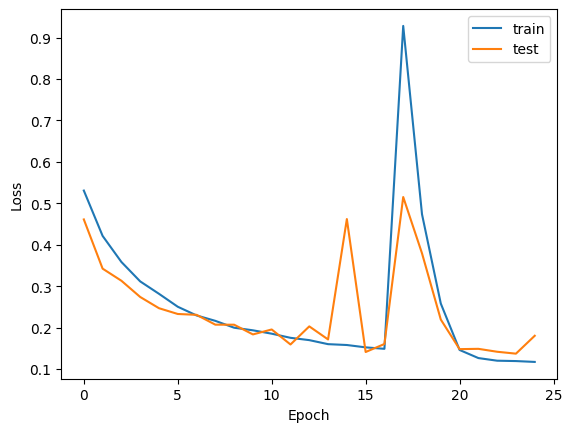

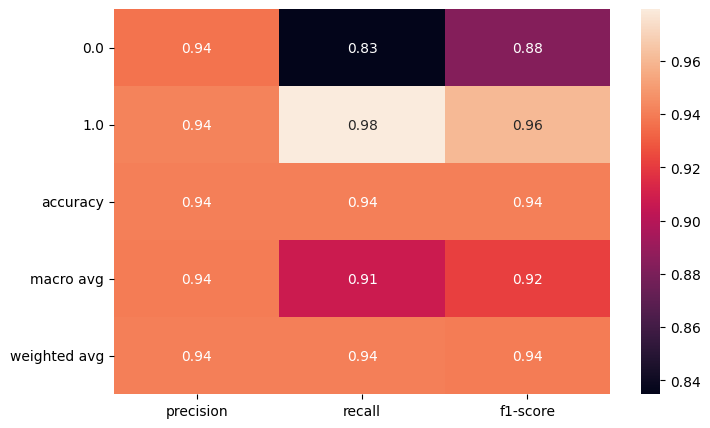

In [ ]:
model = InceptionModel(num_blocks=5, in_channels=1, out_channels=12,
                           bottleneck_channels=12, kernel_sizes=61, use_residuals=True,
                           num_pred_classes=2)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(25):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model(xb_test)
            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_test = torch.tensor(X_test).float()
y_val_pred = model(X_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_pt_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_inception = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_inception).iloc[:-1, :].T, annot=True)
plt.show()

###### Batch_size = 128

In [ ]:
train_ds = TensorDataset(X_train, y_pt_train_encoded)
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)

test_ds = TensorDataset(X_test, y_pt_test_encoded)
test_dl = DataLoader(test_ds, batch_size=128, shuffle=True)

In [ ]:
for xb, yb in train_dl:
  print(xb, xb.size(), yb, yb.size())
  break

tensor([[[0.1398, 0.1760, 0.1621,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0865, 0.0665, 0.0605,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.1964, 0.2086, 0.1966,  ..., 0.0000, 0.0000, 0.0000]],

        ...,

        [[0.0000, 0.0534, 0.1115,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.1949, 0.2502, 0.2716,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.2149, 0.2686, 0.2854,  ..., 0.0000, 0.0000, 0.0000]]]) torch.Size([128, 1, 178]) tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],


Epoch 1, Train Loss: 0.4689, Test Loss: 0.4346
Epoch 2, Train Loss: 0.4012, Test Loss: 0.3446
Epoch 3, Train Loss: 0.3312, Test Loss: 0.3090
Epoch 4, Train Loss: 0.2860, Test Loss: 0.2773
Epoch 5, Train Loss: 0.2335, Test Loss: 0.2075
Epoch 6, Train Loss: 0.2104, Test Loss: 0.2275
Epoch 7, Train Loss: 0.1929, Test Loss: 0.1846
Epoch 8, Train Loss: 0.1781, Test Loss: 0.1577
Epoch 9, Train Loss: 0.1797, Test Loss: 0.1731
Epoch 10, Train Loss: 0.1632, Test Loss: 0.1577
Epoch 11, Train Loss: 0.1443, Test Loss: 0.1411
Epoch 12, Train Loss: 0.1396, Test Loss: 0.1770
Epoch 13, Train Loss: 0.1385, Test Loss: 0.1452
Epoch 14, Train Loss: 0.1349, Test Loss: 0.1319
Epoch 15, Train Loss: 0.1160, Test Loss: 0.1170
Epoch 16, Train Loss: 0.1336, Test Loss: 0.1389
Epoch 17, Train Loss: 0.1222, Test Loss: 0.1581
Epoch 18, Train Loss: 0.1170, Test Loss: 0.1254
Epoch 19, Train Loss: 0.0995, Test Loss: 0.1069
Epoch 20, Train Loss: 0.0959, Test Loss: 0.1209
Epoch 21, Train Loss: 0.1049, Test Loss: 0.1377
E

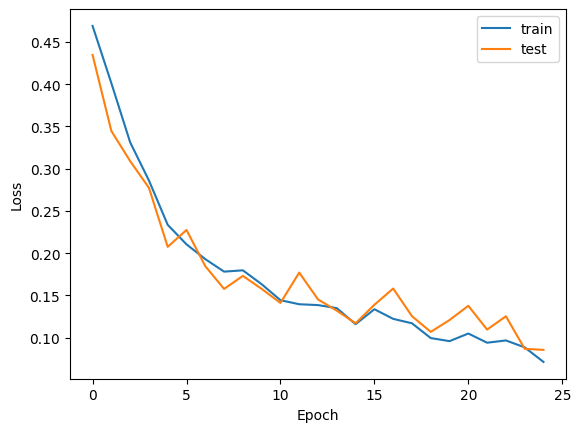

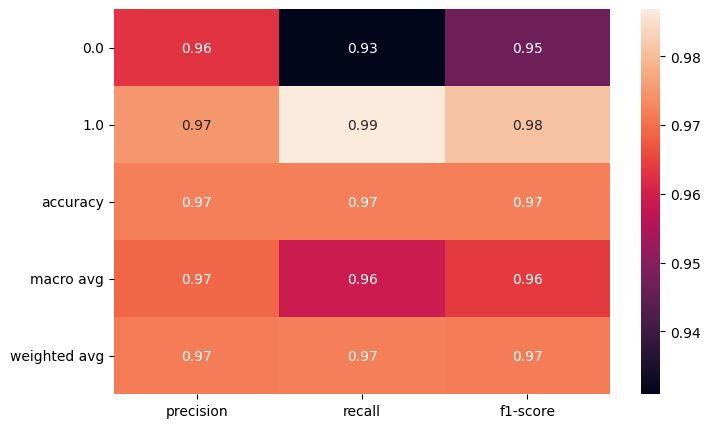

In [ ]:
model = InceptionModel(num_blocks=5, in_channels=1, out_channels=12,
                           bottleneck_channels=12, kernel_sizes=61, use_residuals=True,
                           num_pred_classes=2)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(25):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model(xb_test)
            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_test = torch.tensor(X_test).float()
y_val_pred = model(X_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_pt_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_inception = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_inception).iloc[:-1, :].T, annot=True)
plt.show()

#### Arhitectură de tip **InceptionTime 3.0**

In [ ]:
train_ds = TensorDataset(X_train, y_pt_train_encoded)
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)

test_ds = TensorDataset(X_test, y_pt_test_encoded)
test_dl = DataLoader(test_ds, batch_size=128, shuffle=True)

In [ ]:
class Conv1dSamePadding(nn.Conv1d):
    """Represents the "Same" padding functionality from Tensorflow.
    See: https://github.com/pytorch/pytorch/issues/3867
    Note that the padding argument in the initializer doesn't do anything now
    """
    def forward(self, input):
        return conv1d_same_padding(input, self.weight, self.bias, self.stride,
                                   self.dilation, self.groups)


def conv1d_same_padding(input, weight, bias, stride, dilation, groups):
    # stride and dilation are expected to be tuples.
    kernel, dilation, stride = weight.size(2), dilation[0], stride[0]
    l_out = l_in = input.size(2)
    padding = (((l_out - 1) * stride) - l_in + (dilation * (kernel - 1)) + 1)
    if padding % 2 != 0:
        input = F.pad(input, [0, 1])

    return F.conv1d(input=input, weight=weight, bias=bias, stride=stride,
                    padding=padding // 2,
                    dilation=dilation, groups=groups)

class InceptionModel(nn.Module):
    """A PyTorch implementation of the InceptionTime model.
    From https://arxiv.org/abs/1909.04939
    Attributes
    ----------
    num_blocks:
        The number of inception blocks to use. One inception block consists
        of 3 convolutional layers, (optionally) a bottleneck and (optionally) a residual
        connector
    in_channels:
        The number of input channels (i.e. input.shape[-1])
    out_channels:
        The number of "hidden channels" to use. Can be a list (for each block) or an
        int, in which case the same value will be applied to each block
    bottleneck_channels:
        The number of channels to use for the bottleneck. Can be list or int. If 0, no
        bottleneck is applied
    kernel_sizes:
        The size of the kernels to use for each inception block. Within each block, each
        of the 3 convolutional layers will have kernel size
        `[kernel_size // (2 ** i) for i in range(3)]`
    num_pred_classes:
        The number of output classes
    """

    def __init__(self, num_blocks: int, in_channels: int, out_channels: Union[List[int], int],
                 bottleneck_channels: Union[List[int], int], kernel_sizes: Union[List[int], int],
                 use_residuals: Union[List[bool], bool, str] = 'default',
                 num_pred_classes: int = 1
                 ) -> None:
        super().__init__()

        # for easier saving and loading
        self.input_args = {
            'num_blocks': num_blocks,
            'in_channels': in_channels,
            'out_channels': out_channels,
            'bottleneck_channels': bottleneck_channels,
            'kernel_sizes': kernel_sizes,
            'use_residuals': use_residuals,
            'num_pred_classes': num_pred_classes
        }

        channels = [in_channels] + cast(List[int], self._expand_to_blocks(out_channels,
                                                                          num_blocks))
        bottleneck_channels = cast(List[int], self._expand_to_blocks(bottleneck_channels,
                                                                     num_blocks))
        kernel_sizes = cast(List[int], self._expand_to_blocks(kernel_sizes, num_blocks))
        if use_residuals == 'default':
            use_residuals = [True if i % 3 == 2 else False for i in range(num_blocks)]
        use_residuals = cast(List[bool], self._expand_to_blocks(
            cast(Union[bool, List[bool]], use_residuals), num_blocks)
        )

        self.blocks = nn.Sequential(*[
            InceptionBlock(in_channels=channels[i], out_channels=channels[i + 1],
                           residual=use_residuals[i], bottleneck_channels=bottleneck_channels[i],
                           kernel_size=kernel_sizes[i]) for i in range(num_blocks)
        ])

        # a global average pooling (i.e. mean of the time dimension) is why
        # in_features=channels[-1]
        self.fc1 = nn.Linear(channels[-1], 128)
        self.fc2 = nn.Linear(128, 64)        
        self.fc3 = nn.Linear(64, 48)        
        self.fc4 = nn.Linear(48, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 2)
        #self.linear = nn.Linear(in_features=, out_features=num_pred_classes)

    @staticmethod
    def _expand_to_blocks(value: Union[int, bool, List[int], List[bool]],
                          num_blocks: int) -> Union[List[int], List[bool]]:
        if isinstance(value, list):
            assert len(value) == num_blocks, \
                f'Length of inputs lists must be the same as num blocks, ' \
                f'expected length {num_blocks}, got {len(value)}'
        else:
            value = [value] * num_blocks
        return value

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore
        x = self.blocks(x).mean(dim=-1)  # the mean is the global average pooling
        
        dropout = nn.Dropout(0.1);
        x = dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x


class InceptionBlock(nn.Module):
    """An inception block consists of an (optional) bottleneck, followed
    by 3 conv1d layers. Optionally residual
    """

    def __init__(self, in_channels: int, out_channels: int,
                 residual: bool, stride: int = 1, bottleneck_channels: int = 32,
                 kernel_size: int = 41) -> None:
        assert kernel_size > 3, "Kernel size must be strictly greater than 3"
        super().__init__()

        self.use_bottleneck = bottleneck_channels > 0
        if self.use_bottleneck:
            self.bottleneck = Conv1dSamePadding(in_channels, bottleneck_channels,
                                                kernel_size=1, bias=False)
        kernel_size_s = [kernel_size // (2 ** i) for i in range(3)]
        start_channels = bottleneck_channels if self.use_bottleneck else in_channels
        channels = [start_channels] + [out_channels] * 3
        self.conv_layers = nn.Sequential(*[
            Conv1dSamePadding(in_channels=channels[i], out_channels=channels[i + 1],
                              kernel_size=kernel_size_s[i], stride=stride, bias=False)
            for i in range(len(kernel_size_s))
        ])

        self.batchnorm = nn.BatchNorm1d(num_features=channels[-1])
        self.relu = nn.ReLU()

        self.use_residual = residual
        if residual:
            self.residual = nn.Sequential(*[
                Conv1dSamePadding(in_channels=in_channels, out_channels=out_channels,
                                  kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels),
                nn.ReLU()
            ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore
        org_x = x
        if self.use_bottleneck:
            x = self.bottleneck(x)
        x = self.conv_layers(x)

        if self.use_residual:
            x = x + self.residual(org_x)

        return x

##### Antrenare

Epoch 1, Train Loss: 0.5495, Test Loss: 0.4766
Epoch 2, Train Loss: 0.4517, Test Loss: 0.4071
Epoch 3, Train Loss: 0.4123, Test Loss: 0.4068
Epoch 4, Train Loss: 0.3875, Test Loss: 0.3554
Epoch 5, Train Loss: 0.3626, Test Loss: 0.3508
Epoch 6, Train Loss: 0.3471, Test Loss: 0.3074
Epoch 7, Train Loss: 0.3015, Test Loss: 0.2716
Epoch 8, Train Loss: 0.2859, Test Loss: 0.2734
Epoch 9, Train Loss: 0.2800, Test Loss: 0.2268
Epoch 10, Train Loss: 0.2384, Test Loss: 0.2414
Epoch 11, Train Loss: 0.2228, Test Loss: 0.2131
Epoch 12, Train Loss: 0.1965, Test Loss: 0.2341
Epoch 13, Train Loss: 0.2046, Test Loss: 0.2253
Epoch 14, Train Loss: 0.1923, Test Loss: 0.1885
Epoch 15, Train Loss: 0.1736, Test Loss: 0.1623
Epoch 16, Train Loss: 0.1669, Test Loss: 0.1629
Epoch 17, Train Loss: 0.1465, Test Loss: 0.1657
Epoch 18, Train Loss: 0.1511, Test Loss: 0.1294
Epoch 19, Train Loss: 0.1528, Test Loss: 0.1381
Epoch 20, Train Loss: 0.1446, Test Loss: 0.1787
Epoch 21, Train Loss: 0.1470, Test Loss: 0.1533
E

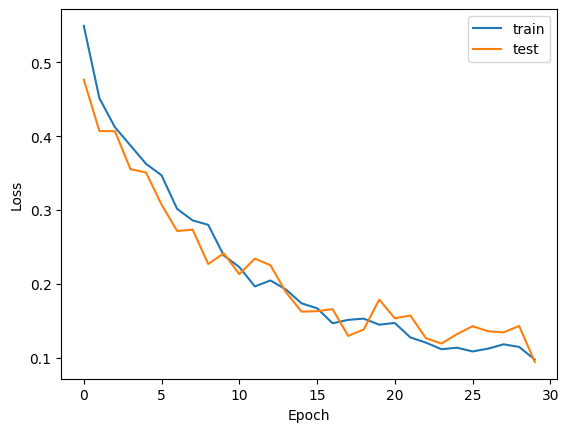

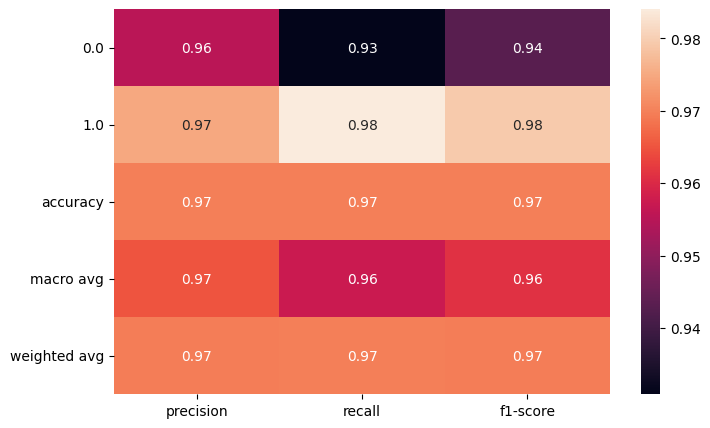

In [ ]:
model = InceptionModel(num_blocks=5, in_channels=1, out_channels=12,
                           bottleneck_channels=12, kernel_sizes=61, use_residuals=True,
                           num_pred_classes=2)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(30):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model(xb_test)
            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_test = torch.tensor(X_test).float()
y_val_pred = model(X_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_pt_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_inception = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_inception).iloc[:-1, :].T, annot=True)
plt.show()

#### Arhitectură de tip **LSTM**

In [ ]:
class ComplexLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(ComplexLSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        # Initialize the hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward pass through the LSTM layer
        out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # Pass the final hidden state through Linear layers
        out = self.fc1(hn[-1])
        out = self.fc2(out)
        
        return out

##### Antrenare

###### Batch_size = 256

In [ ]:
train_ds = TensorDataset(X_train, y_pt_train_encoded)
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)

test_ds = TensorDataset(X_test, y_pt_test_encoded)
test_dl = DataLoader(test_ds, batch_size=256, shuffle=True)

Epoch 1, Train Loss: 0.5876, Test Loss: 0.5280
Epoch 2, Train Loss: 0.5021, Test Loss: 0.4621
Epoch 3, Train Loss: 0.4619, Test Loss: 0.4386
Epoch 4, Train Loss: 0.4450, Test Loss: 0.4316
Epoch 5, Train Loss: 0.4320, Test Loss: 0.4145
Epoch 6, Train Loss: 0.4178, Test Loss: 0.4094
Epoch 7, Train Loss: 0.4124, Test Loss: 0.4012
Epoch 8, Train Loss: 0.4030, Test Loss: 0.4012
Epoch 9, Train Loss: 0.3960, Test Loss: 0.3970
Epoch 10, Train Loss: 0.3892, Test Loss: 0.3813
Epoch 11, Train Loss: 0.3871, Test Loss: 0.3794
Epoch 12, Train Loss: 0.3788, Test Loss: 0.3711
Epoch 13, Train Loss: 0.3766, Test Loss: 0.3898
Epoch 14, Train Loss: 0.3719, Test Loss: 0.3640
Epoch 15, Train Loss: 0.3659, Test Loss: 0.3616
Epoch 16, Train Loss: 0.3621, Test Loss: 0.3545
Epoch 17, Train Loss: 0.3591, Test Loss: 0.3519
Epoch 18, Train Loss: 0.3510, Test Loss: 0.3490
Epoch 19, Train Loss: 0.3445, Test Loss: 0.3513
Epoch 20, Train Loss: 0.3439, Test Loss: 0.3352
Epoch 21, Train Loss: 0.3379, Test Loss: 0.3573
E

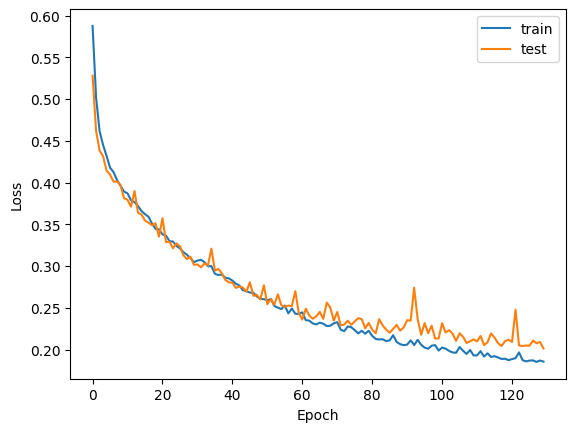

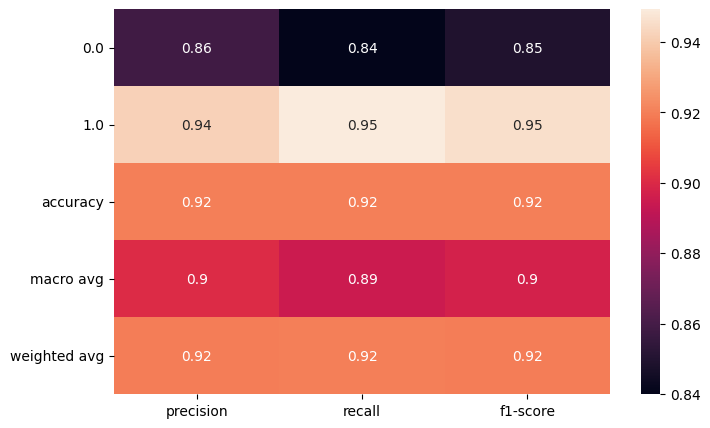

In [ ]:
model = ComplexLSTM(input_size = 178, hidden_size = 50, num_layers = 1, output_size = 2)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(130):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        yb_pred = model(xb)

        loss = criterion(yb_pred, yb)
        epoch_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model(xb_test)
            
            yb_pred_test = yb_pred_test.squeeze(1).float()

            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_test = torch.tensor(X_test).float()
y_val_pred = model(X_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_pt_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_lstm = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_lstm).iloc[:-1, :].T, annot=True)
plt.show()

###### Batch_size = 64

In [ ]:
train_ds = TensorDataset(X_train, y_pt_train_encoded)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

test_ds = TensorDataset(X_test, y_pt_test_encoded)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=True)

Epoch 1, Train Loss: 0.5223, Test Loss: 0.4412
Epoch 2, Train Loss: 0.4340, Test Loss: 0.4099
Epoch 3, Train Loss: 0.4073, Test Loss: 0.3894
Epoch 4, Train Loss: 0.3917, Test Loss: 0.3769
Epoch 5, Train Loss: 0.3835, Test Loss: 0.3683
Epoch 6, Train Loss: 0.3707, Test Loss: 0.3749
Epoch 7, Train Loss: 0.3631, Test Loss: 0.3507
Epoch 8, Train Loss: 0.3516, Test Loss: 0.3455
Epoch 9, Train Loss: 0.3437, Test Loss: 0.3391
Epoch 10, Train Loss: 0.3385, Test Loss: 0.3282
Epoch 11, Train Loss: 0.3326, Test Loss: 0.3342
Epoch 12, Train Loss: 0.3240, Test Loss: 0.3173
Epoch 13, Train Loss: 0.3120, Test Loss: 0.3038
Epoch 14, Train Loss: 0.3051, Test Loss: 0.3012
Epoch 15, Train Loss: 0.2978, Test Loss: 0.2947
Epoch 16, Train Loss: 0.2985, Test Loss: 0.2907
Epoch 17, Train Loss: 0.2916, Test Loss: 0.2845
Epoch 18, Train Loss: 0.2889, Test Loss: 0.2799
Epoch 19, Train Loss: 0.2800, Test Loss: 0.2775
Epoch 20, Train Loss: 0.2813, Test Loss: 0.3081
Epoch 21, Train Loss: 0.2700, Test Loss: 0.2781
E

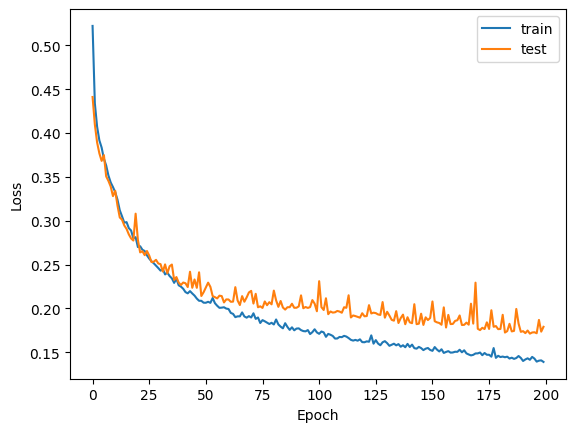

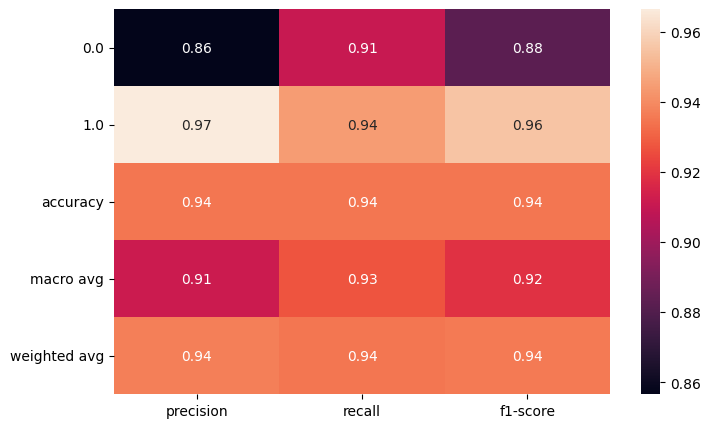

In [ ]:
model = ComplexLSTM(input_size = 178, hidden_size = 50, num_layers = 1, output_size = 2)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(200):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        yb_pred = model(xb)

        loss = criterion(yb_pred, yb)
        epoch_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model(xb_test)
            
            yb_pred_test = yb_pred_test.squeeze(1).float()

            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_test = torch.tensor(X_test).float()
y_val_pred = model(X_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_pt_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_lstm = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_lstm).iloc[:-1, :].T, annot=True)
plt.show()

###### Batch_size = 512

In [ ]:
train_ds = TensorDataset(X_train, y_pt_train_encoded)
train_dl = DataLoader(train_ds, batch_size=512, shuffle=True)

test_ds = TensorDataset(X_test, y_pt_test_encoded)
test_dl = DataLoader(test_ds, batch_size=512, shuffle=True)

Epoch 1, Train Loss: 0.6242, Test Loss: 0.5661
Epoch 2, Train Loss: 0.5628, Test Loss: 0.5344
Epoch 3, Train Loss: 0.5243, Test Loss: 0.4901
Epoch 4, Train Loss: 0.4903, Test Loss: 0.4631
Epoch 5, Train Loss: 0.4649, Test Loss: 0.4441
Epoch 6, Train Loss: 0.4462, Test Loss: 0.4294
Epoch 7, Train Loss: 0.4344, Test Loss: 0.4208
Epoch 8, Train Loss: 0.4245, Test Loss: 0.4184
Epoch 9, Train Loss: 0.4192, Test Loss: 0.4062
Epoch 10, Train Loss: 0.4108, Test Loss: 0.4033
Epoch 11, Train Loss: 0.4048, Test Loss: 0.3943
Epoch 12, Train Loss: 0.3985, Test Loss: 0.3940
Epoch 13, Train Loss: 0.3962, Test Loss: 0.3870
Epoch 14, Train Loss: 0.3900, Test Loss: 0.3885
Epoch 15, Train Loss: 0.3866, Test Loss: 0.3823
Epoch 16, Train Loss: 0.3830, Test Loss: 0.3897
Epoch 17, Train Loss: 0.3789, Test Loss: 0.3750
Epoch 18, Train Loss: 0.3736, Test Loss: 0.3732
Epoch 19, Train Loss: 0.3706, Test Loss: 0.3766
Epoch 20, Train Loss: 0.3661, Test Loss: 0.3663
Epoch 21, Train Loss: 0.3622, Test Loss: 0.3648
E

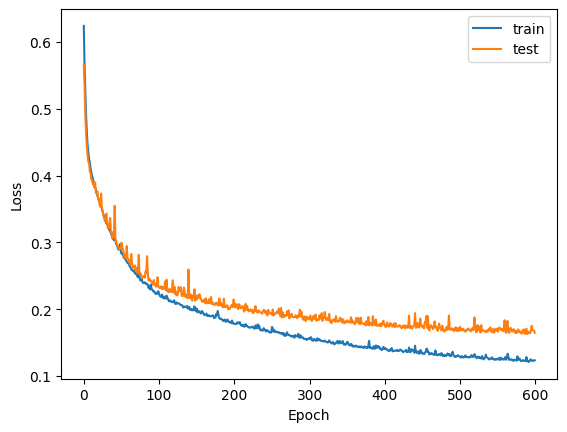

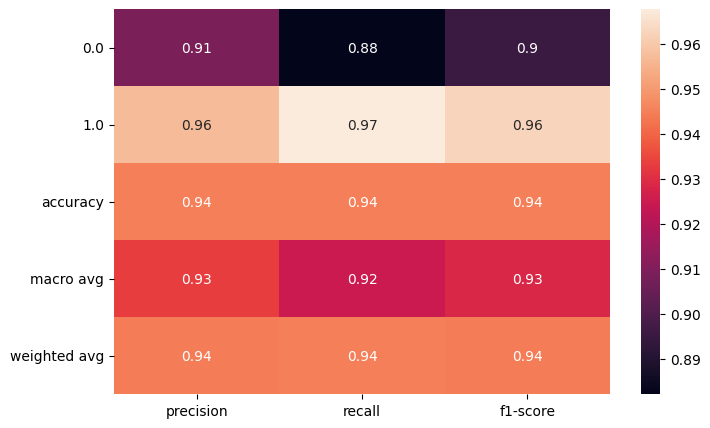

In [ ]:
model = ComplexLSTM(input_size = 178, hidden_size = 50, num_layers = 1, output_size = 2)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(600):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        yb_pred = model(xb)

        loss = criterion(yb_pred, yb)
        epoch_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model(xb_test)
            
            yb_pred_test = yb_pred_test.squeeze(1).float()

            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_test = torch.tensor(X_test).float()
y_val_pred = model(X_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_pt_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_lstm = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_lstm).iloc[:-1, :].T, annot=True)
plt.show()

##### Antrenare 2.0

In [ ]:
train_ds = TensorDataset(X_train, y_pt_train_encoded)
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)

test_ds = TensorDataset(X_test, y_pt_test_encoded)
test_dl = DataLoader(test_ds, batch_size=256, shuffle=True)

Epoch 1, Train Loss: 0.5919, Test Loss: 0.5217
Epoch 2, Train Loss: 0.5017, Test Loss: 0.4664
Epoch 3, Train Loss: 0.4569, Test Loss: 0.4350
Epoch 4, Train Loss: 0.4388, Test Loss: 0.4302
Epoch 5, Train Loss: 0.4257, Test Loss: 0.4141
Epoch 6, Train Loss: 0.4173, Test Loss: 0.4047
Epoch 7, Train Loss: 0.4058, Test Loss: 0.3955
Epoch 8, Train Loss: 0.4021, Test Loss: 0.3953
Epoch 9, Train Loss: 0.3950, Test Loss: 0.4094
Epoch 10, Train Loss: 0.3882, Test Loss: 0.3870
Epoch 11, Train Loss: 0.3834, Test Loss: 0.3791
Epoch 12, Train Loss: 0.3786, Test Loss: 0.3735
Epoch 13, Train Loss: 0.3732, Test Loss: 0.3710
Epoch 14, Train Loss: 0.3684, Test Loss: 0.3686
Epoch 15, Train Loss: 0.3615, Test Loss: 0.3582
Epoch 16, Train Loss: 0.3616, Test Loss: 0.3572
Epoch 17, Train Loss: 0.3558, Test Loss: 0.3523
Epoch 18, Train Loss: 0.3521, Test Loss: 0.3516
Epoch 19, Train Loss: 0.3447, Test Loss: 0.3520
Epoch 20, Train Loss: 0.3416, Test Loss: 0.3361
Epoch 21, Train Loss: 0.3378, Test Loss: 0.3376
E

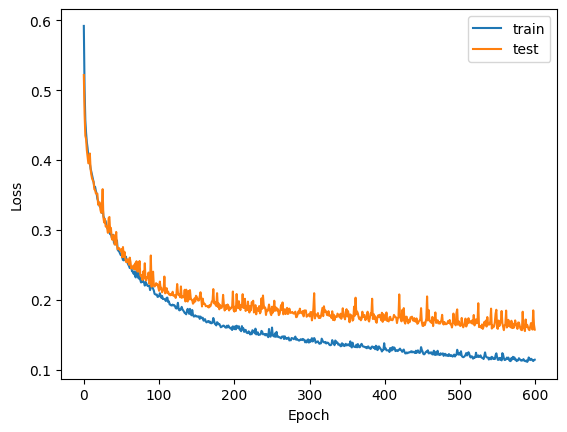

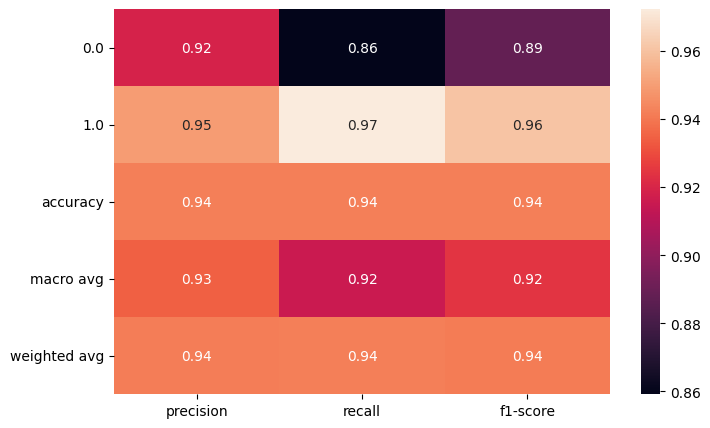

In [ ]:
model = ComplexLSTM(input_size = 178, hidden_size = 100, num_layers = 1, output_size = 2)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(600):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        yb_pred = model(xb)

        loss = criterion(yb_pred, yb)
        epoch_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model(xb_test)
            
            yb_pred_test = yb_pred_test.squeeze(1).float()

            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_test = torch.tensor(X_test).float()
y_val_pred = model(X_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_pt_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_lstm = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_lstm).iloc[:-1, :].T, annot=True)
plt.show()

#### Arhitectură de tip **LSTM 2.0**

In [ ]:
class ComplexLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(ComplexLSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, output_size)
        # dropout
        self.dropout = nn.Dropout(0.1)
        
        # ReLU activation
        self.relu = nn.ReLU()

    def forward(self, x):
        # Initialize the hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward pass through the LSTM layer
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.relu(out)
        # Pass the final hidden state through Linear layers
        out = self.fc1(hn[-1])
        out = self.fc2(out)

        return out

##### Antrenare

Epoch 1, Train Loss: 0.5724, Test Loss: 0.4884
Epoch 2, Train Loss: 0.4713, Test Loss: 0.4420
Epoch 3, Train Loss: 0.4303, Test Loss: 0.4257
Epoch 4, Train Loss: 0.4158, Test Loss: 0.4001
Epoch 5, Train Loss: 0.3953, Test Loss: 0.3826
Epoch 6, Train Loss: 0.3846, Test Loss: 0.3902
Epoch 7, Train Loss: 0.3774, Test Loss: 0.3663
Epoch 8, Train Loss: 0.3650, Test Loss: 0.3621
Epoch 9, Train Loss: 0.3584, Test Loss: 0.3545
Epoch 10, Train Loss: 0.3490, Test Loss: 0.3426
Epoch 11, Train Loss: 0.3419, Test Loss: 0.3366
Epoch 12, Train Loss: 0.3364, Test Loss: 0.3322
Epoch 13, Train Loss: 0.3326, Test Loss: 0.3256
Epoch 14, Train Loss: 0.3217, Test Loss: 0.3294
Epoch 15, Train Loss: 0.3165, Test Loss: 0.3180
Epoch 16, Train Loss: 0.3125, Test Loss: 0.3402
Epoch 17, Train Loss: 0.3121, Test Loss: 0.3067
Epoch 18, Train Loss: 0.2990, Test Loss: 0.2980
Epoch 19, Train Loss: 0.2937, Test Loss: 0.3128
Epoch 20, Train Loss: 0.2894, Test Loss: 0.3036
Epoch 21, Train Loss: 0.2876, Test Loss: 0.2839
E

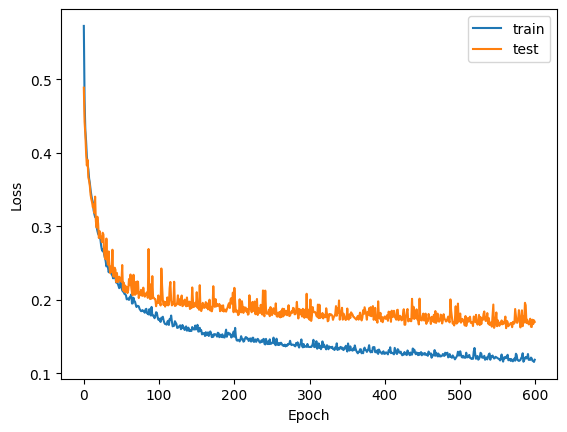

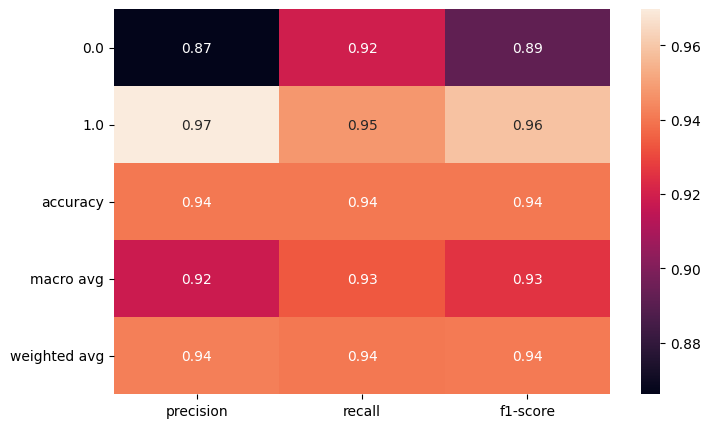

In [ ]:
model = ComplexLSTM(input_size = 178, hidden_size = 50, num_layers = 1, output_size = 2)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=0.001)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(600):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        yb_pred = model(xb)

        loss = criterion(yb_pred, yb)
        epoch_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model(xb_test)
            
            yb_pred_test = yb_pred_test.squeeze(1).float()

            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_test = torch.tensor(X_test).float()
y_val_pred = model(X_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_pt_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_lstm = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_lstm).iloc[:-1, :].T, annot=True)
plt.show()

Epoch 1, Train Loss: 0.6128, Test Loss: 0.5694
Epoch 2, Train Loss: 0.4975, Test Loss: 0.4404
Epoch 3, Train Loss: 0.4361, Test Loss: 0.4183
Epoch 4, Train Loss: 0.4213, Test Loss: 0.4166
Epoch 5, Train Loss: 0.4123, Test Loss: 0.4093
Epoch 6, Train Loss: 0.4002, Test Loss: 0.3861
Epoch 7, Train Loss: 0.3916, Test Loss: 0.3802
Epoch 8, Train Loss: 0.3815, Test Loss: 0.3706
Epoch 9, Train Loss: 0.3768, Test Loss: 0.3641
Epoch 10, Train Loss: 0.3697, Test Loss: 0.3581
Epoch 11, Train Loss: 0.3663, Test Loss: 0.3570
Epoch 12, Train Loss: 0.3629, Test Loss: 0.3527
Epoch 13, Train Loss: 0.3647, Test Loss: 0.3571
Epoch 14, Train Loss: 0.3607, Test Loss: 0.3476
Epoch 15, Train Loss: 0.3562, Test Loss: 0.3586
Epoch 16, Train Loss: 0.3600, Test Loss: 0.3444
Epoch 17, Train Loss: 0.3519, Test Loss: 0.3458
Epoch 18, Train Loss: 0.3515, Test Loss: 0.3420
Epoch 19, Train Loss: 0.3481, Test Loss: 0.3395
Epoch 20, Train Loss: 0.3457, Test Loss: 0.3359
Epoch 21, Train Loss: 0.3415, Test Loss: 0.3309
E

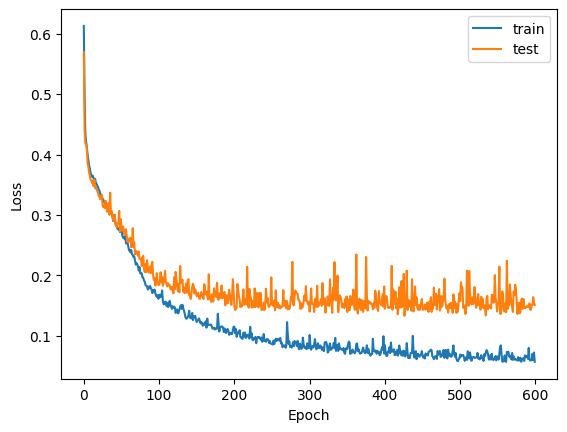

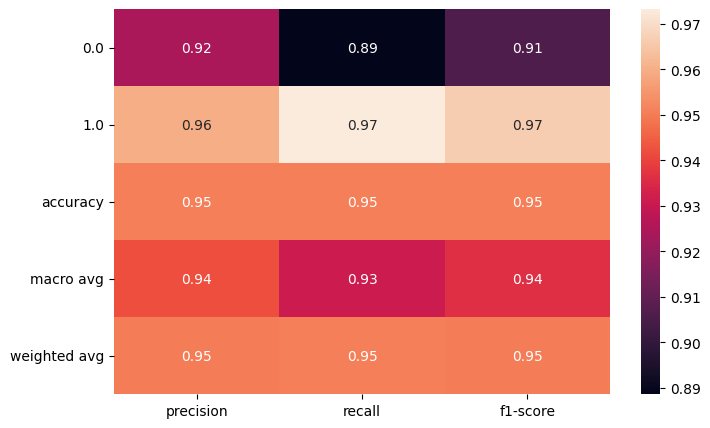

In [ ]:
model = ComplexLSTM(input_size = 178, hidden_size = 50, num_layers = 3, output_size = 2)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=0.001)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(600):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        yb_pred = model(xb)

        loss = criterion(yb_pred, yb)
        epoch_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model(xb_test)
            
            yb_pred_test = yb_pred_test.squeeze(1).float()

            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_test = torch.tensor(X_test).float()
y_val_pred = model(X_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_pt_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_lstm = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_lstm).iloc[:-1, :].T, annot=True)
plt.show()

#### Arhitectură de tip **LSTM 3.0**

In [ ]:
train_ds = TensorDataset(X_train, y_pt_train_encoded)
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)

test_ds = TensorDataset(X_test, y_pt_test_encoded)
test_dl = DataLoader(test_ds, batch_size=256, shuffle=True)

In [ ]:
class ComplexLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(ComplexLSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        # Initialize the hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward pass through the LSTM layer
        out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # Pass the final hidden state through Linear layers
        out = self.fc1(hn[-1])
        out = self.fc2(out)
        
        return out

Epoch 1, Train Loss: 0.6185, Test Loss: 0.5780
Epoch 2, Train Loss: 0.5873, Test Loss: 0.5757
Epoch 3, Train Loss: 0.5794, Test Loss: 0.5604
Epoch 4, Train Loss: 0.5636, Test Loss: 0.5384
Epoch 5, Train Loss: 0.5332, Test Loss: 0.5020
Epoch 6, Train Loss: 0.4980, Test Loss: 0.4751
Epoch 7, Train Loss: 0.4744, Test Loss: 0.4484
Epoch 8, Train Loss: 0.4554, Test Loss: 0.4449
Epoch 9, Train Loss: 0.4450, Test Loss: 0.4215
Epoch 10, Train Loss: 0.4307, Test Loss: 0.4164
Epoch 11, Train Loss: 0.4221, Test Loss: 0.4102
Epoch 12, Train Loss: 0.4135, Test Loss: 0.4035
Epoch 13, Train Loss: 0.4061, Test Loss: 0.3958
Epoch 14, Train Loss: 0.4006, Test Loss: 0.3935
Epoch 15, Train Loss: 0.3935, Test Loss: 0.3886
Epoch 16, Train Loss: 0.3901, Test Loss: 0.3801
Epoch 17, Train Loss: 0.3816, Test Loss: 0.3680
Epoch 18, Train Loss: 0.3749, Test Loss: 0.3682
Epoch 19, Train Loss: 0.3725, Test Loss: 0.3630
Epoch 20, Train Loss: 0.3665, Test Loss: 0.3578
Epoch 21, Train Loss: 0.3610, Test Loss: 0.3579
E

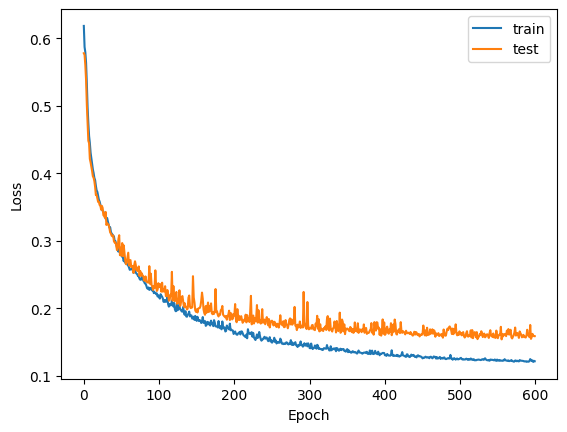

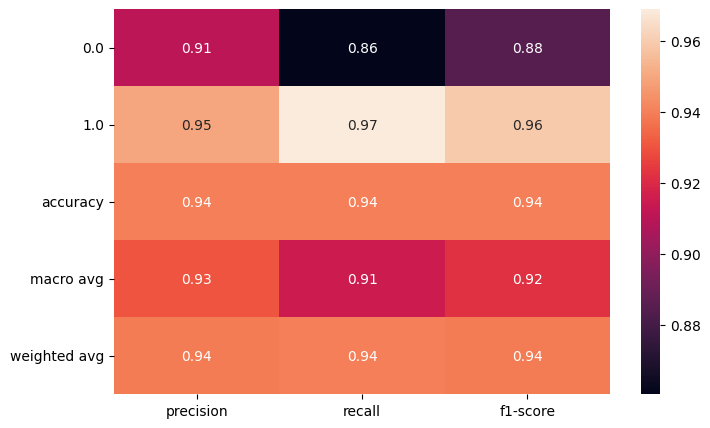

In [ ]:
model = ComplexLSTM(input_size = 178, hidden_size = 50, num_layers = 1, output_size = 2)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()

# define the optimizer with SGD and momentum
optimizer = torch.optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=0.001)

# define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma = 0.8)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(600):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        yb_pred = model(xb)

        loss = criterion(yb_pred, yb)
        epoch_train_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    scheduler.step()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model(xb_test)
            
            yb_pred_test = yb_pred_test.squeeze(1).float()

            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_test = torch.tensor(X_test).float()
y_val_pred = model(X_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_pt_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_lstm = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_lstm).iloc[:-1, :].T, annot=True)
plt.show()

Epoch 1, Train Loss: 0.6180, Test Loss: 0.5718
Epoch 2, Train Loss: 0.5836, Test Loss: 0.5655
Epoch 3, Train Loss: 0.5743, Test Loss: 0.5527
Epoch 4, Train Loss: 0.5543, Test Loss: 0.5306
Epoch 5, Train Loss: 0.5219, Test Loss: 0.4938
Epoch 6, Train Loss: 0.4912, Test Loss: 0.4686
Epoch 7, Train Loss: 0.4704, Test Loss: 0.4548
Epoch 8, Train Loss: 0.4589, Test Loss: 0.4417
Epoch 9, Train Loss: 0.4476, Test Loss: 0.4341
Epoch 10, Train Loss: 0.4406, Test Loss: 0.4277
Epoch 11, Train Loss: 0.4333, Test Loss: 0.4242
Epoch 12, Train Loss: 0.4253, Test Loss: 0.4090
Epoch 13, Train Loss: 0.4174, Test Loss: 0.4089
Epoch 14, Train Loss: 0.4087, Test Loss: 0.3982
Epoch 15, Train Loss: 0.4023, Test Loss: 0.3962
Epoch 16, Train Loss: 0.3960, Test Loss: 0.3893
Epoch 17, Train Loss: 0.3883, Test Loss: 0.3814
Epoch 18, Train Loss: 0.3825, Test Loss: 0.3748
Epoch 19, Train Loss: 0.3768, Test Loss: 0.3779
Epoch 20, Train Loss: 0.3733, Test Loss: 0.3680
Epoch 21, Train Loss: 0.3655, Test Loss: 0.3628
E

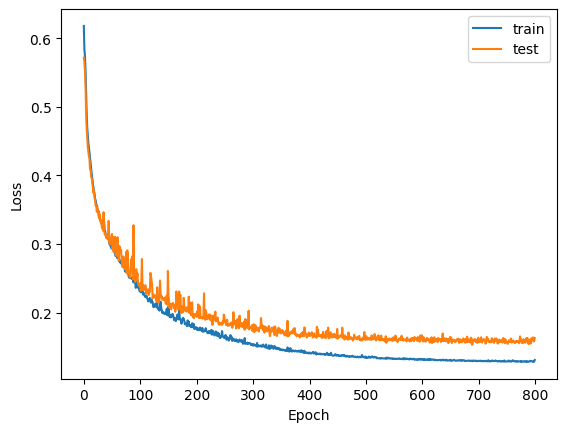

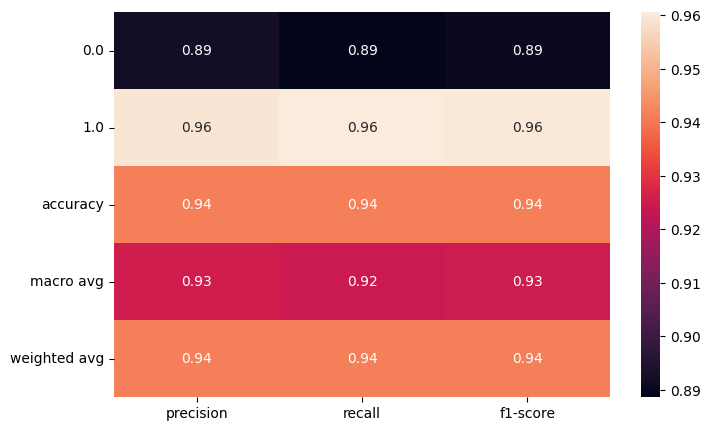

In [ ]:
model = ComplexLSTM(input_size = 178, hidden_size = 50, num_layers = 1, output_size = 2)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()

# define the optimizer with SGD and momentum
optimizer = torch.optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=0.001)

# define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma = 0.8)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(800):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        yb_pred = model(xb)

        loss = criterion(yb_pred, yb)
        epoch_train_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    scheduler.step()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model(xb_test)
            
            yb_pred_test = yb_pred_test.squeeze(1).float()

            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_test = torch.tensor(X_test).float()
y_val_pred = model(X_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_pt_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_lstm = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_lstm).iloc[:-1, :].T, annot=True)
plt.show()

Epoch 1, Train Loss: 0.6186, Test Loss: 0.5778
Epoch 2, Train Loss: 0.5861, Test Loss: 0.5714
Epoch 3, Train Loss: 0.5786, Test Loss: 0.5623
Epoch 4, Train Loss: 0.5637, Test Loss: 0.5390
Epoch 5, Train Loss: 0.5345, Test Loss: 0.5056
Epoch 6, Train Loss: 0.5007, Test Loss: 0.4723
Epoch 7, Train Loss: 0.4782, Test Loss: 0.4587
Epoch 8, Train Loss: 0.4637, Test Loss: 0.4433
Epoch 9, Train Loss: 0.4502, Test Loss: 0.4323
Epoch 10, Train Loss: 0.4405, Test Loss: 0.4309
Epoch 11, Train Loss: 0.4319, Test Loss: 0.4160
Epoch 12, Train Loss: 0.4222, Test Loss: 0.4182
Epoch 13, Train Loss: 0.4136, Test Loss: 0.4027
Epoch 14, Train Loss: 0.4078, Test Loss: 0.4022
Epoch 15, Train Loss: 0.4015, Test Loss: 0.3957
Epoch 16, Train Loss: 0.3947, Test Loss: 0.3949
Epoch 17, Train Loss: 0.3888, Test Loss: 0.3913
Epoch 18, Train Loss: 0.3824, Test Loss: 0.3813
Epoch 19, Train Loss: 0.3798, Test Loss: 0.3695
Epoch 20, Train Loss: 0.3736, Test Loss: 0.3698
Epoch 21, Train Loss: 0.3691, Test Loss: 0.3655
E

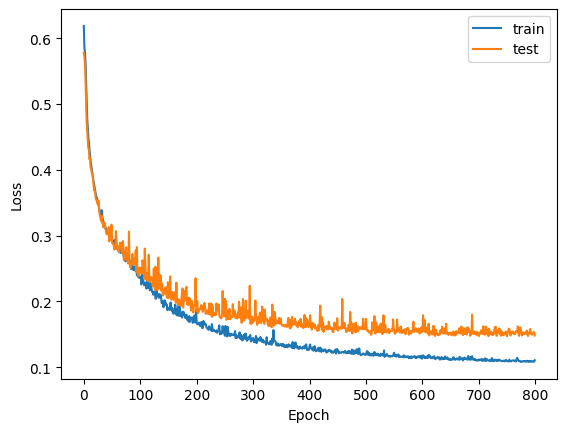

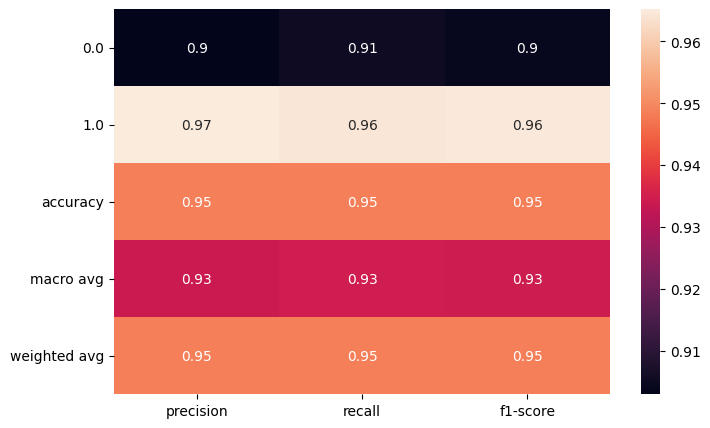

In [ ]:
model = ComplexLSTM(input_size = 178, hidden_size = 70, num_layers = 1, output_size = 2)

# define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()

# define the optimizer with SGD and momentum
optimizer = torch.optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=0.001)

# define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=70, gamma = 0.8)

# lists to store the loss values for plotting
train_losses = []
test_losses = []

# train the model
for epoch in range(800):
    epoch_train_loss = 0

    for xb, yb in train_dl:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        yb_pred = model(xb)

        loss = criterion(yb_pred, yb)
        epoch_train_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    scheduler.step()

    epoch_train_loss /= len(train_dl)
    train_losses.append(epoch_train_loss)

    # evaluate the model on the validation set
    epoch_test_loss = 0.0
    with torch.no_grad():
        for xb_test, yb_test in test_dl:
            yb_pred_test = model(xb_test)
            
            yb_pred_test = yb_pred_test.squeeze(1).float()

            test_loss = criterion(yb_pred_test, yb_test)
            epoch_test_loss += test_loss.item()

    epoch_test_loss /= len(test_dl)
    test_losses.append(epoch_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# evaluate the model on the validation set
X_test = torch.tensor(X_test).float()
y_val_pred = model(X_test)
y_val_pred = torch.argmax(y_val_pred, dim=1).numpy()

y_val_true = y_pt_test
y_val_pred = torch.tensor(y_val_pred).float().numpy()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

report_lstm = classification_report(y_val_true, y_val_pred, output_dict=True)

figure, axes = plt.subplots(1, 1, sharex = True, sharey = True)
figure.set_figwidth(8)
figure.set_figheight(5)

sns.heatmap(pd.DataFrame(report_lstm).iloc[:-1, :].T, annot=True)
plt.show()